In [1]:
# Make the notebook full screen
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import os
import pandas as pd
import importlib
#os.getcdw()
#code_dir = os.path.dirname(os.getcdw())
#project_dir = os.path.dirname(os.path.dirname(os.getcdw()))
#data_path = os.path.join(code_dir, 'data')
#functions_path = os.path.join(project_dir, 'functions')
code_dir = r'C:\Users\creep\Anaconda\Sotiris_Solutions\2_Supervised_Modeling\src'
project_dir = r'C:\Users\creep\Anaconda\Sotiris_Solutions\2_Supervised_Modeling'
data_path = r'C:\Users\creep\Anaconda\Sotiris_Solutions\2_Supervised_Modeling\data'
functions_path = r'C:\Users\creep\Anaconda\Sotiris_Solutions\functions'
print(code_dir)
print(project_dir)
print(data_path)
print(functions_path)

ModuleNotFoundError: No module named 'pandas'

In [ ]:
# General Python modules
import time
import pandas as pd
import numpy as np
import importlib
import json

In [ ]:
# Set the path for the library
import sys
sys.path.insert(0, functions_path)
import variable_reduction as vr
from solution_steps import color
from data_quality_report import dq_report
import preprocessing as pp
import data_processing as cpd
import lasso_feature_selection as lfs
import logistic_regression as lreg 
from load_data import load_data
import solution_steps as ss
import feature_selection as fs
import model_builder as mb
import evaluation as ev
import keras_functions as ks_fn

In [ ]:
pd.set_option('display.max_columns', 100)

# Initialize the solution variables

In [ ]:
with open(os.path.join(project_dir, 'data/input/Supervised_Modeling_Solution_Input.json')) as f:
    inputs = json.load(f)

In [ ]:
inputs

## Essential parameters

In [ ]:
# String. Specify how to load the data. Options: csv, parq.
Load_from = inputs["Load_from"]
# String. Specify the data location: this is the folder where the data for this project are saved. 
data_location = inputs["data_location"]
# String. Set the input data file. 
table_name = inputs["table_name"]
# Float. Number between 0-1 determining what percent of data to subsample. 
sample = float(inputs["sample"])
# String. Set the target variable name in the original dataset. 
target_variable_name = inputs["target_variable_name"]
# String. Set the weight variable name in the original dataset. If not avaulable, then provide "None".
weight_variable_name = inputs["weight_variable_name"]
# String. Set the sample column that has sample information, e.g. train/test/OOT or segment information, and will be used to split the data in different samples
# String. If this column does not exist, then provide "None".
sample_variable_name = inputs["sample_variable_name"]
# List of strings. Set the sub-sample values that are in the sample_variable_name field, e.f. for train/test data split and/or for different segments. 
# All samples defined in this parameters will be picked up by the solution and results will be created for these samples. 
# If sample column does not exist, then provide '[None]' (without quotes).
sample_values = inputs["sample_values"]
# String. Name of the amount/cost per record. If this column does not exist, then provide "None".
amount_variable_name = inputs["amount_variable_name"]
# List. Provide the feature names for the numeric variables that will be used for modeling. 
original_candidate_variables_numeric = inputs["numeric_variables_modeling"]
# List. Provide the feature names for the character variables that will be used for modeling. 
original_candidate_variables_character = inputs["character_variables_modeling"]

## Advanced parameters

In [ ]:
# Float. Takes values between 0 and 1. Used in 'select_missing_variables_to_drop' function. Variables with percentage missing values above this threshold will be 
# dropped from the rest of the process. 
select_missing_variables_to_drop_threshold = inputs["select_missing_variables_to_drop_threshold"]
# Integer. Used in 'character_classification' function. Character variables with more levels than this threshold will be dropped from the rest of the process. 
character_classification_threshold = inputs["character_classification_threshold"]
# Float. Used in the 'replace_outliers' function in the outlier removal section. This is the coefficient for Interquantile range. 
# It can be used to adjust how many outliers to replace; the higher the value the less outliers are replaced. 
iqr_coef = inputs["iqr_coef"]
# String. Used in 'impute_missing' class. Select the stratefy to impute the missing values. Current options are "median", "mean", 
# or a specific value without quotes, e.g. 0.
impute_missing_imputation_strategy = inputs["impute_missing_imputation_strategy"]
# Float. Variables with Gini coefficient below this threshold will be dropped from the reamained of the analysis. 
gini_threshold = inputs["gini_threshold"]
# Float. Used in 'corr_eliminator' function in the initial correlations calculations. Variables with correlation greater than this threshold will be dropped. 
#corr_threshold = inputs["corr_threshold"]
# Int. Used in the 'corr_eliminator' function in the initial correlations calculations. After highly correlated features are dropped, this is the number of the next highest correlations. 
#top_n = eval(inputs["top_n"])
# Float. Used in the 'vif_eliminator' function in the initial VIF calculations. Variables with VIF greater than this threshold will be dropped.
#first_vif_threshold = inputs["first_vif_threshold"]
# Float. Used in the 'vif_eliminator' function in the Lasso Logistic Regression. Variables with VIF greater than this threshold will be dropped.
#second_vif_threshold = inputs["second_vif_threshold"]
# String. User selects which criterion to optimize for feature selection. Options are: "AIC", "BIC".
#lasso_criterion = inputs["lasso_criterion"]
# Boolean. Used to determine whether VIF is run after the correlation feature elimination step. 
#VIF_reduction = inputs["VIF_reduction"]

# Load the data

In [ ]:
data_full = load_data(method = Load_from, 
                     data_path = data_location, 
                     table_name = table_name, 
                     sample = sample)

In [ ]:
data_full.info()

In [ ]:
data_full.head()

# Create the Weight and Sample variables, if not available in the input dataset

In [ ]:
# Create the weight variable
data_full, weight_variable_name_solution = ss.weight_var_assignment(data_full = data_full, 
                                                                 weight_variable_name = weight_variable_name)

# Create the sample variable
data_full, sample_values_solution, sample_variable_name_solution = ss.sample_var_assignment(data_full = data_full, 
                                                                                         sample_variable_name = sample_variable_name, 
                                                                                           sample_values = sample_values)

# Convert variable data types based on user information

In [ ]:
# Convert character variables
data_full, character_variables_list = ss.convert_character_var(data_full = data_full, 
                                                        original_candidate_variables_character = original_candidate_variables_character,
                                                        sample_variable_name_solution = sample_variable_name_solution)

# Convert numeric variables
data_full, numeric_variables_list = ss.convert_numeric_var(data_full = data_full, 
                                                        original_candidate_variables_numeric = original_candidate_variables_numeric,
                                                        weight_variable_name_solution = weight_variable_name_solution, 
                                                        target_variable_name = target_variable_name)

# Data quality report

In [ ]:
dq = dq_report(df = data_full, 
                data_path = data_path, 
                variables = character_variables_list + numeric_variables_list, 
                weight_variable = weight_variable_name_solution, 
                dq_report_file = 'data_quality_report.csv')

# Split sample data

In [ ]:
data, sample_values_dict = ss.split_sample_data(
    data_full=data_full, 
    sample_values_solution=sample_values_solution, 
    sample_variable_name_solution=sample_variable_name_solution
    )

# Set the original candidate variables

In [ ]:
original_candidate_variables = original_candidate_variables_character + original_candidate_variables_numeric
print(color.BLUE + 'Original candidate variables: ' + color.END + str(original_candidate_variables))

# Remove variables with high missing values percentage

In [ ]:
# Variables excluded from the non-predictive features: keys, target, sample, etc
excluded_variables = [x for x in data['data_{}'.format(sample_values_solution[0])].columns if x not in original_candidate_variables]
print(color.BLUE + 'Variables to be excluded: ' + color.END + str(excluded_variables))
print()
# Produce and save the missing values table to review
missing_variables_table, missing_variables = ss.missing_values_vars(
    sample_values_dict=sample_values_dict, 
    data_path=data_path, 
    data=data, 
    weight_variable_name_solution=weight_variable_name_solution, 
    select_missing_variables_to_drop_threshold=select_missing_variables_to_drop_threshold
    )
# Create the variables to remove: non-predictors + variables with too many missing information
excluded_variables = excluded_variables + missing_variables
print(color.BLUE + 'Variables to remove from the remainder of the analysis: ' + color.END + str(excluded_variables))

# Remove character variables with many levels

In [ ]:
keep_char_vars_levels = ss.character_var_levels(
    data = data, 
    data_path = data_path, 
    sample_values_solution = sample_values_solution,
    excluded_variables = excluded_variables, 
    character_classification_threshold = character_classification_threshold
    )

# Outlier replacement for numeric variables

In [ ]:
outlier_variables = [i for i in original_candidate_variables_numeric if i not in excluded_variables]
data_full = cpd.replace_outliers(
    input_data = data_full, 
    variables = outlier_variables, 
    weight_variable = weight_variable_name_solution, 
    data_path = data_path, 
    outlier_info_file = 'outlier_info.csv', 
    iqr_coef = iqr_coef
    )

In [ ]:
# Split sample data
data = {}
for i, j in sample_values_dict.items():
    start_time = time.time()
    print(color.BOLD + color.PURPLE + color.UNDERLINE + j + color.END)
    
    data['data_{}'.format(i)] = data_full[data_full[sample_variable_name_solution]==i]
    print('The shape is: ', data['data_{}'.format(i)].shape)
    
    print('This code took %.2fs. to run'%(time.time() - start_time))

# Convert categorical variables to binary variables

In [ ]:
cpd.character_to_binary(
    input_data = data_full, 
    input_variable_list = keep_char_vars_levels, 
    drop = 'last', # Specifies which value to drop from the one hot encoder. None will return binary variables for all categories. 'first' will drop the most populated category. 'last' will drop the less populated category. 
    protected_class_valid_values = None # Specifies accepted values for the protected class column. For non-protected class conversions use 'None'
    )

In [ ]:
# Split sample data
data = {}
for i, j in sample_values_dict.items():
    start_time = time.time()
    print(color.BOLD + color.PURPLE + color.UNDERLINE + j + color.END)
    
    data['data_{}'.format(i)] = data_full[data_full[sample_variable_name_solution]==i]
    print('The shape is: ', data['data_{}'.format(i)].shape)
    
    print('This code took %.2fs. to run'%(time.time() - start_time))

In [ ]:
# Keep all numeric variables, including those that were one-hot encoded
keep_num_vars = cpd.identify_numeric_variables(input_data=data['data_{}'.format(sample_values_solution[0])])
keep_num_vars = [x for x in keep_num_vars if x not in excluded_variables]
print('Keeping the following variables: ', keep_num_vars)
print(len(keep_num_vars))

# Impute missing values

In [ ]:
variables_with_missing_dict = {}
for i, j in sample_values_dict.items():
    start_time = time.time()
    print(color.BOLD + color.PURPLE + color.UNDERLINE + j + color.END)
    
    variables_with_missing_dict['variables_with_missing_dict_{}'.format(i)] = cpd.select_missing_variables_to_drop(
    data_path = data_path, 
    sample_name = j, 
    threshold = 0
    )
    
    print('This code took %.2fs. to run'%(time.time() - start_time))

In [ ]:
# Select numeric features with missing values. Imputation will be applied to only these features, in order to improve the performance of the code. 
variables_with_missing = list(dict.fromkeys(sum(variables_with_missing_dict.values(), [])))
num_variables_with_missing = [i for i in keep_num_vars if i in variables_with_missing]
num_variables_with_missing

In [ ]:
# Impute missing values
start_time = time.time()
impute_missing = cpd.impute_missing(
        variables = num_variables_with_missing, 
        imputation_strategy = impute_missing_imputation_strategy)
impute_missing.imputation_fit_weight(
        input_data = data['data_{}'.format(sample_values_solution[0])], 
        weight_variable = weight_variable_name_solution)

for i, j in sample_values_dict.items():
    impute_missing.imputation_transform(input_data = data['data_{}'.format(i)])

print('This code took %.2fs. to run'%(time.time() - start_time))

In [ ]:
# Check missing values for imputed variables
for i, j in sample_values_dict.items():
    start_time = time.time()
    print(color.BOLD + color.PURPLE + color.UNDERLINE + j + color.END)

    if num_variables_with_missing != []:
        print(data['data_{}'.format(i)][num_variables_with_missing].apply
              (lambda x: (sum(data['data_{}'.format(i)][x.isnull()][weight_variable_name_solution])
                /sum(data['data_{}'.format(i)][weight_variable_name_solution])) * 100, axis=0).sort_values(ascending=False))
    else: 
        print('There are no variables with missing values to impute')

    print('This code took %.2fs. to run'%(time.time() - start_time))

# Drop numeric variables with only one value

In [ ]:
keep_num_vars_one_v = ss.keep_num_variables_one_value(
    keep_num_vars = keep_num_vars, 
    data_path = data_path, 
    dq_report = 'data_quality_report.csv'
    )

# Drop variables based on low Gini

In [ ]:
gini_table = pp.gini_values_weight(feats = keep_num_vars_one_v, 
                   input_data = data['data_{}'.format(sample_values_solution[0])], 
                   target_variable = target_variable_name, 
                   weight_variable = weight_variable_name_solution, 
                   data_path = data_path, 
                   gini_info_file = 'gini_info.csv', 
                   n_bands = 10)
keep_num_vars_gini = list(gini_table.loc[gini_table['Gini coefficient'] >= gini_threshold, 'variable'].values)
print(color.PURPLE + 'Keeping the following variables with Gini > ' + str(gini_threshold) + ': ' + color.END + str(keep_num_vars_gini))
print(len(keep_num_vars_gini))

# Random Forest

In [31]:
rf_initial_screening_var_threshold = 20
rf_backward_selection_var_threshold = 15

## Feature selection RF

In [32]:
# Provide input data to feature selection class
select = fs.SelectBest_weight(df=data['data_{}'.format(sample_values_solution[0])], 
                              target=target_variable_name, 
                              weight=weight_variable_name)

In [33]:
# Select top features to apply a first screening
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier(n_estimators=200, max_depth=5, random_state=1234, n_jobs=6)
rf_importance, feats_best_rf = select.top_rf_feat(feats=keep_num_vars_gini, model=model_rf, n=rf_initial_screening_var_threshold)
print('The top Random Forest features are: \n', feats_best_rf)
rf_importance

top_rf_feat took 1.11 seconds
The top Random Forest features are: 
 ['random_var_7', 'random_var_15', 'random_var_8', 'random_var_11', 'random_var_19', 'random_var_10', 'random_var_6', 'random_var_16', 'random_var_13', 'random_var_17', 'random_var_9', 'random_var_5', 'random_var_3', 'random_var_1', 'random_var_0', 'num_20%', 'random_var_2', 'random_var_18', 'random_var_4', 'random_var_12']


[('random_var_7', 0.21856212969503508),
 ('random_var_15', 0.20791891312990674),
 ('random_var_8', 0.10482738841819203),
 ('random_var_11', 0.07118862812461386),
 ('random_var_19', 0.06696199283544559),
 ('random_var_10', 0.06235549940331413),
 ('random_var_6', 0.04965907560278736),
 ('random_var_16', 0.037445586851528274),
 ('random_var_13', 0.03452627078551132),
 ('random_var_17', 0.03175626167311093),
 ('random_var_9', 0.0286393743577446),
 ('random_var_5', 0.02807462658833157),
 ('random_var_3', 0.023115119373733582),
 ('random_var_1', 0.015584876037003446),
 ('random_var_0', 0.002883701803174528),
 ('num_20%', 0.0027145476763139435),
 ('random_var_2', 0.0025139243102381696),
 ('random_var_18', 0.0024580196424033225),
 ('random_var_4', 0.002344310206581808),
 ('random_var_12', 0.0022184468020439983),
 ('num_2%', 0.002020836857567861),
 ('random_var_14', 0.0018005214189543094),
 ('cat_3_3', 0.00024198511052304293),
 ('cat_3_2', 0.00018796329594044292)]

In [34]:
#import timeit
#start = timeit.default_timer()

# Backward selection with random forest model: In each step a feature is selected to remove - this removal maximizes Gini
feats_best_rf_back = select.backward_recur(feats=feats_best_rf, 
                                           oos=data['data_{}'.format(sample_values_solution[1])], 
                                           model=model_rf, 
                                           min_feats=rf_backward_selection_var_threshold, 
                                           classification=True)
print(feats_best_rf_back)

#stop = timeit.default_timer()
#print('Execution time in seconds: ', stop - start)  

C:\Data_Science\Miniconda\envs\Unsupervised_Modeling\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\creep\Anaconda\Sotiris_Solutions\functions\feature_selection.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oos['score']=model.predict_proba(oos[left].values)[:, 1]
C:\Data_Science\Miniconda\envs\Unsupervised_Modeling\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\creep\Anaconda\Sotiris_Solutions\functions\feature_selection.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of

step i = 1 feature removed: random_var_16 gini: 0.9078008402251374


C:\Data_Science\Miniconda\envs\Unsupervised_Modeling\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\creep\Anaconda\Sotiris_Solutions\functions\feature_selection.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oos['score']=model.predict_proba(oos[left].values)[:, 1]
C:\Data_Science\Miniconda\envs\Unsupervised_Modeling\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\creep\Anaconda\Sotiris_Solutions\functions\feature_selection.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of

step i = 2 feature removed: random_var_18 gini: 0.9104719594463846


C:\Data_Science\Miniconda\envs\Unsupervised_Modeling\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\creep\Anaconda\Sotiris_Solutions\functions\feature_selection.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oos['score']=model.predict_proba(oos[left].values)[:, 1]
C:\Data_Science\Miniconda\envs\Unsupervised_Modeling\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\creep\Anaconda\Sotiris_Solutions\functions\feature_selection.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of

step i = 3 feature removed: random_var_0 gini: 0.908965770563885


C:\Data_Science\Miniconda\envs\Unsupervised_Modeling\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\creep\Anaconda\Sotiris_Solutions\functions\feature_selection.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oos['score']=model.predict_proba(oos[left].values)[:, 1]
C:\Data_Science\Miniconda\envs\Unsupervised_Modeling\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\creep\Anaconda\Sotiris_Solutions\functions\feature_selection.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of

step i = 4 feature removed: random_var_12 gini: 0.9077323309993481


C:\Data_Science\Miniconda\envs\Unsupervised_Modeling\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\creep\Anaconda\Sotiris_Solutions\functions\feature_selection.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oos['score']=model.predict_proba(oos[left].values)[:, 1]
C:\Data_Science\Miniconda\envs\Unsupervised_Modeling\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\creep\Anaconda\Sotiris_Solutions\functions\feature_selection.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of

step i = 5 feature removed: random_var_2 gini: 0.906134817990981
backward_recur took 102.56 seconds
['random_var_7', 'random_var_15', 'random_var_8', 'random_var_11', 'random_var_19', 'random_var_10', 'random_var_6', 'random_var_13', 'random_var_17', 'random_var_9', 'random_var_5', 'random_var_3', 'random_var_1', 'num_20%', 'random_var_4']


C:\Data_Science\Miniconda\envs\Unsupervised_Modeling\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\creep\Anaconda\Sotiris_Solutions\functions\feature_selection.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oos['score']=model.predict_proba(oos[left].values)[:, 1]


## Grid search and train RF machine learning model

### Grid search based on iterative step

In [35]:
# Hyperparameter tuning: The process works as follows:
# 1) Iterate n_estimators (grid) for the fixed values of max_depth and max_features (params). Select the value of n_estimators that minimizes the loss function. 
# 2) Keep the n_estimators value from the previous step. Iterate max_depth (grid) for the fixed value of max_features (params). Select the value of max_depth that minimizes the loss function. 
# 3) Keep the max_depth value from the previous step. Iterate max_features (grid). Select the value of max_features that minimizes the loss function. 
#import timeit
#start = timeit.default_timer()

import math
# 18 models in total
grid = {'n_estimators':[10, 50, 80, 100, 200, 400],  # Number of trees, 100-500 is usually sufficient /
       'max_depth':[2, 5, 10, 20],  # Depth of the tree, 5-6 is usually default
       'max_features':[*range(1,len(feats_best_rf_back),math.ceil(len(feats_best_rf_back)/5))],  # Number of variables randomly sampled as candidates at each split, sqrt(p) is usually the default
       'min_samples_leaf': [1, 10, 100]} # Minimum number of observations in each leaf, 10 is usually default

params = {'n_estimators': 100, 'max_depth':10, 'max_features':math.ceil(math.sqrt(len(feats_best_rf_back))), 'min_samples_leaf':10}

opt_params_iterative, loss = mb.step_search_weight(estimator=RandomForestClassifier, 
                                                   params=params, 
                                                   grid=grid, 
                                                   target=target_variable_name, 
                                                   weight=weight_variable_name, 
                                                   dev=data['data_{}'.format(sample_values_solution[0])], 
                                                   val=data['data_{}'.format(sample_values_solution[1])], 
                                                   keep=feats_best_rf_back)
print('\n Best Parameters')
print(opt_params_iterative)
print(loss)

# Load RF machine leanring library
from sklearn.ensemble import RandomForestClassifier
import joblib

# Define the random forest model
rf = RandomForestClassifier(n_estimators=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='n_estimators'][0], 
                            max_depth=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='max_depth'][0], 
                            max_features=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='max_features'][0], 
                            min_samples_leaf=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='min_samples_leaf'][0], 
                            random_state=0)

# Train the model
rf_model = mb.fit_model_weight(df=data['data_{}'.format(sample_values_solution[0])], 
                               feats=feats_best_rf_back, 
                               target=target_variable_name, 
                               weight=weight_variable_name, 
                               model=rf, 
                               model_name='rf_iterative.pkl')

# Compute the score for the OOT data
data['data_{}'.format(sample_values_solution[1])]['rf_score_iterative'] = rf_model.predict_proba(data['data_{}'.format(sample_values_solution[1])][feats_best_rf_back].values)[:, 1]

#stop = timeit.default_timer()
#print('Execution time in seconds: ', stop - start)  
#Execution time in seconds:  9.485360900000003

Search Progress:


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


{'n_estimators': 10, 'max_depth': 10, 'max_features': 4, 'min_samples_leaf': 10} n_estimators 10 0.19351180798932685 0.19351180798932685


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


{'n_estimators': 50, 'max_depth': 10, 'max_features': 4, 'min_samples_leaf': 10} n_estimators 50 0.1849590425921854 0.1849590425921854


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


{'n_estimators': 80, 'max_depth': 10, 'max_features': 4, 'min_samples_leaf': 10} n_estimators 80 0.18442836606561708 0.18442836606561708


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


{'n_estimators': 80, 'max_depth': 10, 'max_features': 4, 'min_samples_leaf': 10} n_estimators 100 0.18499686758681097 0.18442836606561708


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


{'n_estimators': 200, 'max_depth': 10, 'max_features': 4, 'min_samples_leaf': 10} n_estimators 200 0.18333555340488042 0.18333555340488042


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


{'n_estimators': 200, 'max_depth': 10, 'max_features': 4, 'min_samples_leaf': 10} n_estimators 400 0.1844189659657008 0.18333555340488042



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


{'n_estimators': 200, 'max_depth': 10, 'max_features': 4, 'min_samples_leaf': 10} max_depth 2 0.3685950185563594 0.18333555340488042


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


{'n_estimators': 200, 'max_depth': 10, 'max_features': 4, 'min_samples_leaf': 10} max_depth 5 0.2526602002099904 0.18333555340488042


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


{'n_estimators': 200, 'max_depth': 10, 'max_features': 4, 'min_samples_leaf': 10} max_depth 10 0.18448714693432394 0.18333555340488042


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


{'n_estimators': 200, 'max_depth': 20, 'max_features': 4, 'min_samples_leaf': 10} max_depth 20 0.18085132966814554 0.18085132966814554



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


{'n_estimators': 200, 'max_depth': 20, 'max_features': 4, 'min_samples_leaf': 10} max_features 1 0.24956546030267301 0.18085132966814554


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


{'n_estimators': 200, 'max_depth': 20, 'max_features': 4, 'min_samples_leaf': 10} max_features 4 0.18094470284846642 0.18085132966814554


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


{'n_estimators': 200, 'max_depth': 20, 'max_features': 7, 'min_samples_leaf': 10} max_features 7 0.1669260550964158 0.1669260550964158


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


{'n_estimators': 200, 'max_depth': 20, 'max_features': 10, 'min_samples_leaf': 10} max_features 10 0.16461316538570125 0.16461316538570125


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


{'n_estimators': 200, 'max_depth': 20, 'max_features': 13, 'min_samples_leaf': 10} max_features 13 0.16255336597706976 0.16255336597706976



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


{'n_estimators': 200, 'max_depth': 20, 'max_features': 13, 'min_samples_leaf': 1} min_samples_leaf 1 0.14737097355210202 0.14737097355210202


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


{'n_estimators': 200, 'max_depth': 20, 'max_features': 13, 'min_samples_leaf': 1} min_samples_leaf 10 0.16682148311719563 0.14737097355210202


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


{'n_estimators': 200, 'max_depth': 20, 'max_features': 13, 'min_samples_leaf': 1} min_samples_leaf 100 0.24292836398167386 0.14737097355210202

step_search_weight took 164.43 seconds

 Best Parameters
{'n_estimators': 200, 'max_depth': 20, 'max_features': 13, 'min_samples_leaf': 1}
0.14737097355210202
fit_model_weight took 27.62 seconds


C:\Users\creep\AppData\Local\Temp\ipykernel_26100\3911715707.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['data_{}'.format(sample_values_solution[1])]['rf_score_iterative'] = rf_model.predict_proba(data['data_{}'.format(sample_values_solution[1])][feats_best_rf_back].values)[:, 1]


### Grid search based on RandomizedSearchCV - also uses cross-validation

grid_search_cv took 254.98 seconds
The best hyperparameter set is: {'n_estimators': 400, 'min_samples_leaf': 1, 'max_features': 17, 'max_depth': 7, 'criterion': 'entropy'}
Mean loss function for cross-validation test data:  0.18452103773539014
Standard deviation loss function for cross-validation test data:  0.0013771680577776002


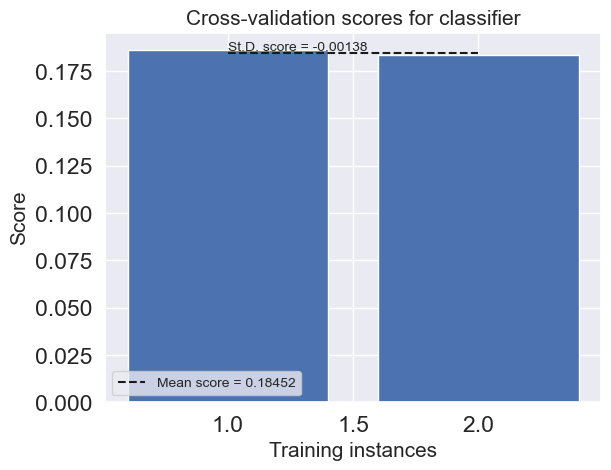

C:\Users\creep\AppData\Local\Temp\ipykernel_26100\3030818637.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['data_{}'.format(sample_values_solution[1])]['rf_score_random'] = rf_grid_random_search_model.predict_proba(data['data_{}'.format(sample_values_solution[1])][feats_best_rf_back].values)[:,1]


In [36]:
#import timeit
#start = timeit.default_timer()

# 1,296 models in total
grid = {'n_estimators':[10, 50, 80, 100, 200, 400],  # Number of trees, 100-500 is usually sufficient /
       'max_depth':[2, 3, 4, 5, 6, 7],  # Depth of the tree, 5-6 is usually default
       'max_features':[*range(15,21,1)],  # Number of variables randomly sampled as candidates at each split, sqrt(p) is usually the default
       'min_samples_leaf': [1, 10, 100], # Minimum number of observations in each leaf, 10 is usually default
       'criterion': ['gini', 'entropy']} # Minimum number of observations in each leaf, 10 is usually default
        
rf_grid_random_search_model = mb.grid_search_cv(
    n_splits = 2, # Number of cross-validation splits
    classifier = RandomForestClassifier, # Classifier name, e.g. RandomForestClassifier
    keras_function = None, # Define Keras function. If Keras is not used, then leave this parameter blank
    grid_params = grid, # Grid space
    dev_df = data['data_{}'.format(sample_values_solution[0])],  # Development sample that this will analysis will be performed
    feats = feats_best_rf_back, # List of predictor names
    target = target_variable_name, # Target variable name
    weight_variable = weight_variable_name, # Weight variable name
    randomized_search = True, # Set to True if randomized grid search will be performed, or to False if exhaustive grid search will be performed
    n_random_grids = 100, # Number of grid searches when randomized_search=True. If randomized_search=False, then this parameter is not applicable
    random_state = None, # If int, random_state is the seed used by the random number generator; If RandomState instance, random_state is the random number generator; If None, the random number generator is the RandomState instance used by np.random.
    n_jobs = 8 # Number of jobs to run in parallel
)

#stop = timeit.default_timer()
#print('Execution time in seconds: ', stop - start)  
#Execution time in seconds:  32.133352299999984

# Save the best parameters
opt_params_random = rf_grid_random_search_model.best_params_
print('The best hyperparameter set is:', opt_params_random)
print('Mean loss function for cross-validation test data: ', -rf_grid_random_search_model.cv_results_['mean_test_score'][rf_grid_random_search_model.best_index_])
print('Standard data['data_{}'.format(sample_values_solution[1])]iation loss function for cross-validation test data: ', rf_grid_random_search_model.cv_results_['std_test_score'][rf_grid_random_search_model.best_index_])
#print('Mean Gini for OOT data', 2*rf_grid_random_search_model.score(oos[feats_best_rf_back], oos[target_variable_name])-1)

ev.plot_cross_validation_score(model=rf_grid_random_search_model)

# Compute the score for the OOT data
data['data_{}'.format(sample_values_solution[1])]['rf_score_random'] = rf_grid_random_search_model.predict_proba(data['data_{}'.format(sample_values_solution[1])][feats_best_rf_back].values)[:,1]

### Grid search based on GridSearchCV - also uses cross-validation

grid_search_cv took 224.06 seconds
The best hyperparameter set is: {'criterion': 'entropy', 'max_depth': 7, 'max_features': 24, 'min_samples_leaf': 1, 'n_estimators': 200}
Mean loss function for cross-validation test data:  0.18753826036439264
Standard deviation loss function for cross-validation test data:  0.007637078513508241


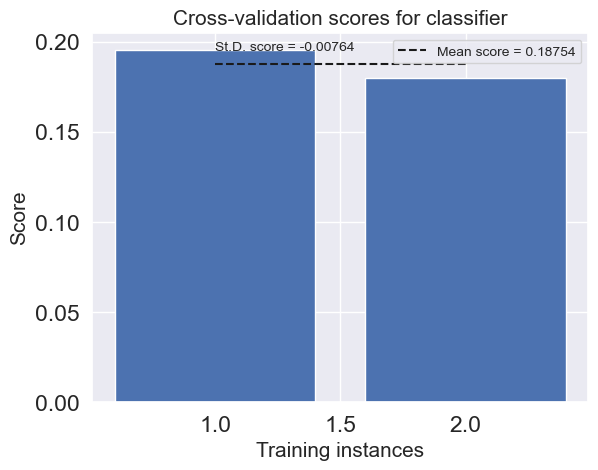

C:\Users\creep\AppData\Local\Temp\ipykernel_26100\1180131678.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['data_{}'.format(sample_values_solution[1])]['rf_score_fixed'] = rf_grid_fixed_search_model.predict_proba(data['data_{}'.format(sample_values_solution[1])][feats_best_rf_back].values)[:, 1]


In [37]:
#import timeit
#start = timeit.default_timer()

# 72 models in total
grid = {'n_estimators':[100, 200],  # Number of trees, 100-500 is usually sufficient /
       'max_depth':[3, 5, 7],  # Depth of the tree, 5-6 is usually default
       'max_features':[18, 21, 24],  # Number of variables randomly sampled as candidates at each split, sqrt(p) is usually the default
       'min_samples_leaf': [1, 10], # Minimum number of observations in each leaf, 10 is usually default
       'criterion': ['gini', 'entropy']} # Minimum number of observations in each leaf, 10 is usually default
        
rf_grid_fixed_search_model = mb.grid_search_cv(
    n_splits = 2, # Number of cross-validation splits
    classifier = RandomForestClassifier, # Classifier name, e.g. RandomForestClassifier
    keras_function = None, # Define Keras function. If Keras is not used, then leave this parameter blank
    grid_params = grid, # Grid space
    dev_df = data['data_{}'.format(sample_values_solution[0])],  # Development sample that this will analysis will be performed
    feats = feats_best_rf_back, # List of predictor names
    target = target_variable_name, # Target variable name
    weight_variable = weight_variable_name, # Weight variable name
    randomized_search = False, # Set to True if randomized grid search will be performed, or to False if exhaustive grid search will be performed
    n_random_grids = 1, # Number of grid searches when randomized_search=True. If randomized_search=False, then this parameter is not applicable
    random_state = None, # If int, random_state is the seed used by the random number generator; If RandomState instance, random_state is the random number generator; If None, the random number generator is the RandomState instance used by np.random.
    n_jobs = 8 # Number of jobs to run in parallel
)

#stop = timeit.default_timer()
#print('Execution time in seconds: ', stop - start)  
#Execution time in seconds:  41.59971730000001

# Save the best parameters
opt_params_fixed = rf_grid_fixed_search_model.best_params_
print('The best hyperparameter set is:', opt_params_fixed)
print('Mean loss function for cross-validation test data: ', -rf_grid_fixed_search_model.cv_results_['mean_test_score'][rf_grid_fixed_search_model.best_index_])
print('Standard deviation loss function for cross-validation test data: ', rf_grid_fixed_search_model.cv_results_['std_test_score'][rf_grid_fixed_search_model.best_index_])
#print('Mean Gini for OOT data', 2*rf_grid_fixed_search_model.score(oos[feats_best_rf_back], oos[target_variable_name], sample_weight=oos[weight_variable_name])-1)

ev.plot_cross_validation_score(model=rf_grid_fixed_search_model)

# Compute the score for the OOT data
data['data_{}'.format(sample_values_solution[1])]['rf_score_fixed'] = rf_grid_fixed_search_model.predict_proba(data['data_{}'.format(sample_values_solution[1])][feats_best_rf_back].values)[:, 1]

## Calculate RF feature importance

In [38]:
# Load RF machine leanring library
from sklearn.ensemble import RandomForestClassifier
import joblib

# Define the random forest model
opt_params = opt_params_random
rf = RandomForestClassifier(n_estimators=[x[1] for x in list(opt_params.items()) if x[0]=='n_estimators'][0], 
                            max_depth=[x[1] for x in list(opt_params.items()) if x[0]=='max_depth'][0], 
                            max_features=[x[1] for x in list(opt_params.items()) if x[0]=='max_features'][0], 
                            min_samples_leaf=[x[1] for x in list(opt_params.items()) if x[0]=='min_samples_leaf'][0], 
                            criterion=[x[1] for x in list(opt_params.items()) if x[0]=='criterion'][0], 
                            random_state=0)

# Train the model
rf_model = mb.fit_model_weight(data['data_{}'.format(sample_values_solution[0])], feats_best_rf_back, target_variable_name, weight_variable_name, rf, 'rf.pkl')

# Calculate feature importance
feat_imprtnce_dictnry = mb.feature_imp(rf_model, feats_best_rf_back)
for key, value in sorted(feat_imprtnce_dictnry.items(), key=lambda item: item[1], reverse=True):
    print("%s: %s" % (key, value))

fit_model_weight took 47.17 seconds
feature_imp took 0.04 seconds
random_var_7: 0.22601332225902418
random_var_15: 0.20330282770064514
random_var_19: 0.11078571352715723
random_var_10: 0.08310333742833968
random_var_11: 0.06689032762877772
random_var_8: 0.060055391298824305
random_var_3: 0.05545461917359255
random_var_5: 0.0542437012730018
random_var_9: 0.03833497366858847
random_var_6: 0.0332886096928583
random_var_17: 0.030315397885626445
random_var_13: 0.020365443164032784
random_var_1: 0.012659876728917547
num_20%: 0.0027390800719720877
random_var_4: 0.0024473784986417373


## Calculate RF log-loss

In [39]:
from sklearn.metrics import log_loss
print ("log-loss_iterative")
print(log_loss(y_true=data['data_{}'.format(sample_values_solution[1])][target_variable_name].values, y_pred=data['data_{}'.format(sample_values_solution[1])]['rf_score_iterative'].values, sample_weight=data['data_{}'.format(sample_values_solution[1])][weight_variable_name].values, eps=1e-15))
print ("log-loss_fixed")
print(log_loss(y_true=data['data_{}'.format(sample_values_solution[1])][target_variable_name].values, y_pred=data['data_{}'.format(sample_values_solution[1])]['rf_score_fixed'].values, sample_weight=data['data_{}'.format(sample_values_solution[1])][weight_variable_name].values, eps=1e-15))
print ("log-loss_random")
print(log_loss(y_true=data['data_{}'.format(sample_values_solution[1])][target_variable_name].values, y_pred=data['data_{}'.format(sample_values_solution[1])]['rf_score_random'].values, sample_weight=data['data_{}'.format(sample_values_solution[1])][weight_variable_name].values, eps=1e-15))

log-loss_iterative
0.14778717119006118
log-loss_fixed
0.16769169828423547
log-loss_random
0.1673589956347971


## Calculate RF Precision/Recall Area Under the Curve

In [40]:
print ("precision_recall_auc_iterative")
print(ev.auc_precision_recall(table_name=data['data_{}'.format(sample_values_solution[1])], target_variable=target_variable_name, predicted_variable='rf_score_iterative', 
                            weight_variable=weight_variable_name))
print ("precision_recall_auc_fixed")
print(ev.auc_precision_recall(table_name=data['data_{}'.format(sample_values_solution[1])], target_variable=target_variable_name, predicted_variable='rf_score_fixed', 
                            weight_variable=weight_variable_name))
print ("precision_recall_auc_random")
print(ev.auc_precision_recall(table_name=data['data_{}'.format(sample_values_solution[1])], target_variable=target_variable_name, predicted_variable='rf_score_random', 
                            weight_variable=weight_variable_name))

precision_recall_auc_iterative
0.9521277541695565
precision_recall_auc_fixed
0.9375805581390266
precision_recall_auc_random
0.9381366862194059


## Calculate RF Gini, for the top population

In [41]:
print ("unit_gini_iterative")
print(ev.calculate_gini(
    table_name=data['data_{}'.format(sample_values_solution[1])], # Table name
    target_variable=target_variable_name, # Target variable name
    predicted_variable='rf_score_iterative', # Predicted variable name
    weight_variable=weight_variable_name, # Weight variable name
    select_top_percent=100 # Percent between 0 and 100: Gini is calculated for the top select_top_percent% of the observations, sorted by score
    ))
print ("unit_gini_fixed")
print(ev.calculate_gini(
    table_name=data['data_{}'.format(sample_values_solution[1])], # Table name
    target_variable=target_variable_name, # Target variable name
    predicted_variable='rf_score_fixed', # Predicted variable name
    weight_variable=weight_variable_name, # Weight variable name
    select_top_percent=100 # Percent between 0 and 100: Gini is calculated for the top select_top_percent% of the observations, sorted by score
    ))
print ("unit_gini_random")
print(ev.calculate_gini(
    table_name=data['data_{}'.format(sample_values_solution[1])], # Table name
    target_variable=target_variable_name, # Target variable name
    predicted_variable='rf_score_random', # Predicted variable name
    weight_variable=weight_variable_name, # Weight variable name
    select_top_percent=100 # Percent between 0 and 100: Gini is calculated for the top select_top_percent% of the observations, sorted by score
    ))

unit_gini_iterative
calculate_gini took 0.0 seconds
0.959701289903677
unit_gini_fixed
calculate_gini took 0.01 seconds
0.9532897713116999
unit_gini_random
calculate_gini took 0.0 seconds
0.9535304359438559


## Calculate RF Lifting table

In [44]:
# Lifting table
lt_rf_iterative = ev.lift_table_weight(data['data_{}'.format(sample_values_solution[1])][['rf_score_iterative', target_variable_name, amount_variable_name, weight_variable_name]].values, n_bands=10, rows=10).round(decimals=3)
lt_rf_fixed = ev.lift_table_weight(data['data_{}'.format(sample_values_solution[1])][['rf_score_fixed', target_variable_name, amount_variable_name, weight_variable_name]].values, n_bands=10, rows=10).round(decimals=3)
lt_rf_random = ev.lift_table_weight(data['data_{}'.format(sample_values_solution[1])][['rf_score_random', target_variable_name, amount_variable_name, weight_variable_name]].values, n_bands=10, rows=10).round(decimals=3)
lt_rf_iterative

lift_table_weight took 0.01 seconds
lift_table_weight took 0.01 seconds
lift_table_weight took 0.0 seconds


Quantile Unit  # Cases  # Responses  Cumulative # Responses  % Response  \
0          0.100  147.224      145.929                 145.929       0.991   
1          0.200  148.176      125.230                 271.158       0.845   
2          0.300  147.916       20.012                 291.171       0.135   
3          0.400  147.433        6.544                 297.715       0.044   
4          0.500  148.068        1.079                 298.794       0.007   
5          0.600  147.294        1.523                 300.317       0.010   
6          0.699  147.487        0.000                 300.317       0.000   
7          0.799  147.840        0.992                 301.309       0.007   
8          0.900  148.508        0.944                 302.253       0.006   
9          1.000  147.899        0.735                 302.988       0.005   

            FPR  Cumulative FPR    ADR  Cumulative ADR   Lift  \
0  9.000000e-03           0.009  0.482           0.482  4.835   
1  1.830000e-01           0.089  0.413           0.895  4.122   
2  6.391000e+00           0.523  0.066           0.961  0.660   
3  2.152900e+01           0.984  0.022           0.983  0.216   
4  1.362370e+02           1.473  0.004           0.986  0.036   
5  9.571700e+01           1.951  0.005           0.991  0.050   
6  1.000000e+09           2.442  0.000           0.991  0.000   
7  1.480240e+02           2.921  0.003           0.994  0.033   
8  1.563090e+02           3.400  0.003           0.998  0.031   
9  2.002350e+02           3.878  0.002           1.000  0.024   

   Cumulative Lift  Quantile Value        Value  Cumulative Value    VDR  \
0            4.835           0.100  1464711.860       1464711.860  0.479   
1            4.477           0.200  1265775.366       2730487.226  0.414   
2            3.204           0.300   208208.937       2938696.163  0.068   
3            2.458           0.400    64989.936       3003686.100  0.021   
4            1.973           0.500    12321.593       3016007.693  0.004   
5            1.653           0.600    14893.307       3030901.000  0.005   
6            1.417           0.699        0.000       3030901.000  0.000   
7            1.244           0.799     9263.803       3040164.803  0.003   
8            1.109           0.900     7238.613       3047403.415  0.002   
9            1.000           1.000     8103.915       3055507.330  0.003   

   Cumulative VDR  
0           0.479  
1           0.894  
2           0.962  
3           0.983  
4           0.987  
5           0.992  
6           0.992  
7           0.995  
8           0.997  
9           1.000

## Plots RF

### Plot RF Detection rate vs. Population Distribution

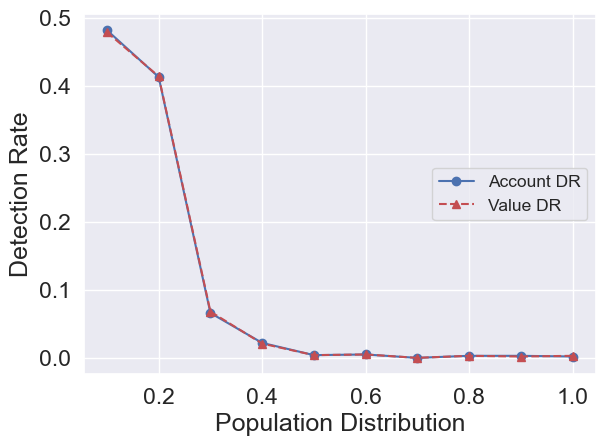

plot_ADR_Quantile took 0.24 seconds


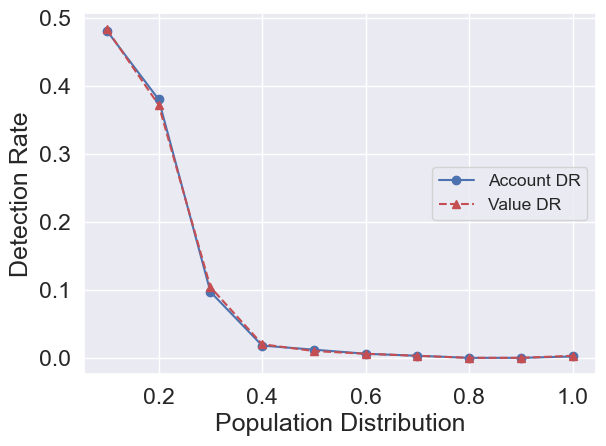

plot_ADR_Quantile took 0.2 seconds


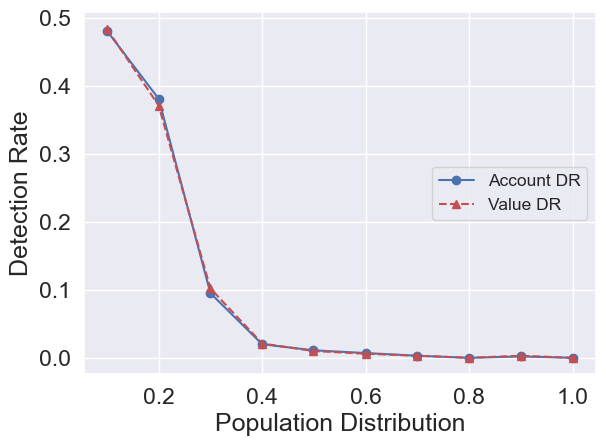

plot_ADR_Quantile took 0.23 seconds


In [45]:
ev.plot_ADR_Quantile(lt_rf_iterative)
ev.plot_ADR_Quantile(lt_rf_fixed)
ev.plot_ADR_Quantile(lt_rf_random)

### Plot RF Cum. Detection rate vs. Population Distribution (Gains chart)

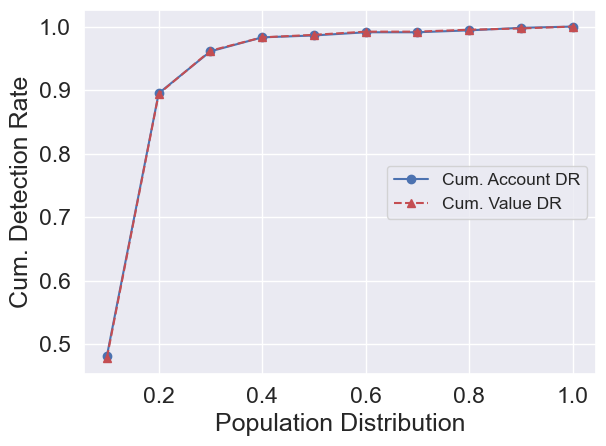

plot_cADR_Quantile took 0.22 seconds


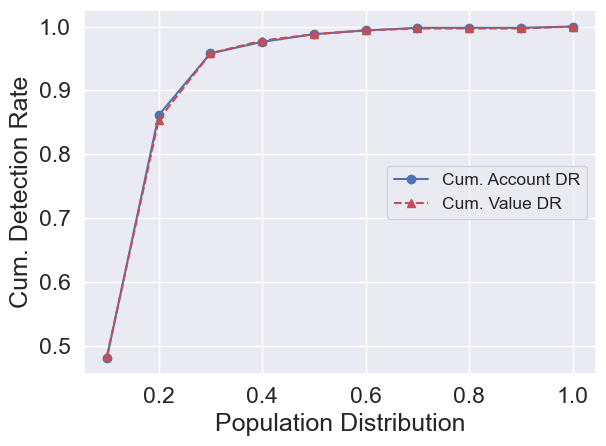

plot_cADR_Quantile took 0.22 seconds


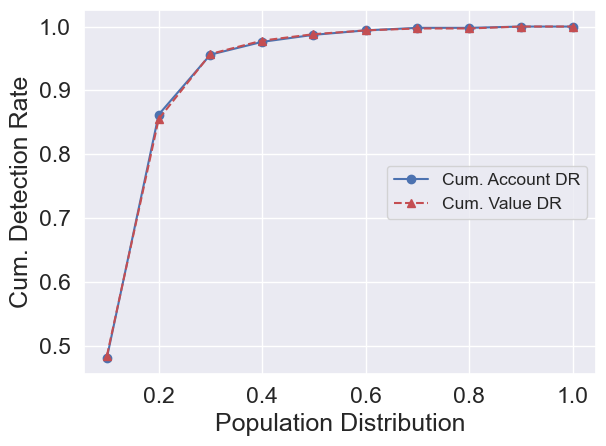

plot_cADR_Quantile took 0.19 seconds


In [46]:
ev.plot_cADR_Quantile(lt_rf_iterative)
ev.plot_cADR_Quantile(lt_rf_fixed)
ev.plot_cADR_Quantile(lt_rf_random)

### Plot RF FPR vs. Population Distribution

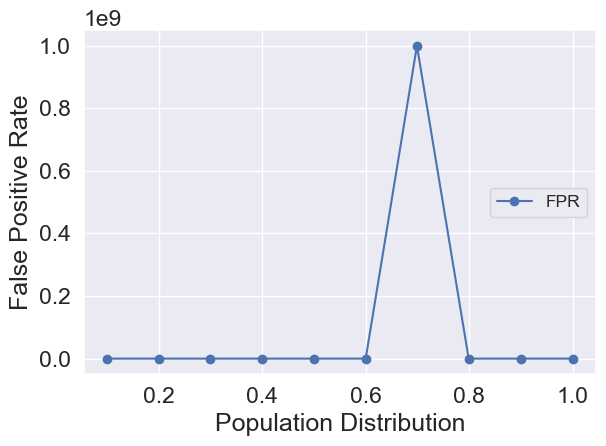

plot_FPR_Quantile took 0.19 seconds


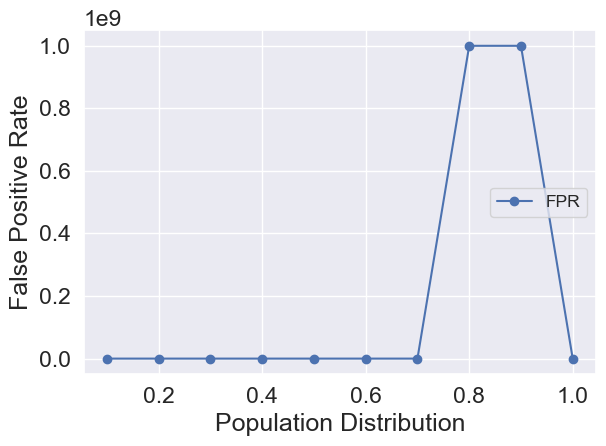

plot_FPR_Quantile took 0.2 seconds


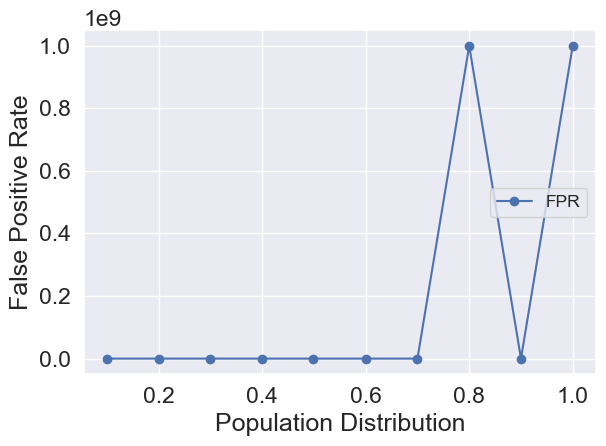

plot_FPR_Quantile took 0.22 seconds


In [47]:
ev.plot_FPR_Quantile(lt_rf_iterative)
ev.plot_FPR_Quantile(lt_rf_fixed)
ev.plot_FPR_Quantile(lt_rf_random)

### Plot RF Cum. FPR vs. Population Distribution

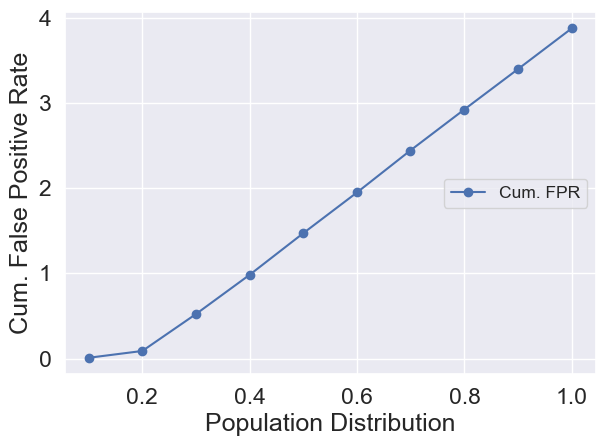

plot_cFPR_Quantile took 0.19 seconds


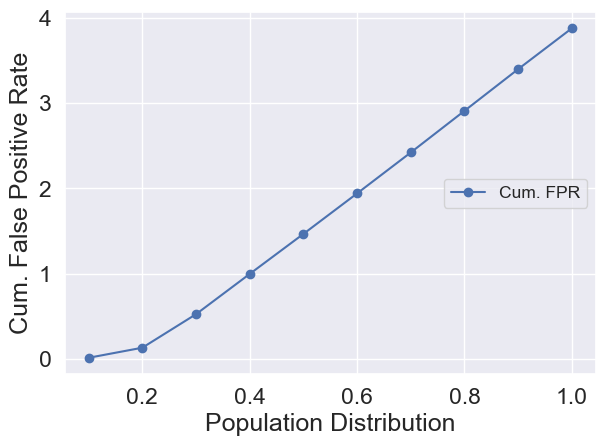

plot_cFPR_Quantile took 0.2 seconds


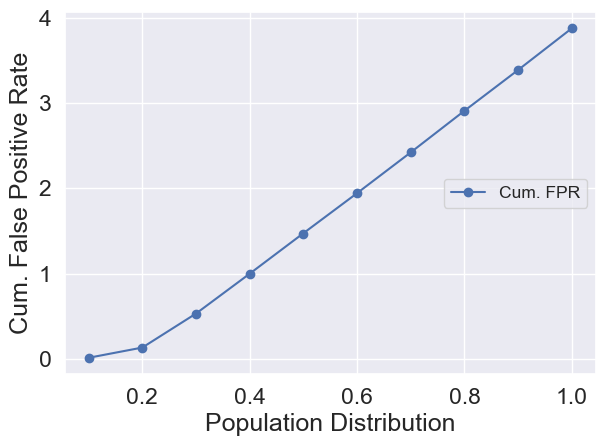

plot_cFPR_Quantile took 0.2 seconds


In [48]:
ev.plot_cFPR_Quantile(lt_rf_iterative)
ev.plot_cFPR_Quantile(lt_rf_fixed)
ev.plot_cFPR_Quantile(lt_rf_random)

### Plot RF ROC curve

Random: ROC AUC=0.500
Model: ROC AUC=0.980


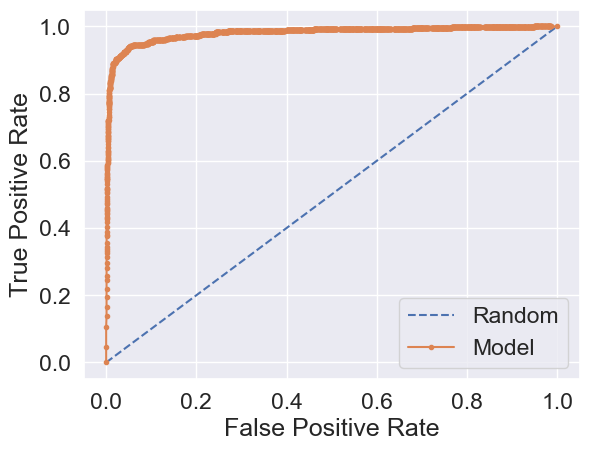

plot_ROC_curve took 0.22 seconds
Random: ROC AUC=0.500
Model: ROC AUC=0.977


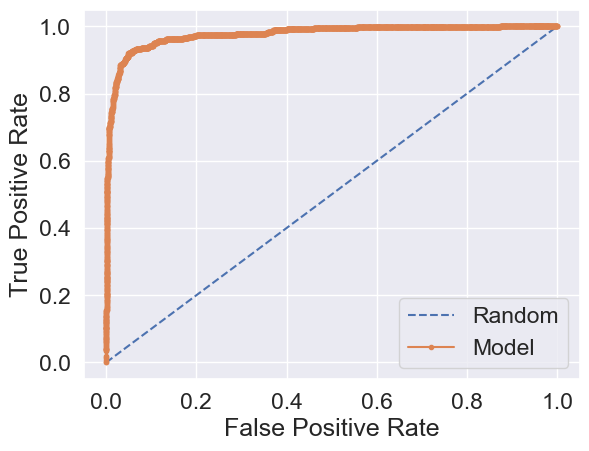

plot_ROC_curve took 0.19 seconds
Random: ROC AUC=0.500
Model: ROC AUC=0.977


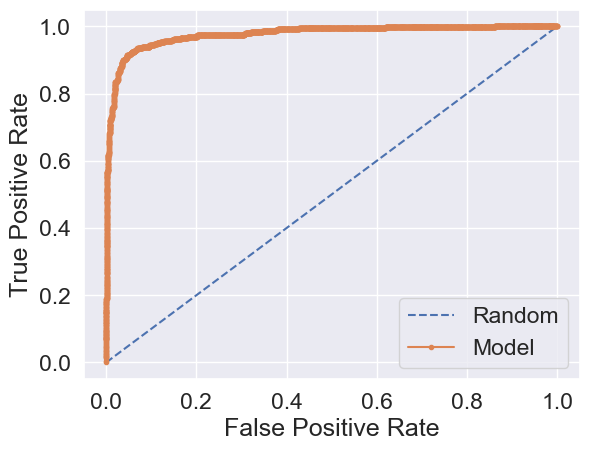

plot_ROC_curve took 0.24 seconds


In [49]:
ev.plot_ROC_curve(table_name=data['data_{}'.format(sample_values_solution[1])], target_variable=target_variable_name, predicted_variable='rf_score_iterative', weight_variable=weight_variable_name) 
ev.plot_ROC_curve(table_name=data['data_{}'.format(sample_values_solution[1])], target_variable=target_variable_name, predicted_variable='rf_score_fixed', weight_variable=weight_variable_name) 
ev.plot_ROC_curve(table_name=data['data_{}'.format(sample_values_solution[1])], target_variable=target_variable_name, predicted_variable='rf_score_random', weight_variable=weight_variable_name) 

### Plot RF Precision Recall curve

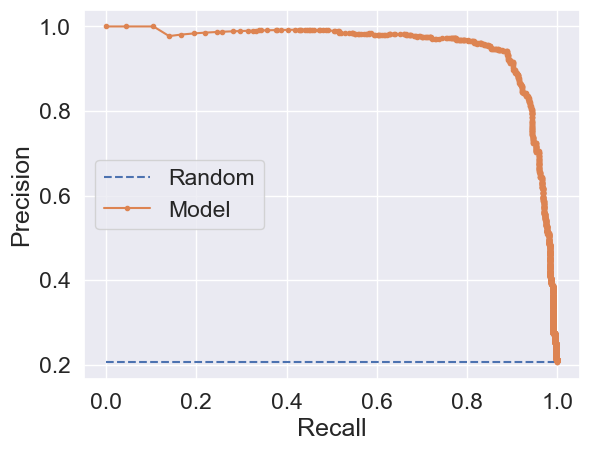

plot_precision_recall_curve took 0.19 seconds


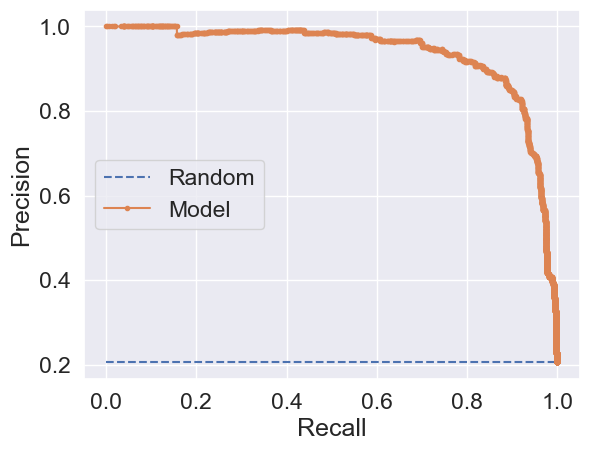

plot_precision_recall_curve took 0.18 seconds


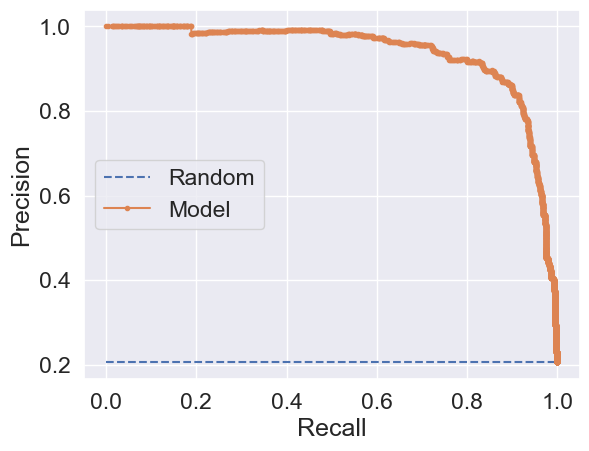

plot_precision_recall_curve took 0.2 seconds


In [50]:
ev.plot_precision_recall_curve(table_name=data['data_{}'.format(sample_values_solution[1])], target_variable=target_variable_name, predicted_variable='rf_score_iterative', 
                            weight_variable=weight_variable_name)
ev.plot_precision_recall_curve(table_name=data['data_{}'.format(sample_values_solution[1])], target_variable=target_variable_name, predicted_variable='rf_score_fixed', 
                            weight_variable=weight_variable_name)
ev.plot_precision_recall_curve(table_name=data['data_{}'.format(sample_values_solution[1])], target_variable=target_variable_name, predicted_variable='rf_score_random', 
                            weight_variable=weight_variable_name)  

### Plot RF F1 score, Accuracy, Sensitivity, Specificity, Precision vs Cutoff

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\evaluation.py:575: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  


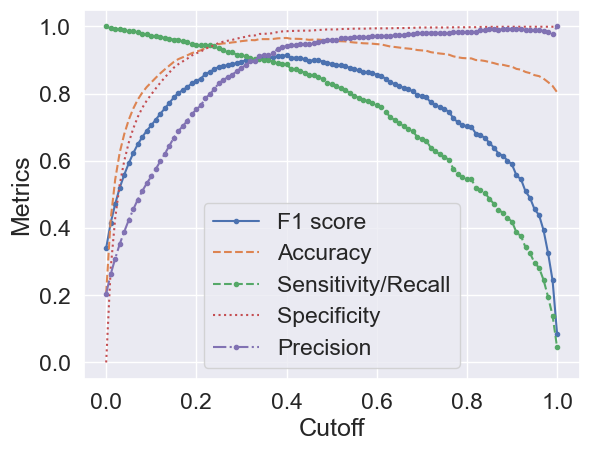

plot_cutoffs took 0.54 seconds


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\evaluation.py:575: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  
C:\Users\creep\Anaconda\Sotiris_Solutions\functions\evaluation.py:571: RuntimeWarning: invalid value encountered in double_scalars
  if sys.version_info[0] < 2:


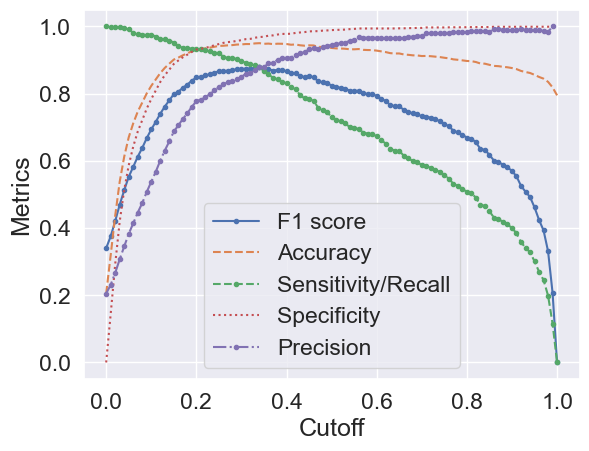

plot_cutoffs took 0.51 seconds


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\evaluation.py:575: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  
C:\Users\creep\Anaconda\Sotiris_Solutions\functions\evaluation.py:571: RuntimeWarning: invalid value encountered in double_scalars
  if sys.version_info[0] < 2:


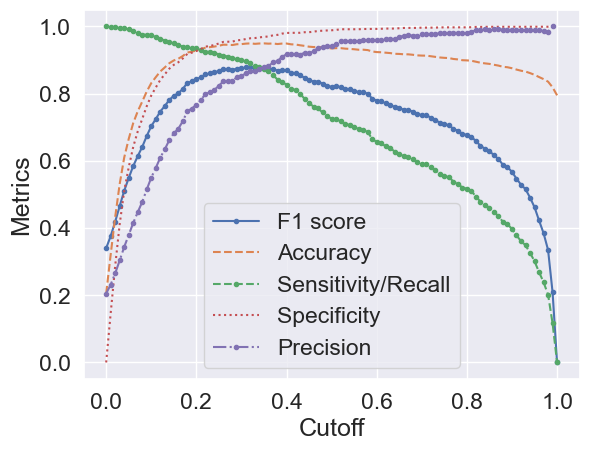

plot_cutoffs took 0.55 seconds


In [71]:
ev.plot_cutoffs(table_name=data['data_{}'.format(sample_values_solution[1])], target_variable=target_variable_name, predicted_variable='rf_score_iterative', 
                            weight_variable=weight_variable_name, n_bands=100, return_table=False)
ev.plot_cutoffs(table_name=data['data_{}'.format(sample_values_solution[1])], target_variable=target_variable_name, predicted_variable='rf_score_fixed', 
                            weight_variable=weight_variable_name, n_bands=100, return_table=False)
ev.plot_cutoffs(table_name=data['data_{}'.format(sample_values_solution[1])], target_variable=target_variable_name, predicted_variable='rf_score_random', 
                            weight_variable=weight_variable_name, n_bands=100, return_table=False)

# Random Forest with H2O

In [77]:
# Load the data
import h2o 
h2o.init(nthreads=8, max_mem_size=12)

# load pandas dataframe into H2O dataframe
dev_h2o = h2o.H2OFrame(data['data_{}'.format(sample_values_solution[0])])
oos_h2o = h2o.H2OFrame(data['data_{}'.format(sample_values_solution[1])])

# Define response variable to be categorical for classification model.
dev_h2o[target_variable_name]=dev_h2o[target_variable_name].asfactor()
oos_h2o[target_variable_name]=oos_h2o[target_variable_name].asfactor()

ModuleNotFoundError: No module named 'h2o'

## Feature selection RF H2O

In [ ]:
# Provide input data to feature selection class
select = fs.SelectBest_weight(df=data['data_{}'.format(sample_values_solution[0])], target=target_variable_name, weight=weight_variable_name)

In [ ]:
# Select top features to apply a first screening
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier(n_estimators=200, max_depth=5, random_state=1234, n_jobs=6)
rf_importance, feats_best_rf = select.top_rf_feat(feats=keep_num_vars_gini, model=model_rf, n=30)
print('The top Random Forest features are: \n', feats_best_rf)
rf_importance

In [ ]:
import timeit
start = timeit.default_timer()

# Backward selection with random forest model: In each step a feature is selected to remove - this removal maximizes Gini
feats_best_rf_back = select.backward_recur(feats=feats_best_rf, oos=data['data_{}'.format(sample_values_solution[1])], model=model_rf, min_feats=25, classification=True)
print(feats_best_rf_back)

stop = timeit.default_timer()
print('Execution time in seconds: ', stop - start)  
# Execution time in seconds:  84.96231860000003

## Grid search and train RF machine learning model

### Grid search based on iterative step

In [ ]:
# Hyperparameter tuning: The process works as follows:
# 1) Iterate n_estimators (grid) for the fixed values of max_depth and max_features (params). Select the value of n_estimators that minimizes the loss function. 
# 2) Keep the n_estimators value from the previous step. Iterate max_depth (grid) for the fixed value of max_features (params). Select the value of max_depth that minimizes the loss function. 
# 3) Keep the max_depth value from the previous step. Iterate max_features (grid). Select the value of max_features that minimizes the loss function. 
import timeit
start = timeit.default_timer()

import math
# 18 models in total
grid = {'n_estimators':[10, 50, 80, 100, 200, 400],  # Number of trees, 100-500 is usually sufficient /
       'max_depth':[2, 5, 10, 20],  # Depth of the tree, 5-6 is usually default
       'max_features':[*range(1,len(feats_best_rf_back),math.ceil(len(feats_best_rf_back)/5))],  # Number of variables randomly sampled as candidates at each split, sqrt(p) is usually the default
       'min_samples_leaf': [1, 10, 100]} # Minimum number of observations in each leaf, 10 is usually default

params = {'n_estimators': 100, 'max_depth':10, 'max_features':math.ceil(math.sqrt(len(feats_best_rf_back))), 'min_samples_leaf':10}

opt_params_iterative, loss = mb.step_search_weight(estimator=RandomForestClassifier, params=params, grid=grid, target=target_variable_name, 
                                  weight=weight_variable_name, dev=data['data_{}'.format(sample_values_solution[0])], val=data['data_{}'.format(sample_values_solution[1])], keep=feats_best_rf_back)
print('\n Best Parameters')
print(opt_params_iterative)
print(loss)

# Load RF machine leanring library
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals import joblib

# Define the random forest model
rf = RandomForestClassifier(n_estimators=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='n_estimators'][0], 
                            max_depth=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='max_depth'][0], 
                            max_features=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='max_features'][0], 
                            min_samples_leaf=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='min_samples_leaf'][0], 
                            random_state=0)

# Train the model
rf_model = mb.fit_model_weight(data['data_{}'.format(sample_values_solution[0])], feats_best_rf_back, target_variable_name, weight_variable_name, rf, 'rf_iterative.pkl')

# Compute the score for the OOT data
data['data_{}'.format(sample_values_solution[1])]['rf_score_iterative'] = rf_model.predict_proba(data['data_{}'.format(sample_values_solution[1])][feats_best_rf_back].values)[:, 1]

stop = timeit.default_timer()
print('Execution time in seconds: ', stop - start)  
#Execution time in seconds:  4.643848800000001

### Grid search based on H2O random grid space

In [ ]:
import timeit
start = timeit.default_timer()

# Hyperparameter tuning using H2O random grid space: - NOTE: THIS TAKES 5 MINUTES TO RUN!
from h2o.grid.grid_search import H2OGridSearch
from h2o.estimators import H2ORandomForestEstimator
import math

# RF hyperparameters
# 1,440 models in total
grid_h2o_random = {'ntrees': [i*50 for i in range(1, 10)], # Number of trees, 100-500 is usually sufficient
                'max_depth': list(range(2, 20, 3)), # Depth of the tree, 5-6 is usually default
                'mtries': [i*2 for i in range(1, math.ceil(len(feats_best_rf_back)/2))], # Number of variables randomly sampled as candidates at each split, sqrt(p) is usually the default
                'min_rows': [1, 10, 100], # Minimum number of observations in each leaf, 10 is usually default
                'nbins': [20, 30], #For numerical columns (real/int), build a histogram of (at least) this many bins, then split at the best point, 30 is usually default
                'nbins_cats': [10, 15], # For categorical columns (factors), build a histogram of this many bins, then split at the best point. Higher values can lead to more overfitting, 10-20 is usally default
                'sample_rate': [0.63], # Row sample rate per tree (from 0.0 to 1.0), 0.63 is usually default
                'col_sample_rate_per_tree': [1]} # Column sample rate per tree (from 0.0 to 1.0), 1 is usually default

# Search criteria
search_criteria = {'strategy': 'RandomDiscrete', 'max_models': 10, 'seed': 1}

# Train and validate a random grid of RFs
rf_h2o_grid_random = H2OGridSearch(model=H2ORandomForestEstimator,
                          grid_id='rf_h2o_grid_random',
                          hyper_params=grid_h2o_random,
                          search_criteria=search_criteria)

rf_h2o_grid_random.train(x=feats_best_rf_back, y=target_variable_name, training_frame=dev_h2o, validation_frame=oos_h2o, 
                         weights_column=weight_variable_name, seed=1, nfolds=0)

stop = timeit.default_timer()
print('Execution time in seconds: ', stop - start)  
# Execution time in seconds:  53.19511840000001

# Get the grid results, sorted by validation logloss
rf_h2o_grid_random_perf = rf_h2o_grid_random.get_grid(sort_by='logloss', decreasing=False)
print(rf_h2o_grid_random_perf)

In [ ]:
# Build random forest model in H2O, based on the H2O random grid search. Grab the best model.
rf_h2o_random = rf_h2o_grid_random_perf.models[0]

# Check the random forest model performance on the OOT sample
rf_h2o_model_performance = rf_h2o_random.model_performance(oos_h2o)
print(rf_h2o_model_performance)
print('Gini for the OOT sample is: ', 2*rf_h2o_model_performance.auc()-1)

# Check the variable importance 
var_imp=[(x[0],x[2]) for x in rf_h2o_random.varimp()]
for v1, v2 in var_imp:
    print (v1,v2)
    
# Get probability score for test dataset
oos_h2o['rf_h2o_score_random'] = rf_h2o_random.predict(oos_h2o)[2]

### Grid search based on H2O fixed grid space

In [ ]:
# Hyperparameter tuning using H2O fixed grid space: - NOTE: THIS TAKES SEVERAL MINUTES TO RUN!
import timeit
start = timeit.default_timer()

from h2o.grid.grid_search import H2OGridSearch
from h2o.estimators import H2ORandomForestEstimator
import math

# 27 models in total
grid_h2o_fixed = {'ntrees':[50, 100, 200],  # Number of trees, 100-500 is usually sufficient
       'max_depth':[8, 10, 12],  # Depth of the tree, 5-6 is usually default
       'mtries':[14, 16, 18],  # Number of variables randomly sampled as candidates at each split, sqrt(p) is usually the default
        'min_rows': [10],  # Minimum number of observations in each leaf, 10 is usually default
        'nbins': [30],  #For numerical columns (real/int), build a histogram of (at least) this many bins, then split at the best point, 30 is usually default
        'nbins_cats': [15],  # For categorical columns (factors), build a histogram of this many bins, then split at the best point. Higher values can lead to more overfitting, 10-20 is usally default
        'sample_rate': [0.63],  # Row sample rate per tree (from 0.0 to 1.0), 0.63 is usually default
        'col_sample_rate_per_tree': [1]} # Column sample rate per tree (from 0.0 to 1.0), 1 is usually default

# Train and validate a cartesian grid of RFs
rf_h2o_grid_fixed = H2OGridSearch(model=H2ORandomForestEstimator,
                          grid_id='rf_h2o_grid_fixed',
                          hyper_params=grid_h2o_fixed)

rf_h2o_grid_fixed.train(x=feats_best_rf_back, y=target_variable_name, training_frame=dev_h2o, validation_frame=oos_h2o, 
                        weights_column=weight_variable_name, seed=1, nfolds=0)

stop = timeit.default_timer()
print('Execution time in seconds: ', stop - start)  
# Execution time in seconds:  93.57661189999999

# Get the grid results, sorted by validation logloss
rf_h2o_grid_fixed_perf = rf_h2o_grid_fixed.get_grid(sort_by='logloss', decreasing=False)
print(rf_h2o_grid_fixed_perf)

In [ ]:
# Build fixed forest model in H2O, based on the H2O fixed grid search. Grab the best model.
rf_h2o_fixed = rf_h2o_grid_fixed_perf.models[0]

# Check the random forest model performance on the OOT sample
rf_h2o_model_performance = rf_h2o_fixed.model_performance(oos_h2o)
print(rf_h2o_model_performance)
print('Gini for the OOT sample is: ', 2*rf_h2o_model_performance.auc()-1)

# Check the variable importance 
var_imp=[(x[0],x[2]) for x in rf_h2o_fixed.varimp()]
for v1, v2 in var_imp:
    print (v1,v2)
    
# Get probability score for test dataset
oos_h2o['rf_h2o_score_fixed'] = rf_h2o_fixed.predict(oos_h2o)[2]

In [ ]:
# Convert H2O dataframe to pandas dataframe
data['data_{}'.format(sample_values_solution[1])]=oos_h2o.as_data_frame(use_pandas=True)

## Calculate H2O RF log-loss

In [ ]:
from sklearn.metrics import log_loss
print ("log-loss_iterative")
print(log_loss(y_true=data['data_{}'.format(sample_values_solution[1])][target_variable_name].values, y_pred=data['data_{}'.format(sample_values_solution[1])]['rf_score_iterative'].values, sample_weight=data['data_{}'.format(sample_values_solution[1])][weight_variable_name].values, eps=1e-15))
print ("log-loss_fixed")
print(log_loss(y_true=data['data_{}'.format(sample_values_solution[1])][target_variable_name].values, y_pred=data['data_{}'.format(sample_values_solution[1])]['rf_h2o_score_fixed'].values, sample_weight=data['data_{}'.format(sample_values_solution[1])][weight_variable_name].values, eps=1e-15))
print ("log-loss_random")
print(log_loss(y_true=data['data_{}'.format(sample_values_solution[1])][target_variable_name].values, y_pred=data['data_{}'.format(sample_values_solution[1])]['rf_h2o_score_random'].values, sample_weight=data['data_{}'.format(sample_values_solution[1])][weight_variable_name].values, eps=1e-15))

## Calculate H2O RF Precision/Recall Area Under the Curve

In [ ]:
print ("precision_recall_auc_iterative")
print(ev.auc_precision_recall(table_name=data['data_{}'.format(sample_values_solution[1])], target_variable=target_variable_name, predicted_variable='rf_score_iterative', 
                            weight_variable=weight_variable_name))
print ("precision_recall_auc_fixed")
print(ev.auc_precision_recall(table_name=data['data_{}'.format(sample_values_solution[1])], target_variable=target_variable_name, predicted_variable='rf_h2o_score_fixed', 
                            weight_variable=weight_variable_name))
print ("precision_recall_auc_random")
print(ev.auc_precision_recall(table_name=data['data_{}'.format(sample_values_solution[1])], target_variable=target_variable_name, predicted_variable='rf_h2o_score_random', 
                            weight_variable=weight_variable_name))

## Calculate H2O RF Gini, for the top population

In [ ]:
print ("unit_gini_iterative")
print(ev.calculate_gini(
    table_name=data['data_{}'.format(sample_values_solution[1])], # Table name
    target_variable=target_variable_name, # Target variable name
    predicted_variable='rf_score_iterative', # Predicted variable name
    weight_variable=weight_variable_name, # Weight variable name
    select_top_percent=100 # Percent between 0 and 100: Gini is calculated for the top select_top_percent% of the observations, sorted by score
    ))
print ("unit_gini_fixed")
print(ev.calculate_gini(
    table_name=data['data_{}'.format(sample_values_solution[1])], # Table name
    target_variable=target_variable_name, # Target variable name
    predicted_variable='rf_h2o_score_fixed', # Predicted variable name
    weight_variable=weight_variable_name, # Weight variable name
    select_top_percent=100 # Percent between 0 and 100: Gini is calculated for the top select_top_percent% of the observations, sorted by score
    ))
print ("unit_gini_random")
print(ev.calculate_gini(
    table_name=data['data_{}'.format(sample_values_solution[1])], # Table name
    target_variable=target_variable_name, # Target variable name
    predicted_variable='rf_h2o_score_random', # Predicted variable name
    weight_variable=weight_variable_name, # Weight variable name
    select_top_percent=100 # Percent between 0 and 100: Gini is calculated for the top select_top_percent% of the observations, sorted by score
    ))

## Calculate H2O RF Lifting table

In [ ]:
# Lifting table
lt_rf_h2o_iterative = ev.lift_table_weight(data['data_{}'.format(sample_values_solution[1])][['rf_score_iterative', target_variable_name, amount_variable_name, weight_variable_name]].values, n_bands=10, rows=10).round(decimals=3)
lt_rf_h2o_fixed = ev.lift_table_weight(data['data_{}'.format(sample_values_solution[1])][['rf_h2o_score_fixed', target_variable_name, amount_variable_name, weight_variable_name]].values, n_bands=10, rows=10).round(decimals=3)
lt_rf_h2o_random = ev.lift_table_weight(data['data_{}'.format(sample_values_solution[1])][['rf_h2o_score_random', target_variable_name, amount_variable_name, weight_variable_name]].values, n_bands=10, rows=10).round(decimals=3)
lt_rf_h2o_random

## Plots RF H2O

### Plot RF H2O Detection rate vs. Population Distribution

In [ ]:
ev.plot_ADR_Quantile(lt_rf_h2o_iterative)
ev.plot_ADR_Quantile(lt_rf_h2o_fixed)
ev.plot_ADR_Quantile(lt_rf_h2o_random)

### Plot RF H2O Cum. Detection rate vs. Population Distribution (Gains chart)

In [ ]:
ev.plot_cADR_Quantile(lt_rf_h2o_iterative)
ev.plot_cADR_Quantile(lt_rf_h2o_fixed)
ev.plot_cADR_Quantile(lt_rf_h2o_random)

### Plot RF H2O FPR vs. Population Distribution

In [ ]:
ev.plot_FPR_Quantile(lt_rf_h2o_iterative)
ev.plot_FPR_Quantile(lt_rf_h2o_fixed)
ev.plot_FPR_Quantile(lt_rf_h2o_random)

### Plot RF H2O Cum. FPR vs. Population Distribution

In [ ]:
ev.plot_cFPR_Quantile(lt_rf_h2o_iterative)
ev.plot_cFPR_Quantile(lt_rf_h2o_fixed)
ev.plot_cFPR_Quantile(lt_rf_h2o_random)

### Plot RF H2O ROC curve

In [ ]:
ev.plot_ROC_curve(table_name=data['data_{}'.format(sample_values_solution[1])], target_variable=target_variable_name, predicted_variable='rf_score_iterative', weight_variable=weight_variable_name) 
ev.plot_ROC_curve(table_name=data['data_{}'.format(sample_values_solution[1])], target_variable=target_variable_name, predicted_variable='rf_h2o_score_fixed', weight_variable=weight_variable_name) 
ev.plot_ROC_curve(table_name=data['data_{}'.format(sample_values_solution[1])], target_variable=target_variable_name, predicted_variable='rf_h2o_score_random', weight_variable=weight_variable_name) 

### Plot RF H2O Precision Recall curve

In [ ]:
ev.plot_precision_recall_curve(table_name=data['data_{}'.format(sample_values_solution[1])], target_variable=target_variable_name, predicted_variable='rf_score_iterative', 
                            weight_variable=weight_variable_name)
ev.plot_precision_recall_curve(table_name=data['data_{}'.format(sample_values_solution[1])], target_variable=target_variable_name, predicted_variable='rf_h2o_score_fixed', 
                            weight_variable=weight_variable_name)
ev.plot_precision_recall_curve(table_name=data['data_{}'.format(sample_values_solution[1])], target_variable=target_variable_name, predicted_variable='rf_h2o_score_random', 
                            weight_variable=weight_variable_name)  

### Plot RF H2O F1 score, Accuracy, Sensitivity, Specificity, Precision vs Cutoff

In [ ]:
ev.plot_cutoffs(table_name=data['data_{}'.format(sample_values_solution[1])], target_variable=target_variable_name, predicted_variable='rf_score_iterative', 
                            weight_variable=weight_variable_name, n_bands=100, return_table=False)
ev.plot_cutoffs(table_name=data['data_{}'.format(sample_values_solution[1])], target_variable=target_variable_name, predicted_variable='rf_h2o_score_fixed', 
                            weight_variable=weight_variable_name, n_bands=100, return_table=False)
ev.plot_cutoffs(table_name=data['data_{}'.format(sample_values_solution[1])], target_variable=target_variable_name, predicted_variable='rf_h2o_score_random', 
                            weight_variable=weight_variable_name, n_bands=100, return_table=False)

## Save model and export MOJO file

In [ ]:
# Save already trained model for future use
model_path=h2o.save_model(model=rf_h2o_fixed, path='{}/output/rf_h2o_grid_model'.format(input_data_path), force=True)

In [ ]:
# Save mojo file, which helps deploy the train model
rf_h2o_fixed.download_mojo(path='{}/output/model.zip'.format(input_data_path))

In [ ]:
h2o.cluster().shutdown()

# Gradient Boosting Machine

## Feature selection GBM

In [79]:
# Provide input data to feature selection class
select = fs.SelectBest_weight(df=data['data_{}'.format(sample_values_solution[0])], target=target_variable_name, weight=weight_variable_name)

In [80]:
# Select top features to apply a first screening
from sklearn.ensemble import GradientBoostingClassifier
model_gbm = GradientBoostingClassifier(n_estimators=200, max_depth=5, learning_rate=0.1, random_state=1234)
gbm_importance, feats_best_gbm = select.top_gbm_feat(feats=keep_num_vars_gini, model=model_gbm, n=15)
print('The top GBM features are: \n', feats_best_gbm)
gbm_importance

The top GBM features are: 
 ['random_var_7', 'random_var_15', 'random_var_19', 'random_var_10', 'random_var_11', 'random_var_5', 'random_var_16', 'random_var_3', 'random_var_8', 'random_var_9', 'random_var_6', 'random_var_13', 'random_var_17', 'random_var_1', 'num_20%']


[('random_var_7', 0.23105870501585166),
 ('random_var_15', 0.15809146379971328),
 ('random_var_19', 0.11517984926130273),
 ('random_var_10', 0.09341007526205865),
 ('random_var_11', 0.07728053140410815),
 ('random_var_5', 0.054295400050377765),
 ('random_var_16', 0.046133652061043785),
 ('random_var_3', 0.04115860135453419),
 ('random_var_8', 0.03823825228296825),
 ('random_var_9', 0.029557135694015777),
 ('random_var_6', 0.027485605119471918),
 ('random_var_13', 0.025901746533702148),
 ('random_var_17', 0.02488519063064502),
 ('random_var_1', 0.01534480800234682),
 ('num_20%', 0.0045794110000057005),
 ('random_var_12', 0.003277500052584601),
 ('random_var_18', 0.0032582715987555656),
 ('random_var_2', 0.002790115893134384),
 ('num_2%', 0.0026787105997525705),
 ('random_var_14', 0.0021287166244680256),
 ('random_var_0', 0.0015643980707232324),
 ('random_var_4', 0.0013065645608049724),
 ('cat_3_2', 0.00019776616993667743),
 ('cat_3_3', 0.0001975289576941283)]

In [81]:
# Backward selection with gradient boosting machine model: In each step a feature is selected to remove - this removal maximizes Gini
feats_best_gbm_back = select.backward_recur(feats=feats_best_gbm, oos=data['data_{}'.format(sample_values_solution[1])], model=model_gbm, min_feats=10, classification=True)
print(feats_best_gbm_back)

C:\Data_Science\Miniconda\envs\Unsupervised_Modeling\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
C:\Users\creep\Anaconda\Sotiris_Solutions\functions\feature_selection.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oos['score']=model.predict_proba(oos[left].values)[:, 1]
C:\Data_Science\Miniconda\envs\Unsupervised_Modeling\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
C:\Users\creep\Anaconda\Sotiris_Solutions\functions\feature_selection.py:304: SettingWithCopyWarning: 
A value is trying to be set on a

step i = 1 feature removed: num_20% gini: 0.9732289772125258


C:\Data_Science\Miniconda\envs\Unsupervised_Modeling\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
C:\Users\creep\Anaconda\Sotiris_Solutions\functions\feature_selection.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oos['score']=model.predict_proba(oos[left].values)[:, 1]
C:\Data_Science\Miniconda\envs\Unsupervised_Modeling\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
C:\Users\creep\Anaconda\Sotiris_Solutions\functions\feature_selection.py:304: SettingWithCopyWarning: 
A value is trying to be set on a

step i = 2 feature removed: random_var_19 gini: 0.9747626125862849


C:\Data_Science\Miniconda\envs\Unsupervised_Modeling\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
C:\Users\creep\Anaconda\Sotiris_Solutions\functions\feature_selection.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oos['score']=model.predict_proba(oos[left].values)[:, 1]
C:\Data_Science\Miniconda\envs\Unsupervised_Modeling\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
C:\Users\creep\Anaconda\Sotiris_Solutions\functions\feature_selection.py:304: SettingWithCopyWarning: 
A value is trying to be set on a

step i = 3 feature removed: random_var_16 gini: 0.971739054443679


C:\Data_Science\Miniconda\envs\Unsupervised_Modeling\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
C:\Users\creep\Anaconda\Sotiris_Solutions\functions\feature_selection.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oos['score']=model.predict_proba(oos[left].values)[:, 1]
C:\Data_Science\Miniconda\envs\Unsupervised_Modeling\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
C:\Users\creep\Anaconda\Sotiris_Solutions\functions\feature_selection.py:304: SettingWithCopyWarning: 
A value is trying to be set on a

step i = 4 feature removed: random_var_3 gini: 0.9687559708078313


C:\Data_Science\Miniconda\envs\Unsupervised_Modeling\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
C:\Users\creep\Anaconda\Sotiris_Solutions\functions\feature_selection.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oos['score']=model.predict_proba(oos[left].values)[:, 1]
C:\Data_Science\Miniconda\envs\Unsupervised_Modeling\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
C:\Users\creep\Anaconda\Sotiris_Solutions\functions\feature_selection.py:304: SettingWithCopyWarning: 
A value is trying to be set on a

step i = 5 feature removed: random_var_9 gini: 0.9621981155111672
backward_recur took 1024.14 seconds
['random_var_7', 'random_var_15', 'random_var_10', 'random_var_11', 'random_var_5', 'random_var_8', 'random_var_6', 'random_var_13', 'random_var_17', 'random_var_1']
Execution time in seconds:  1024.1305580000044


C:\Data_Science\Miniconda\envs\Unsupervised_Modeling\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
C:\Users\creep\Anaconda\Sotiris_Solutions\functions\feature_selection.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oos['score']=model.predict_proba(oos[left].values)[:, 1]


## Grid search and train GBM machine learning model

### Grid search based on iterative step search

In [88]:
# Hyperparameter tuning: The process works as follows:
# 1) Iterate n_estimators (grid) for the fixed values of max_depth, max_features, and learning_rate (params). Select the value of n_estimators that minimizes the loss function. 
# 2) Keep the n_estimators value from the previous step. Iterate max_depth (grid) for the fixed value of max_features, learning_rate (params). Select the value of max_depth that minimizes the loss function. 
# 3) Keep the max_depth value from the previous step. Iterate max_features (grid) for the fixed value of learning_rate (params). Select the value of max_features that minimizes the loss function. 
# 4) Keep the max_features value from the previous step. Iterate learning_rate (grid). Select the value of learning_rate that minimizes the loss function. 
import timeit
start = timeit.default_timer()

# 40 models in total
grid = {'n_estimators':[10, 20, 50, 100, 200], # Number of trees, 100-500 is usually sufficient
       'max_depth':[2, 5, 10], # Depth of the tree, 5-6 is usually default
        "max_features":["log2","sqrt"], # Number of variables randomly sampled as candidates at each split, sqrt(p) is usually the default
#       'max_features':[*range(1,len(feats_best_gbm_back),math.ceil(len(feats_best_gbm_back)/5))], \
       'learning_rate':[0.05, 0.1, 0.2, 0.5], # Learing rate. Shrinkage is used for reducing, or shrinking, the impact of each additional fitted 
# base-learner (tree). It reduces the size of incremental steps and thus penalizes the importance of each consecutive iteration. 
# The intuition behind this technique is that it is better to improve a model by taking many small steps than by taking fewer large steps. 
# If one of the boosting iterations turns out to be erroneous, its negative impact can be easily corrected in subsequent steps. 
# High learn rates and especially values close to 1.0 typically result in overfit models with poor performance. 
# Values much smaller than .01 significantly slow down the learning process and might be reserved for overnight runs. 0.10 default
        "min_samples_leaf": np.linspace(0.01, 0.4, 10), # Minimum number of observations in each leaf, 10 is usually default
        "min_samples_split": np.linspace(0.01, 0.4, 10), # The minimum number of observations required to split an internal node
        # If int then min_samples_split is the minimum number of observations
        # If float then then minimum number of observations is a fraction and ceil(min_samples_split * n_samples) 
        "subsample":[0.5, 0.7, 0.8, 0.9, 0.95, 1.0], # The fraction of samples from n_estimators
        "criterion": ["friedman_mse",  "squared_error"] # The function to measure the quality of a split
#        , "loss":["deviance"]      
       }

params = {'n_estimators': 100, 'max_depth':4, 'max_features':"sqrt", 'learning_rate':0.1, "min_samples_leaf":0.2, "min_samples_split": 0.2, \
         "subsample":0.8, "criterion":"friedman_mse"
         # , "loss":["deviance"]
         }            

opt_params_iterative, loss = mb.step_search_weight(estimator=GradientBoostingClassifier, params=params, grid=grid, target=target_variable_name, 
                                  weight=weight_variable_name, dev=data['data_{}'.format(sample_values_solution[0])], val=data['data_{}'.format(sample_values_solution[1])], keep=feats_best_gbm_back)
print('\n Best Parameters')
print(opt_params_iterative)
print(loss)

# Load GBM algorithm
from sklearn.ensemble import GradientBoostingClassifier

# Define the GBM model
gbm = GradientBoostingClassifier(n_estimators=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='n_estimators'][0], 
                                 max_depth=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='max_depth'][0], 
                                 max_features=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='max_features'][0], 
                                 learning_rate=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='learning_rate'][0], 
                                 min_samples_leaf=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='min_samples_leaf'][0], 
                                 min_samples_split=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='min_samples_split'][0], 
                                 subsample=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='subsample'][0], 
                                 criterion=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='criterion'][0],                                 
                                 random_state=0)

# Train the model
gbm_model = mb.fit_model_weight(data['data_{}'.format(sample_values_solution[0])], feats_best_gbm_back, target_variable_name, weight_variable_name, gbm, 'gbm_iterative.pkl')

# Compute the score for the OOT data
data['data_{}'.format(sample_values_solution[1])]['gbm_score_iterative'] = gbm_model.predict_proba(data['data_{}'.format(sample_values_solution[1])][feats_best_gbm_back].values)[:, 1]

stop = timeit.default_timer()
print('Execution time in seconds: ', stop - start)  
#Execution time in seconds:  52.360631900000044

Search Progress:
{'n_estimators': 10, 'max_depth': 4, 'max_features': 'sqrt', 'learning_rate': 0.1, 'min_samples_leaf': 0.2, 'min_samples_split': 0.2, 'subsample': 0.8, 'criterion': 'friedman_mse'} n_estimators 10 0.41617719309060525 0.41617719309060525


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]
C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


{'n_estimators': 20, 'max_depth': 4, 'max_features': 'sqrt', 'learning_rate': 0.1, 'min_samples_leaf': 0.2, 'min_samples_split': 0.2, 'subsample': 0.8, 'criterion': 'friedman_mse'} n_estimators 20 0.3877757212437082 0.3877757212437082


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


{'n_estimators': 50, 'max_depth': 4, 'max_features': 'sqrt', 'learning_rate': 0.1, 'min_samples_leaf': 0.2, 'min_samples_split': 0.2, 'subsample': 0.8, 'criterion': 'friedman_mse'} n_estimators 50 0.322472510931019 0.322472510931019


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


{'n_estimators': 100, 'max_depth': 4, 'max_features': 'sqrt', 'learning_rate': 0.1, 'min_samples_leaf': 0.2, 'min_samples_split': 0.2, 'subsample': 0.8, 'criterion': 'friedman_mse'} n_estimators 100 0.280787489058471 0.280787489058471


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


{'n_estimators': 200, 'max_depth': 4, 'max_features': 'sqrt', 'learning_rate': 0.1, 'min_samples_leaf': 0.2, 'min_samples_split': 0.2, 'subsample': 0.8, 'criterion': 'friedman_mse'} n_estimators 200 0.24807437833193802 0.24807437833193802



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


{'n_estimators': 200, 'max_depth': 2, 'max_features': 'sqrt', 'learning_rate': 0.1, 'min_samples_leaf': 0.2, 'min_samples_split': 0.2, 'subsample': 0.8, 'criterion': 'friedman_mse'} max_depth 2 0.24676880167266932 0.24676880167266932


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


{'n_estimators': 200, 'max_depth': 2, 'max_features': 'sqrt', 'learning_rate': 0.1, 'min_samples_leaf': 0.2, 'min_samples_split': 0.2, 'subsample': 0.8, 'criterion': 'friedman_mse'} max_depth 5 0.25103309996201567 0.24676880167266932


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


{'n_estimators': 200, 'max_depth': 10, 'max_features': 'sqrt', 'learning_rate': 0.1, 'min_samples_leaf': 0.2, 'min_samples_split': 0.2, 'subsample': 0.8, 'criterion': 'friedman_mse'} max_depth 10 0.24666430913148674 0.24666430913148674



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


{'n_estimators': 200, 'max_depth': 10, 'max_features': 'sqrt', 'learning_rate': 0.1, 'min_samples_leaf': 0.2, 'min_samples_split': 0.2, 'subsample': 0.8, 'criterion': 'friedman_mse'} max_features log2 0.24831641196222826 0.24666430913148674


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


{'n_estimators': 200, 'max_depth': 10, 'max_features': 'sqrt', 'learning_rate': 0.1, 'min_samples_leaf': 0.2, 'min_samples_split': 0.2, 'subsample': 0.8, 'criterion': 'friedman_mse'} max_features sqrt 0.24708358171457123 0.24666430913148674



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


{'n_estimators': 200, 'max_depth': 10, 'max_features': 'sqrt', 'learning_rate': 0.1, 'min_samples_leaf': 0.2, 'min_samples_split': 0.2, 'subsample': 0.8, 'criterion': 'friedman_mse'} learning_rate 0.05 0.27994208674979115 0.24666430913148674


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


{'n_estimators': 200, 'max_depth': 10, 'max_features': 'sqrt', 'learning_rate': 0.1, 'min_samples_leaf': 0.2, 'min_samples_split': 0.2, 'subsample': 0.8, 'criterion': 'friedman_mse'} learning_rate 0.1 0.24755372132186337 0.24666430913148674


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


{'n_estimators': 200, 'max_depth': 10, 'max_features': 'sqrt', 'learning_rate': 0.2, 'min_samples_leaf': 0.2, 'min_samples_split': 0.2, 'subsample': 0.8, 'criterion': 'friedman_mse'} learning_rate 0.2 0.22825341656046969 0.22825341656046969


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


{'n_estimators': 200, 'max_depth': 10, 'max_features': 'sqrt', 'learning_rate': 0.5, 'min_samples_leaf': 0.2, 'min_samples_split': 0.2, 'subsample': 0.8, 'criterion': 'friedman_mse'} learning_rate 0.5 0.1986518854430878 0.1986518854430878



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


{'n_estimators': 200, 'max_depth': 10, 'max_features': 'sqrt', 'learning_rate': 0.5, 'min_samples_leaf': 0.01, 'min_samples_split': 0.2, 'subsample': 0.8, 'criterion': 'friedman_mse'} min_samples_leaf 0.01 0.15558082889888905 0.15558082889888905


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


{'n_estimators': 200, 'max_depth': 10, 'max_features': 'sqrt', 'learning_rate': 0.5, 'min_samples_leaf': 0.05333333333333334, 'min_samples_split': 0.2, 'subsample': 0.8, 'criterion': 'friedman_mse'} min_samples_leaf 0.05333333333333334 0.1431854703886001 0.1431854703886001


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


{'n_estimators': 200, 'max_depth': 10, 'max_features': 'sqrt', 'learning_rate': 0.5, 'min_samples_leaf': 0.05333333333333334, 'min_samples_split': 0.2, 'subsample': 0.8, 'criterion': 'friedman_mse'} min_samples_leaf 0.09666666666666666 0.15268534238199555 0.1431854703886001


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


{'n_estimators': 200, 'max_depth': 10, 'max_features': 'sqrt', 'learning_rate': 0.5, 'min_samples_leaf': 0.05333333333333334, 'min_samples_split': 0.2, 'subsample': 0.8, 'criterion': 'friedman_mse'} min_samples_leaf 0.14 0.17198283450887075 0.1431854703886001


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


{'n_estimators': 200, 'max_depth': 10, 'max_features': 'sqrt', 'learning_rate': 0.5, 'min_samples_leaf': 0.05333333333333334, 'min_samples_split': 0.2, 'subsample': 0.8, 'criterion': 'friedman_mse'} min_samples_leaf 0.18333333333333335 0.19504581632082124 0.1431854703886001


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


{'n_estimators': 200, 'max_depth': 10, 'max_features': 'sqrt', 'learning_rate': 0.5, 'min_samples_leaf': 0.05333333333333334, 'min_samples_split': 0.2, 'subsample': 0.8, 'criterion': 'friedman_mse'} min_samples_leaf 0.22666666666666668 0.2192676010857076 0.1431854703886001


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


{'n_estimators': 200, 'max_depth': 10, 'max_features': 'sqrt', 'learning_rate': 0.5, 'min_samples_leaf': 0.05333333333333334, 'min_samples_split': 0.2, 'subsample': 0.8, 'criterion': 'friedman_mse'} min_samples_leaf 0.27 0.30845960033839104 0.1431854703886001


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


{'n_estimators': 200, 'max_depth': 10, 'max_features': 'sqrt', 'learning_rate': 0.5, 'min_samples_leaf': 0.05333333333333334, 'min_samples_split': 0.2, 'subsample': 0.8, 'criterion': 'friedman_mse'} min_samples_leaf 0.31333333333333335 0.3300185821081303 0.1431854703886001


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


{'n_estimators': 200, 'max_depth': 10, 'max_features': 'sqrt', 'learning_rate': 0.5, 'min_samples_leaf': 0.05333333333333334, 'min_samples_split': 0.2, 'subsample': 0.8, 'criterion': 'friedman_mse'} min_samples_leaf 0.3566666666666667 0.3445244457818964 0.1431854703886001


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


{'n_estimators': 200, 'max_depth': 10, 'max_features': 'sqrt', 'learning_rate': 0.5, 'min_samples_leaf': 0.05333333333333334, 'min_samples_split': 0.2, 'subsample': 0.8, 'criterion': 'friedman_mse'} min_samples_leaf 0.4 0.5072953335681861 0.1431854703886001



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


{'n_estimators': 200, 'max_depth': 10, 'max_features': 'sqrt', 'learning_rate': 0.5, 'min_samples_leaf': 0.05333333333333334, 'min_samples_split': 0.2, 'subsample': 0.8, 'criterion': 'friedman_mse'} min_samples_split 0.01 0.15029540618863696 0.1431854703886001


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


{'n_estimators': 200, 'max_depth': 10, 'max_features': 'sqrt', 'learning_rate': 0.5, 'min_samples_leaf': 0.05333333333333334, 'min_samples_split': 0.2, 'subsample': 0.8, 'criterion': 'friedman_mse'} min_samples_split 0.05333333333333334 0.15831522139666232 0.1431854703886001


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


{'n_estimators': 200, 'max_depth': 10, 'max_features': 'sqrt', 'learning_rate': 0.5, 'min_samples_leaf': 0.05333333333333334, 'min_samples_split': 0.2, 'subsample': 0.8, 'criterion': 'friedman_mse'} min_samples_split 0.09666666666666666 0.15689135005726793 0.1431854703886001


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


{'n_estimators': 200, 'max_depth': 10, 'max_features': 'sqrt', 'learning_rate': 0.5, 'min_samples_leaf': 0.05333333333333334, 'min_samples_split': 0.2, 'subsample': 0.8, 'criterion': 'friedman_mse'} min_samples_split 0.14 0.1586055064914079 0.1431854703886001


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


{'n_estimators': 200, 'max_depth': 10, 'max_features': 'sqrt', 'learning_rate': 0.5, 'min_samples_leaf': 0.05333333333333334, 'min_samples_split': 0.2, 'subsample': 0.8, 'criterion': 'friedman_mse'} min_samples_split 0.18333333333333335 0.15210884303925223 0.1431854703886001


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


{'n_estimators': 200, 'max_depth': 10, 'max_features': 'sqrt', 'learning_rate': 0.5, 'min_samples_leaf': 0.05333333333333334, 'min_samples_split': 0.2, 'subsample': 0.8, 'criterion': 'friedman_mse'} min_samples_split 0.22666666666666668 0.14333034313470658 0.1431854703886001


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


{'n_estimators': 200, 'max_depth': 10, 'max_features': 'sqrt', 'learning_rate': 0.5, 'min_samples_leaf': 0.05333333333333334, 'min_samples_split': 0.2, 'subsample': 0.8, 'criterion': 'friedman_mse'} min_samples_split 0.27 0.1466789176152819 0.1431854703886001


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


{'n_estimators': 200, 'max_depth': 10, 'max_features': 'sqrt', 'learning_rate': 0.5, 'min_samples_leaf': 0.05333333333333334, 'min_samples_split': 0.2, 'subsample': 0.8, 'criterion': 'friedman_mse'} min_samples_split 0.31333333333333335 0.14399761392737276 0.1431854703886001


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


{'n_estimators': 200, 'max_depth': 10, 'max_features': 'sqrt', 'learning_rate': 0.5, 'min_samples_leaf': 0.05333333333333334, 'min_samples_split': 0.2, 'subsample': 0.8, 'criterion': 'friedman_mse'} min_samples_split 0.3566666666666667 0.14939992959303244 0.1431854703886001


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


{'n_estimators': 200, 'max_depth': 10, 'max_features': 'sqrt', 'learning_rate': 0.5, 'min_samples_leaf': 0.05333333333333334, 'min_samples_split': 0.2, 'subsample': 0.8, 'criterion': 'friedman_mse'} min_samples_split 0.4 0.16131195564666742 0.1431854703886001



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


{'n_estimators': 200, 'max_depth': 10, 'max_features': 'sqrt', 'learning_rate': 0.5, 'min_samples_leaf': 0.05333333333333334, 'min_samples_split': 0.2, 'subsample': 0.8, 'criterion': 'friedman_mse'} subsample 0.5 0.15796809744624585 0.1431854703886001


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


{'n_estimators': 200, 'max_depth': 10, 'max_features': 'sqrt', 'learning_rate': 0.5, 'min_samples_leaf': 0.05333333333333334, 'min_samples_split': 0.2, 'subsample': 0.8, 'criterion': 'friedman_mse'} subsample 0.7 0.15521813844854424 0.1431854703886001


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


{'n_estimators': 200, 'max_depth': 10, 'max_features': 'sqrt', 'learning_rate': 0.5, 'min_samples_leaf': 0.05333333333333334, 'min_samples_split': 0.2, 'subsample': 0.8, 'criterion': 'friedman_mse'} subsample 0.8 0.15660612694801318 0.1431854703886001


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


{'n_estimators': 200, 'max_depth': 10, 'max_features': 'sqrt', 'learning_rate': 0.5, 'min_samples_leaf': 0.05333333333333334, 'min_samples_split': 0.2, 'subsample': 0.8, 'criterion': 'friedman_mse'} subsample 0.9 0.14803242762145397 0.1431854703886001


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


{'n_estimators': 200, 'max_depth': 10, 'max_features': 'sqrt', 'learning_rate': 0.5, 'min_samples_leaf': 0.05333333333333334, 'min_samples_split': 0.2, 'subsample': 0.8, 'criterion': 'friedman_mse'} subsample 0.95 0.15794114380376306 0.1431854703886001


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


{'n_estimators': 200, 'max_depth': 10, 'max_features': 'sqrt', 'learning_rate': 0.5, 'min_samples_leaf': 0.05333333333333334, 'min_samples_split': 0.2, 'subsample': 1.0, 'criterion': 'friedman_mse'} subsample 1.0 0.1405101569780358 0.1405101569780358



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


{'n_estimators': 200, 'max_depth': 10, 'max_features': 'sqrt', 'learning_rate': 0.5, 'min_samples_leaf': 0.05333333333333334, 'min_samples_split': 0.2, 'subsample': 1.0, 'criterion': 'friedman_mse'} criterion friedman_mse 0.14814771031679896 0.1405101569780358


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


{'n_estimators': 200, 'max_depth': 10, 'max_features': 'sqrt', 'learning_rate': 0.5, 'min_samples_leaf': 0.05333333333333334, 'min_samples_split': 0.2, 'subsample': 1.0, 'criterion': 'friedman_mse'} criterion squared_error 0.15477092920068192 0.1405101569780358

step_search_weight took 70.7 seconds

 Best Parameters
{'n_estimators': 200, 'max_depth': 10, 'max_features': 'sqrt', 'learning_rate': 0.5, 'min_samples_leaf': 0.05333333333333334, 'min_samples_split': 0.2, 'subsample': 1.0, 'criterion': 'friedman_mse'}
0.1405101569780358
fit_model_weight took 3.53 seconds
Execution time in seconds:  74.25086319999536


C:\Users\creep\AppData\Local\Temp\ipykernel_26100\1923200316.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['data_{}'.format(sample_values_solution[1])]['gbm_score_iterative'] = gbm_model.predict_proba(data['data_{}'.format(sample_values_solution[1])][feats_best_gbm_back].values)[:, 1]


### Grid search based on RandomizedSearchCV - also uses cross-validation

grid_search_cv took 264.33 seconds
Execution time in seconds:  264.33400989999063
The best hyperparameter set is: {'subsample': 0.8, 'n_estimators': 400, 'min_samples_split': 0.1, 'min_samples_leaf': 0.05, 'max_features': 'sqrt', 'max_depth': 4, 'learning_rate': 0.1, 'criterion': 'friedman_mse'}
Mean loss function for cross-validation test data:  0.15095629714802308
Standard deviation loss function for cross-validation test data:  0.0023989562563425104


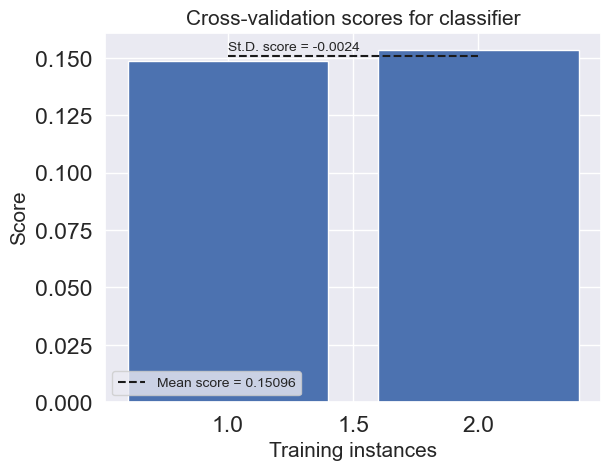

C:\Users\creep\AppData\Local\Temp\ipykernel_26100\1185149873.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['data_{}'.format(sample_values_solution[1])]['gbm_score_random'] = gbm_grid_random_search_model.predict_proba(data['data_{}'.format(sample_values_solution[1])][feats_best_gbm_back].values)[:,1]


In [91]:
import timeit
start = timeit.default_timer()

# 720 models in total
grid = {'n_estimators':[100, 200, 300, 400, 500], # Number of trees, 100-500 is usually sufficient
       'max_depth':[1, 2, 4, 6], # Depth of the tree, 5-6 is usually default
        "max_features":["sqrt", 'log2'], # Number of variables randomly sampled as candidates at each split, sqrt(p) is usually the default
#       'max_features':[*range(1,len(feats_best_gbm_back),math.ceil(len(feats_best_gbm_back)/5))], \
       'learning_rate':[0.1, 0.2, 0.3], # Learing rate. Shrinkage is used for reducing, or shrinking, the impact of each additional fitted 
# base-learner (tree). It reduces the size of incremental steps and thus penalizes the importance of each consecutive iteration. 
# The intuition behind this technique is that it is better to improve a model by taking many small steps than by taking fewer large steps. 
# If one of the boosting iterations turns out to be erroneous, its negative impact can be easily corrected in subsequent steps. 
# High learn rates and especially values close to 1.0 typically result in overfit models with poor performance. 
# Values much smaller than .01 significantly slow down the learning process and might be reserved for overnight runs. 0.10 default
        "min_samples_leaf": [0.01, 0.05, 0.10, 0.15], # Minimum number of observations in each leaf, 10 is usually default
        "min_samples_split": [0.1, 0.2, 0.3], # The minimum number of observations required to split an internal node
        # If int then min_samples_split is the minimum number of observations
        # If float then then minimum number of observations is a fraction and ceil(min_samples_split * n_samples) 
        "subsample":[0.8], # The fraction of samples from n_estimators
        "criterion": ["friedman_mse"] # The function to measure the quality of a split
#        , "loss":["deviance"]      
       }

gbm_grid_random_search_model = mb.grid_search_cv(
    n_splits = 2, # Number of cross-validation splits
    classifier = GradientBoostingClassifier, # Classifier name, e.g. RandomForestClassifier
    keras_function = None, # Define Keras function. If Keras is not used, then leave this parameter blank
    grid_params = grid, # Grid space
    dev_df = data['data_{}'.format(sample_values_solution[0])],  # Development sample that this will analysis will be performed
    feats = feats_best_gbm_back, # List of predictor names
    target = target_variable_name, # Target variable name
    weight_variable = weight_variable_name, # Weight variable name
    randomized_search = True, # Set to True if randomized grid search will be performed, or to False if exhaustive grid search will be performed
    n_random_grids = 100, # Number of grid searches when randomized_search=True. If randomized_search=False, then this parameter is not applicable
    random_state = None, # If int, random_state is the seed used by the random number generator; If RandomState instance, random_state is the random number generator; If None, the random number generator is the RandomState instance used by np.random.
    n_jobs = 8 # Number of jobs to run in parallel
)

stop = timeit.default_timer()
print('Execution time in seconds: ', stop - start)  
#Execution time in seconds:  131.4532392000001

# Save the best parameters
opt_params_random = gbm_grid_random_search_model.best_params_
print('The best hyperparameter set is:', opt_params_random)
print('Mean loss function for cross-validation test data: ', -gbm_grid_random_search_model.cv_results_['mean_test_score'][gbm_grid_random_search_model.best_index_])
print('Standard deviation loss function for cross-validation test data: ', gbm_grid_random_search_model.cv_results_['std_test_score'][gbm_grid_random_search_model.best_index_])
#print('Mean Gini for OOT data', 2*gbm_grid_random_search_model.score(oos[feats_best_gbm_back], oos[target_variable_name], sample_weight=oos[weight_variable_name])-1)

ev.plot_cross_validation_score(model=gbm_grid_random_search_model)

# Compute the score for the OOT data
data['data_{}'.format(sample_values_solution[1])]['gbm_score_random'] = gbm_grid_random_search_model.predict_proba(data['data_{}'.format(sample_values_solution[1])][feats_best_gbm_back].values)[:,1]

### Grid search based on GridSearchCV - also uses cross-validation

grid_search_cv took 149.78 seconds
Execution time in seconds:  149.791740799963
The best hyperparameter set is: {'criterion': 'friedman_mse', 'learning_rate': 0.3, 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.2, 'n_estimators': 200, 'subsample': 0.8}
Mean loss function for cross-validation test data:  0.1589564118794121
Standard deviation loss function for cross-validation test data:  0.006954635964055128


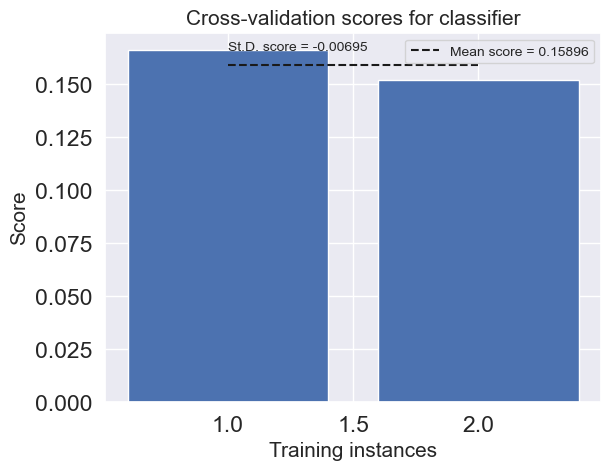

C:\Users\creep\AppData\Local\Temp\ipykernel_26100\2244981779.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['data_{}'.format(sample_values_solution[1])]['gbm_score_fixed'] = gbm_grid_fixed_search_model.predict_proba(data['data_{}'.format(sample_values_solution[1])][feats_best_gbm_back].values)[:, 1]


In [92]:
import timeit
start = timeit.default_timer()

from sklearn.model_selection import GridSearchCV

# 81 models in total
grid = {'n_estimators':[100, 200, 300], # Number of trees, 100-500 is usually sufficient
       'max_depth':[2, 4, 6], # Depth of the tree, 5-6 is usually default
        "max_features":["sqrt"], # Number of variables randomly sampled as candidates at each split, sqrt(p) is usually the default
#       'max_features':[*range(1,len(feats_best_gbm_back),math.ceil(len(feats_best_gbm_back)/5))], \
       'learning_rate':[0.1, 0.2, 0.3], # Learing rate. Shrinkage is used for reducing, or shrinking, the impact of each additional fitted 
# base-learner (tree). It reduces the size of incremental steps and thus penalizes the importance of each consecutive iteration. 
# The intuition behind this technique is that it is better to improve a model by taking many small steps than by taking fewer large steps. 
# If one of the boosting iterations turns out to be erroneous, its negative impact can be easily corrected in subsequent steps. 
# High learn rates and especially values close to 1.0 typically result in overfit models with poor performance. 
# Values much smaller than .01 significantly slow down the learning process and might be reserved for overnight runs. 0.10 default
        "min_samples_leaf": [0.05, 0.10, 0.15], # Minimum number of observations in each leaf, 10 is usually default
        "min_samples_split": [0.2], # The minimum number of observations required to split an internal node
        # If int then min_samples_split is the minimum number of observations
        # If float then then minimum number of observations is a fraction and ceil(min_samples_split * n_samples) 
        "subsample":[0.8], # The fraction of samples from n_estimators
        "criterion": ["friedman_mse"] # The function to measure the quality of a split
#        , "loss":["deviance"]      
       }

gbm_grid_fixed_search_model = mb.grid_search_cv(
    n_splits = 2, # Number of cross-validation splits
    classifier = GradientBoostingClassifier, # Classifier name, e.g. RandomForestClassifier
    keras_function = None, # Define Keras function. If Keras is not used, then leave this parameter blank
    grid_params = grid, # Grid space
    dev_df = data['data_{}'.format(sample_values_solution[0])],  # Development sample that this will analysis will be performed
    feats = feats_best_gbm_back, # List of predictor names
    target = target_variable_name, # Target variable name
    weight_variable = weight_variable_name, # Weight variable name
    randomized_search = False, # Set to True if randomized grid search will be performed, or to False if exhaustive grid search will be performed
    n_random_grids = 1, # Number of grid searches when randomized_search=True. If randomized_search=False, then this parameter is not applicable
    random_state = None, # If int, random_state is the seed used by the random number generator; If RandomState instance, random_state is the random number generator; If None, the random number generator is the RandomState instance used by np.random.
    n_jobs = 8 # Number of jobs to run in parallel
)

stop = timeit.default_timer()
print('Execution time in seconds: ', stop - start)  
#Execution time in seconds:  61.786609

# Save the best parameters
opt_params_fixed = gbm_grid_fixed_search_model.best_params_
print('The best hyperparameter set is:', opt_params_fixed)
print('Mean loss function for cross-validation test data: ', -gbm_grid_fixed_search_model.cv_results_['mean_test_score'][gbm_grid_fixed_search_model.best_index_])
print('Standard deviation loss function for cross-validation test data: ', gbm_grid_fixed_search_model.cv_results_['std_test_score'][gbm_grid_fixed_search_model.best_index_])
#print('Mean Gini for OOT data', 2*gbm_grid_fixed_search_model.score(oos[feats_best_gbm_back], oos[target_variable_name], sample_weight=oos[weight_variable_name])-1)

ev.plot_cross_validation_score(model=gbm_grid_fixed_search_model)

# Compute the score for the OOT data
data['data_{}'.format(sample_values_solution[1])]['gbm_score_fixed'] = gbm_grid_fixed_search_model.predict_proba(data['data_{}'.format(sample_values_solution[1])][feats_best_gbm_back].values)[:, 1]

## Calculate GBM feature importance

In [93]:
# Load GBM algorithm
from sklearn.ensemble import GradientBoostingClassifier

# Define the GBM model
opt_params = opt_params_random
gbm = GradientBoostingClassifier(n_estimators=[x[1] for x in list(opt_params.items()) if x[0]=='n_estimators'][0], 
                                 max_depth=[x[1] for x in list(opt_params.items()) if x[0]=='max_depth'][0], 
                                 max_features=[x[1] for x in list(opt_params.items()) if x[0]=='max_features'][0], 
                                 learning_rate=[x[1] for x in list(opt_params.items()) if x[0]=='learning_rate'][0], 
                                 min_samples_leaf=[x[1] for x in list(opt_params.items()) if x[0]=='min_samples_leaf'][0], 
                                 min_samples_split=[x[1] for x in list(opt_params.items()) if x[0]=='min_samples_split'][0], 
                                 subsample=[x[1] for x in list(opt_params.items()) if x[0]=='subsample'][0], 
                                 criterion=[x[1] for x in list(opt_params.items()) if x[0]=='criterion'][0],                                 
                                 random_state=0)

# Train the model
gbm_model = mb.fit_model_weight(data['data_{}'.format(sample_values_solution[0])], feats_best_gbm_back, target_variable_name, weight_variable_name, gbm, 'gbm.pkl')

# Calculate feature importance
feat_imprtnce_dictnry_gbm = mb.feature_imp(gbm_model, feats_best_gbm_back)
for key, value in sorted(feat_imprtnce_dictnry_gbm.items(), key=lambda item: item[1], reverse=True):
    print("%s: %s" % (key, value))

fit_model_weight took 4.72 seconds
feature_imp took 0.0 seconds
random_var_7: 0.26240649851611725
random_var_15: 0.216122373697517
random_var_11: 0.10812799086434843
random_var_8: 0.10152161614638724
random_var_10: 0.0813681832826392
random_var_6: 0.0701821777436844
random_var_17: 0.04812169884635903
random_var_5: 0.04617410950636393
random_var_13: 0.044590380830619294
random_var_1: 0.021384970565964192


## Calculate GBM log-loss

In [94]:
from sklearn.metrics import log_loss
print ("log-loss_iterative")
print(log_loss(y_true=data['data_{}'.format(sample_values_solution[1])][target_variable_name].values, y_pred=data['data_{}'.format(sample_values_solution[1])]['gbm_score_iterative'].values, sample_weight=data['data_{}'.format(sample_values_solution[1])][weight_variable_name].values, eps=1e-15))
print ("log-loss_fixed")
print(log_loss(y_true=data['data_{}'.format(sample_values_solution[1])][target_variable_name].values, y_pred=data['data_{}'.format(sample_values_solution[1])]['gbm_score_fixed'].values, sample_weight=data['data_{}'.format(sample_values_solution[1])][weight_variable_name].values, eps=1e-15))
print ("log-loss_random")
print(log_loss(y_true=data['data_{}'.format(sample_values_solution[1])][target_variable_name].values, y_pred=data['data_{}'.format(sample_values_solution[1])]['gbm_score_random'].values, sample_weight=data['data_{}'.format(sample_values_solution[1])][weight_variable_name].values, eps=1e-15))

log-loss_iterative
0.1479635551046569
log-loss_fixed
0.14925097813323207
log-loss_random
0.13834434000407228


## Calculate GBM Precision/Recall Area Under the Curve

In [95]:
print ("precision_recall_auc_iterative")
print(ev.auc_precision_recall(table_name=data['data_{}'.format(sample_values_solution[1])], target_variable=target_variable_name, predicted_variable='gbm_score_iterative', 
                            weight_variable=weight_variable_name))
print ("precision_recall_auc_fixed")
print(ev.auc_precision_recall(table_name=data['data_{}'.format(sample_values_solution[1])], target_variable=target_variable_name, predicted_variable='gbm_score_fixed', 
                            weight_variable=weight_variable_name))
print ("precision_recall_auc_random")
print(ev.auc_precision_recall(table_name=data['data_{}'.format(sample_values_solution[1])], target_variable=target_variable_name, predicted_variable='gbm_score_random', 
                            weight_variable=weight_variable_name))

precision_recall_auc_iterative
0.9445261814995518
precision_recall_auc_fixed
0.9370381007728675
precision_recall_auc_random
0.9438011495298344


## Calculate GBM Gini, for the top population

In [96]:
print ("unit_gini_iterative")
print(ev.calculate_gini(
    table_name=data['data_{}'.format(sample_values_solution[1])], # Table name
    target_variable=target_variable_name, # Target variable name
    predicted_variable='gbm_score_iterative', # Predicted variable name
    weight_variable=weight_variable_name, # Weight variable name
    select_top_percent=100 # Percent between 0 and 100: Gini is calculated for the top select_top_percent% of the observations, sorted by score
    ))
print ("unit_gini_fixed")
print(ev.calculate_gini(
    table_name=data['data_{}'.format(sample_values_solution[1])], # Table name
    target_variable=target_variable_name, # Target variable name
    predicted_variable='gbm_score_fixed', # Predicted variable name
    weight_variable=weight_variable_name, # Weight variable name
    select_top_percent=100 # Percent between 0 and 100: Gini is calculated for the top select_top_percent% of the observations, sorted by score
    ))
print ("unit_gini_random")
print(ev.calculate_gini(
    table_name=data['data_{}'.format(sample_values_solution[1])], # Table name
    target_variable=target_variable_name, # Target variable name
    predicted_variable='gbm_score_random', # Predicted variable name
    weight_variable=weight_variable_name, # Weight variable name
    select_top_percent=100 # Percent between 0 and 100: Gini is calculated for the top select_top_percent% of the observations, sorted by score
    ))

unit_gini_iterative
calculate_gini took 0.01 seconds
0.9501094377366384
unit_gini_fixed
calculate_gini took 0.0 seconds
0.9425364284645839
unit_gini_random
calculate_gini took 0.01 seconds
0.9486618688764787


## Calculate GBM Lifting table

In [97]:
lt_gbm_iterative = ev.lift_table_weight(data['data_{}'.format(sample_values_solution[1])][['gbm_score_iterative', target_variable_name, amount_variable_name, weight_variable_name]].values, n_bands=10, rows=10).round(decimals=3)
lt_gbm_fixed = ev.lift_table_weight(data['data_{}'.format(sample_values_solution[1])][['gbm_score_fixed', target_variable_name, amount_variable_name, weight_variable_name]].values, n_bands=10, rows=10).round(decimals=3)
lt_gbm_random = ev.lift_table_weight(data['data_{}'.format(sample_values_solution[1])][['gbm_score_random', target_variable_name, amount_variable_name, weight_variable_name]].values, n_bands=10, rows=10).round(decimals=3)
lt_gbm_fixed

lift_table_weight took 0.02 seconds
lift_table_weight took 0.01 seconds
lift_table_weight took 0.01 seconds


Quantile Unit  # Cases  # Responses  Cumulative # Responses  % Response  \
0            0.1  147.335      146.070                 146.070       0.991   
1            0.2  148.128      116.512                 262.582       0.787   
2            0.3  147.199       23.604                 286.186       0.160   
3            0.4  148.465        8.111                 294.296       0.055   
4            0.5  147.505        2.573                 296.870       0.017   
5            0.6  147.527        1.487                 298.357       0.010   
6            0.7  148.028        2.867                 301.224       0.019   
7            0.8  147.730        0.000                 301.224       0.000   
8            0.9  147.940        0.278                 301.502       0.002   
9            1.0  147.989        1.486                 302.988       0.010   

            FPR  Cumulative FPR    ADR  Cumulative ADR   Lift  \
0  9.000000e-03           0.009  0.482           0.482  4.836   
1  2.710000e-01           0.125  0.385           0.867  3.837   
2  5.236000e+00           0.547  0.078           0.945  0.782   
3  1.730500e+01           1.009  0.027           0.971  0.266   
4  5.632100e+01           1.488  0.008           0.980  0.085   
5  9.821100e+01           1.970  0.005           0.985  0.049   
6  5.062500e+01           2.433  0.009           0.994  0.094   
7  1.000000e+09           2.924  0.000           0.994  0.000   
8  5.319540e+02           3.411  0.001           0.995  0.009   
9  9.858700e+01           3.878  0.005           1.000  0.049   

   Cumulative Lift  Quantile Value        Value  Cumulative Value    VDR  \
0            4.836             0.1  1487410.673       1487410.673  0.487   
1            4.335             0.2  1163992.549       2651403.222  0.381   
2            3.153             0.3   240234.686       2891637.908  0.079   
3            2.428             0.4    82353.510       2973991.417  0.027   
4            1.960             0.5    23504.479       2997495.896  0.008   
5            1.642             0.6    14521.299       3012017.195  0.005   
6            1.421             0.7    25273.800       3037290.995  0.008   
7            1.243             0.8        0.000       3037290.995  0.000   
8            1.106             0.9     2687.212       3039978.207  0.001   
9            1.000             1.0    15529.123       3055507.330  0.005   

   Cumulative VDR  
0           0.487  
1           0.868  
2           0.946  
3           0.973  
4           0.981  
5           0.986  
6           0.994  
7           0.994  
8           0.995  
9           1.000

## Plots GBM

### Plot GBM Detection rate vs. Population Distribution

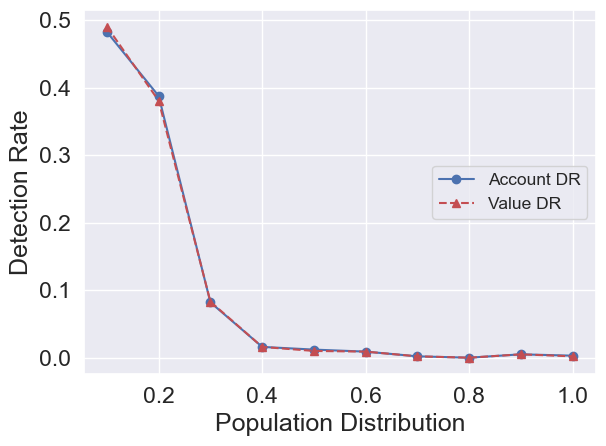

plot_ADR_Quantile took 0.24 seconds


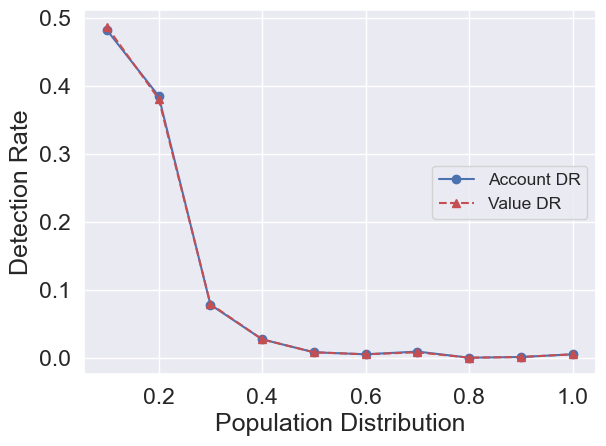

plot_ADR_Quantile took 0.21 seconds


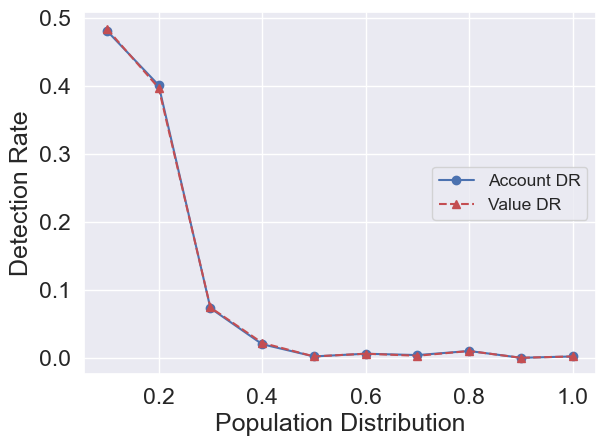

plot_ADR_Quantile took 0.53 seconds


In [98]:
ev.plot_ADR_Quantile(lt_gbm_iterative)
ev.plot_ADR_Quantile(lt_gbm_fixed)
ev.plot_ADR_Quantile(lt_gbm_random)

### Plot GBM Cum. Detection rate vs. Population Distribution (Gains chart)

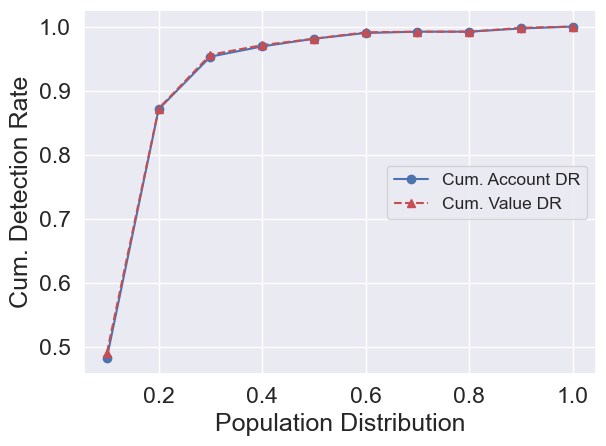

plot_cADR_Quantile took 0.24 seconds


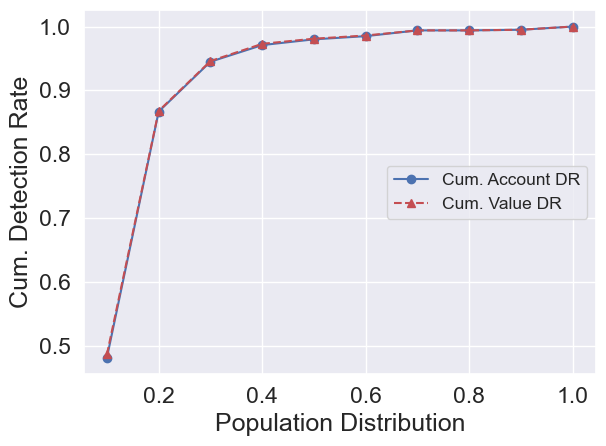

plot_cADR_Quantile took 0.2 seconds


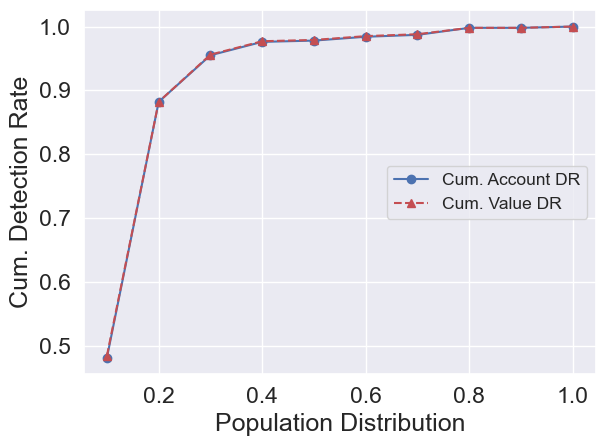

plot_cADR_Quantile took 0.23 seconds


In [99]:
ev.plot_cADR_Quantile(lt_gbm_iterative)
ev.plot_cADR_Quantile(lt_gbm_fixed)
ev.plot_cADR_Quantile(lt_gbm_random)

### Plot GBM FPR vs. Population Distribution

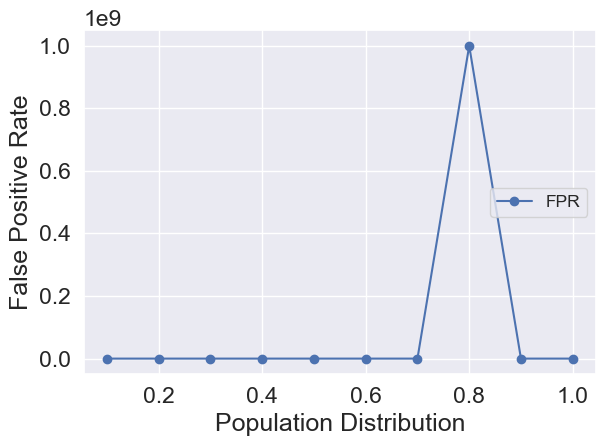

plot_FPR_Quantile took 0.23 seconds


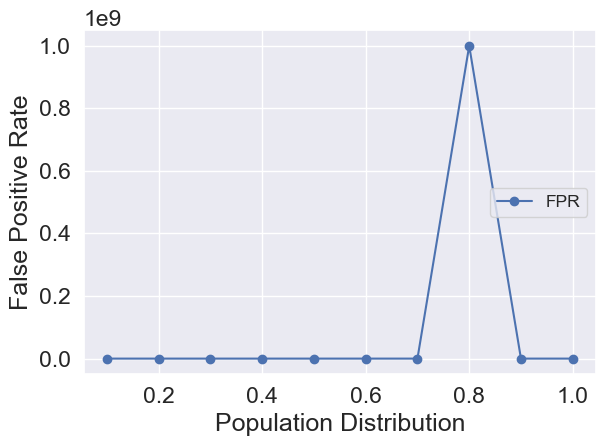

plot_FPR_Quantile took 0.19 seconds


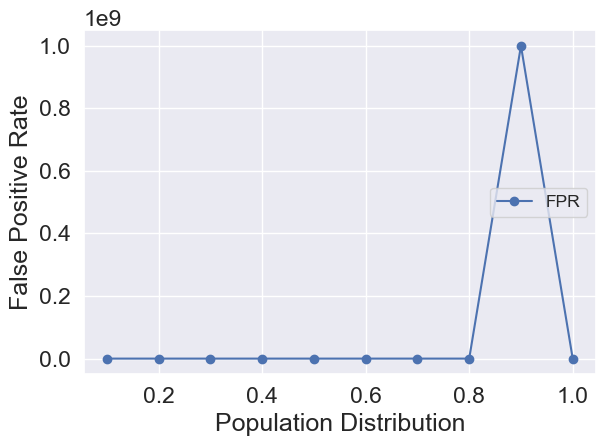

plot_FPR_Quantile took 0.2 seconds


In [100]:
ev.plot_FPR_Quantile(lt_gbm_iterative)
ev.plot_FPR_Quantile(lt_gbm_fixed)
ev.plot_FPR_Quantile(lt_gbm_random)

### Plot GBM Cum. FPR vs. Population Distribution

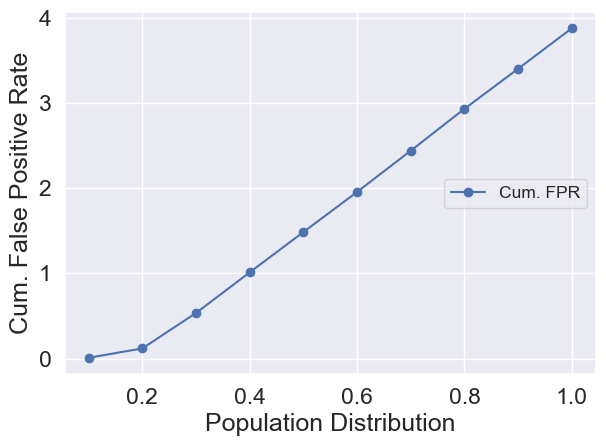

plot_cFPR_Quantile took 0.22 seconds


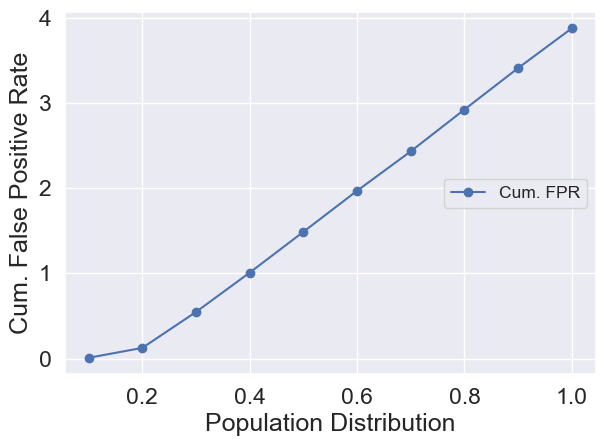

plot_cFPR_Quantile took 0.2 seconds


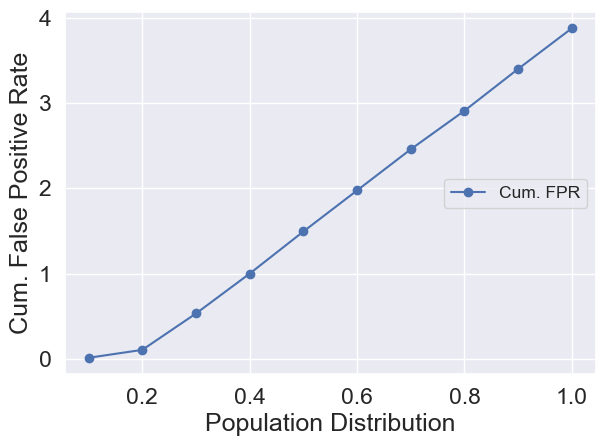

plot_cFPR_Quantile took 0.2 seconds


In [101]:
ev.plot_cFPR_Quantile(lt_gbm_iterative)
ev.plot_cFPR_Quantile(lt_gbm_fixed)
ev.plot_cFPR_Quantile(lt_gbm_random)

### Plot GBM ROC curve

Random: ROC AUC=0.500
Model: ROC AUC=0.975


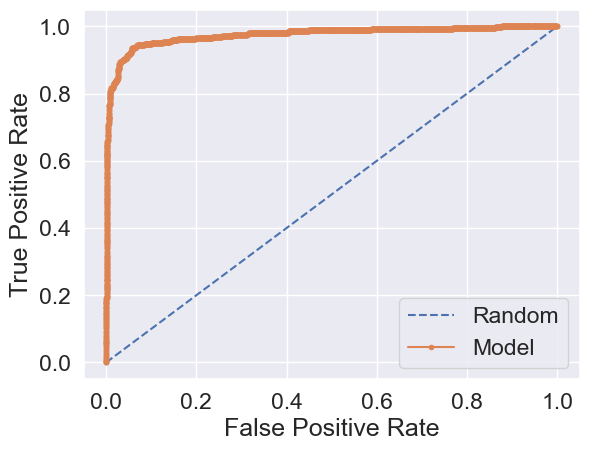

plot_ROC_curve took 0.24 seconds
Random: ROC AUC=0.500
Model: ROC AUC=0.971


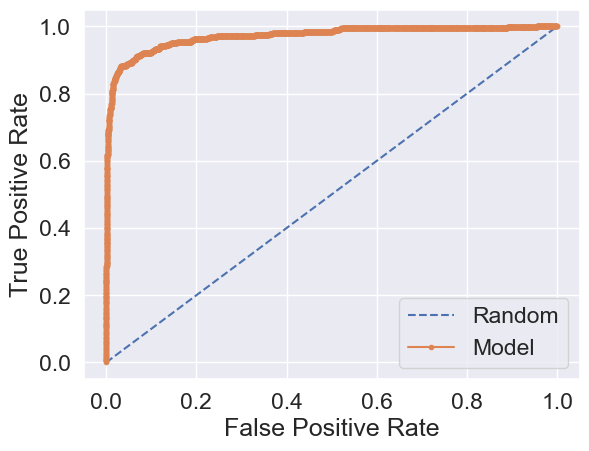

plot_ROC_curve took 0.21 seconds
Random: ROC AUC=0.500
Model: ROC AUC=0.974


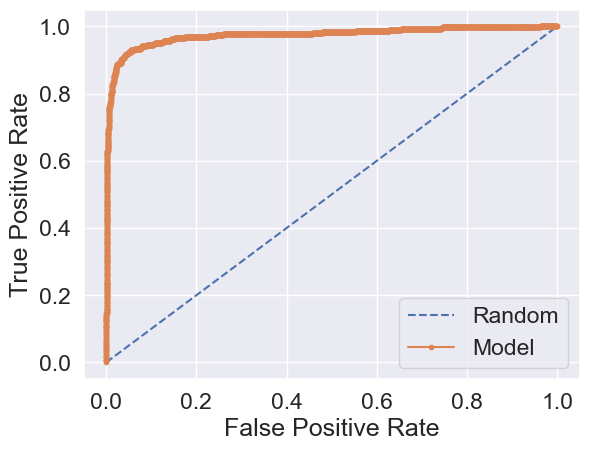

plot_ROC_curve took 0.22 seconds


In [102]:
ev.plot_ROC_curve(table_name=data['data_{}'.format(sample_values_solution[1])], target_variable=target_variable_name, predicted_variable='gbm_score_iterative', weight_variable=weight_variable_name) 
ev.plot_ROC_curve(table_name=data['data_{}'.format(sample_values_solution[1])], target_variable=target_variable_name, predicted_variable='gbm_score_fixed', weight_variable=weight_variable_name) 
ev.plot_ROC_curve(table_name=data['data_{}'.format(sample_values_solution[1])], target_variable=target_variable_name, predicted_variable='gbm_score_random', weight_variable=weight_variable_name) 

### Plot GBM Precision Recall curve

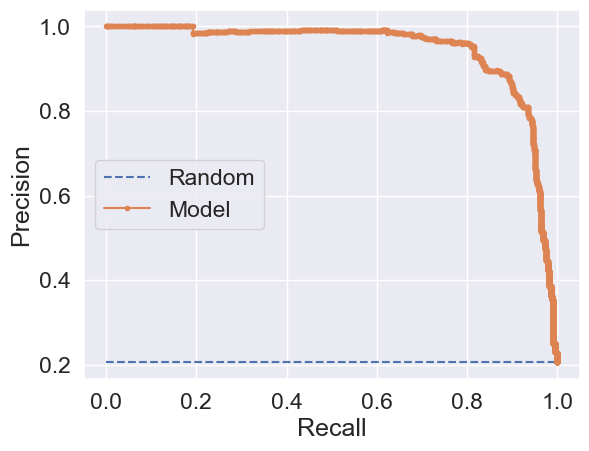

plot_precision_recall_curve took 0.22 seconds


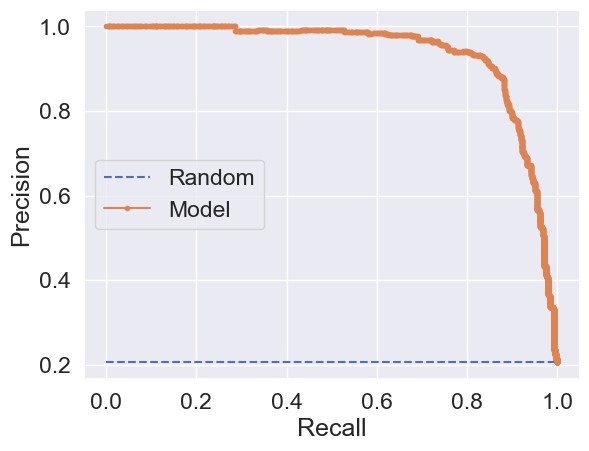

plot_precision_recall_curve took 0.2 seconds


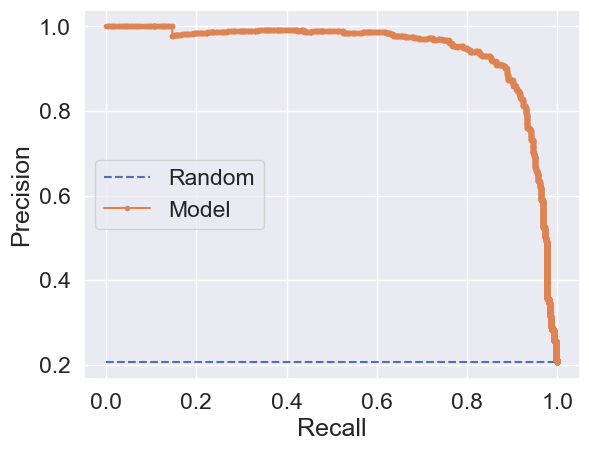

plot_precision_recall_curve took 0.2 seconds


In [103]:
ev.plot_precision_recall_curve(table_name=data['data_{}'.format(sample_values_solution[1])], target_variable=target_variable_name, predicted_variable='gbm_score_iterative', 
                            weight_variable=weight_variable_name)
ev.plot_precision_recall_curve(table_name=data['data_{}'.format(sample_values_solution[1])], target_variable=target_variable_name, predicted_variable='gbm_score_fixed', 
                            weight_variable=weight_variable_name)
ev.plot_precision_recall_curve(table_name=data['data_{}'.format(sample_values_solution[1])], target_variable=target_variable_name, predicted_variable='gbm_score_random', 
                            weight_variable=weight_variable_name)  

### Plot GBM F1 score, Accuracy, Sensitivity, Specificity, Precision vs Cutoff

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\evaluation.py:575: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  
C:\Users\creep\Anaconda\Sotiris_Solutions\functions\evaluation.py:571: RuntimeWarning: invalid value encountered in double_scalars
  if sys.version_info[0] < 2:


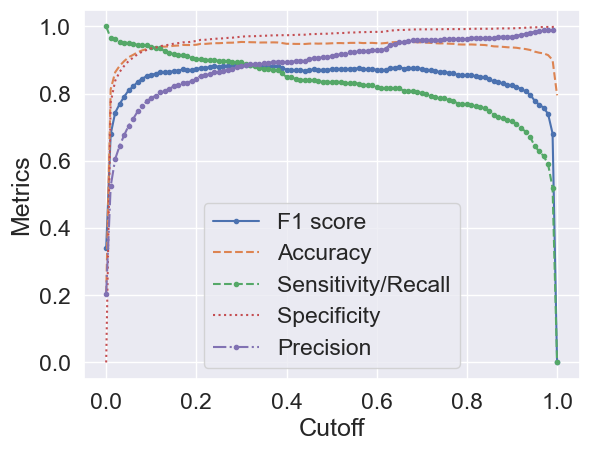

plot_cutoffs took 0.54 seconds


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\evaluation.py:575: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  
C:\Users\creep\Anaconda\Sotiris_Solutions\functions\evaluation.py:571: RuntimeWarning: invalid value encountered in double_scalars
  if sys.version_info[0] < 2:


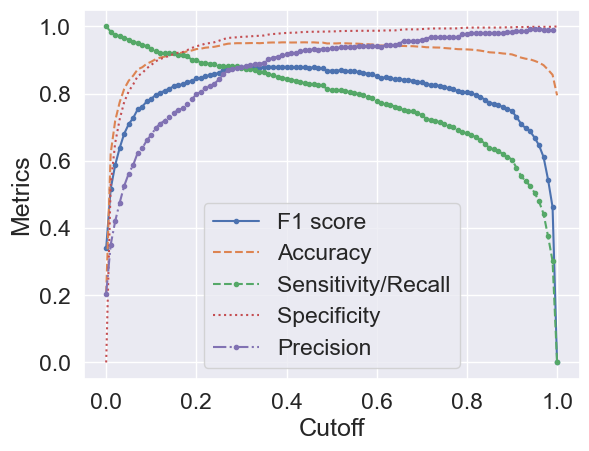

plot_cutoffs took 0.53 seconds


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\evaluation.py:575: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  
C:\Users\creep\Anaconda\Sotiris_Solutions\functions\evaluation.py:571: RuntimeWarning: invalid value encountered in double_scalars
  if sys.version_info[0] < 2:


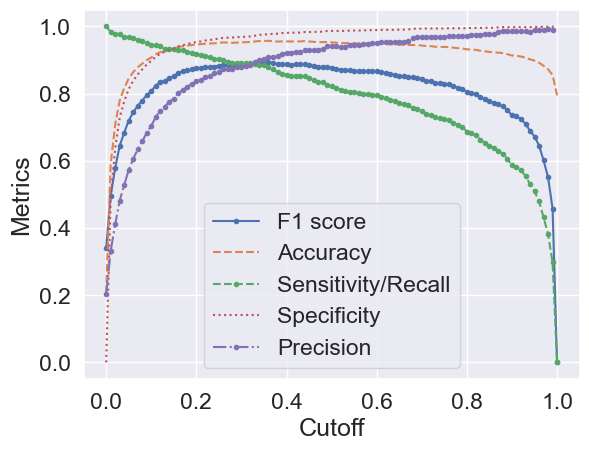

plot_cutoffs took 0.53 seconds


In [104]:
ev.plot_cutoffs(table_name=data['data_{}'.format(sample_values_solution[1])], target_variable=target_variable_name, predicted_variable='gbm_score_iterative', 
                            weight_variable=weight_variable_name, n_bands=100, return_table=False)
ev.plot_cutoffs(table_name=data['data_{}'.format(sample_values_solution[1])], target_variable=target_variable_name, predicted_variable='gbm_score_fixed', 
                            weight_variable=weight_variable_name, n_bands=100, return_table=False)
ev.plot_cutoffs(table_name=data['data_{}'.format(sample_values_solution[1])], target_variable=target_variable_name, predicted_variable='gbm_score_random', 
                            weight_variable=weight_variable_name, n_bands=100, return_table=False)

# Light Gradient Boosting Machine

## Feature selection lightGBM

In [105]:
# Provide input data to feature selection class
select = fs.SelectBest_weight(df=data['data_{}'.format(sample_values_solution[0])], target=target_variable_name, weight=weight_variable_name)

In [107]:
# Select top features to apply a first screening
from lightgbm import LGBMClassifier
model_lgbm = LGBMClassifier(boosting_type='gbdt',  objective='binary', n_estimators=200, learning_rate=0.1, max_depth=5, random_state=1234, n_jobs=6)
lgbm_importance, feats_best_lgbm = select.top_lgbm_feat(feats=keep_num_vars_gini, model=model_lgbm, n=15)
print('The top lightGBM features are: \n', feats_best_lgbm)
lgbm_importance

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 1436, number of negative: 5615
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001935 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5614
[LightGBM] [Info] Number of data points in the train set: 7051, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203742 -> initscore=-1.363066
[LightGBM] [Info] Start training from score -1.363066
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

[('random_var_3', 364),
 ('random_var_15', 357),
 ('random_var_11', 349),
 ('random_var_19', 321),
 ('random_var_10', 305),
 ('random_var_7', 302),
 ('random_var_5', 300),
 ('random_var_8', 287),
 ('random_var_17', 271),
 ('random_var_9', 255),
 ('random_var_13', 250),
 ('random_var_6', 247),
 ('random_var_16', 243),
 ('random_var_1', 220),
 ('random_var_0', 89),
 ('random_var_14', 86),
 ('random_var_18', 84),
 ('num_2%', 83),
 ('num_20%', 80),
 ('random_var_12', 74),
 ('random_var_2', 74),
 ('random_var_4', 62),
 ('cat_3_2', 11),
 ('cat_3_3', 6)]

In [108]:
import timeit
start = timeit.default_timer()

# Backward selection with lightGBM model: In each step a feature is selected to remove - this removal maximizes Gini
feats_best_lgbm_back = select.backward_recur(feats=feats_best_lgbm, oos=data['data_{}'.format(sample_values_solution[1])], model=model_lgbm, min_feats=10, classification=True)
print(feats_best_lgbm_back)

stop = timeit.default_timer()
print('Execution time in seconds: ', stop - start)  
# Execution time in seconds:  11.858331700000008

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 1436, number of negative: 5615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000462 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 7051, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203742 -> initscore=-1.363066
[LightGBM] [Info] Start training from score -1.363066
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\feature_selection.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oos['score']=model.predict_proba(oos[left].values)[:, 1]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\feature_selection.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oos['score']=model.predict_proba(oos[left].values)[:, 1]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\feature_selection.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oos['score']=model.predict_proba(oos[left].values)[:, 1]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\feature_selection.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oos['score']=model.predict_proba(oos[left].values)[:, 1]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\feature_selection.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oos['score']=model.predict_proba(oos[left].values)[:, 1]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\feature_selection.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oos['score']=model.predict_proba(oos[left].values)[:, 1]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\feature_selection.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oos['score']=model.predict_proba(oos[left].values)[:, 1]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\feature_selection.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oos['score']=model.predict_proba(oos[left].values)[:, 1]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\feature_selection.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oos['score']=model.predict_proba(oos[left].values)[:, 1]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\feature_selection.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oos['score']=model.predict_proba(oos[left].values)[:, 1]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\feature_selection.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oos['score']=model.predict_proba(oos[left].values)[:, 1]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\feature_selection.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oos['score']=model.predict_proba(oos[left].values)[:, 1]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\feature_selection.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oos['score']=model.predict_proba(oos[left].values)[:, 1]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\feature_selection.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oos['score']=model.predict_proba(oos[left].values)[:, 1]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\feature_selection.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oos['score']=model.predict_proba(oos[left].values)[:, 1]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\feature_selection.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oos['score']=model.predict_proba(oos[left].values)[:, 1]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\feature_selection.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oos['score']=model.predict_proba(oos[left].values)[:, 1]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\feature_selection.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oos['score']=model.predict_proba(oos[left].values)[:, 1]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\feature_selection.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oos['score']=model.predict_proba(oos[left].values)[:, 1]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\feature_selection.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oos['score']=model.predict_proba(oos[left].values)[:, 1]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\feature_selection.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oos['score']=model.predict_proba(oos[left].values)[:, 1]


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 1436, number of negative: 5615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000570 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 7051, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203742 -> initscore=-1.363066
[LightGBM] [Info] Start training from score -1.363066
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\feature_selection.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oos['score']=model.predict_proba(oos[left].values)[:, 1]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_le

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\feature_selection.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oos['score']=model.predict_proba(oos[left].values)[:, 1]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\feature_selection.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oos['score']=model.predict_proba(oos[left].values)[:, 1]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\feature_selection.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oos['score']=model.predict_proba(oos[left].values)[:, 1]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\feature_selection.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oos['score']=model.predict_proba(oos[left].values)[:, 1]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\feature_selection.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oos['score']=model.predict_proba(oos[left].values)[:, 1]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\feature_selection.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oos['score']=model.predict_proba(oos[left].values)[:, 1]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\feature_selection.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oos['score']=model.predict_proba(oos[left].values)[:, 1]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\feature_selection.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oos['score']=model.predict_proba(oos[left].values)[:, 1]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\feature_selection.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oos['score']=model.predict_proba(oos[left].values)[:, 1]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\feature_selection.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oos['score']=model.predict_proba(oos[left].values)[:, 1]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\feature_selection.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oos['score']=model.predict_proba(oos[left].values)[:, 1]


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 1436, number of negative: 5615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 7051, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203742 -> initscore=-1.363066
[LightGBM] [Info] Start training from score -1.363066
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\feature_selection.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oos['score']=model.predict_proba(oos[left].values)[:, 1]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 1436, number of negative: 5615
[LightGBM] [Info

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\feature_selection.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oos['score']=model.predict_proba(oos[left].values)[:, 1]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 1436, number of negative: 5615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000347 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 7051, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203742 -> initscore=-1.363066
[LightGBM] [Info] Start training from score -1.363066
[LightGBM] [Warning] No further splits with 

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\feature_selection.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oos['score']=model.predict_proba(oos[left].values)[:, 1]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 1436, number of negative: 5615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 7051, number of used features: 12
[LightGBM] [Info] [binary:Bo

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\feature_selection.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oos['score']=model.predict_proba(oos[left].values)[:, 1]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 1436, number of negative: 5615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 7051, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203742 -> initscore=-1.363066
[LightGBM] [Info] Start training from score -1.363066
[LightGBM] [Warning] No further splits with 

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\feature_selection.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oos['score']=model.predict_proba(oos[left].values)[:, 1]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\feature_selection.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oos['score']=model.predict_proba(oos[left].values)[:, 1]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\feature_selection.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oos['score']=model.predict_proba(oos[left].values)[:, 1]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\feature_selection.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oos['score']=model.predict_proba(oos[left].values)[:, 1]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\feature_selection.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oos['score']=model.predict_proba(oos[left].values)[:, 1]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\feature_selection.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oos['score']=model.predict_proba(oos[left].values)[:, 1]
C:\Users\creep\Anaconda\Sotiris_Solutions\functions\feature_selection.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oos['score']=model.predict_proba(oos[left].values)[:, 1]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\feature_selection.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oos['score']=model.predict_proba(oos[left].values)[:, 1]
C:\Users\creep\Anaconda\Sotiris_Solutions\functions\feature_selection.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oos['score']=model.predict_proba(oos[left].values)[:, 1]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\feature_selection.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oos['score']=model.predict_proba(oos[left].values)[:, 1]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\feature_selection.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oos['score']=model.predict_proba(oos[left].values)[:, 1]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\feature_selection.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oos['score']=model.predict_proba(oos[left].values)[:, 1]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\feature_selection.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oos['score']=model.predict_proba(oos[left].values)[:, 1]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\feature_selection.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oos['score']=model.predict_proba(oos[left].values)[:, 1]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\feature_selection.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oos['score']=model.predict_proba(oos[left].values)[:, 1]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\feature_selection.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oos['score']=model.predict_proba(oos[left].values)[:, 1]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\feature_selection.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oos['score']=model.predict_proba(oos[left].values)[:, 1]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\feature_selection.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oos['score']=model.predict_proba(oos[left].values)[:, 1]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\feature_selection.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oos['score']=model.predict_proba(oos[left].values)[:, 1]


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 1436, number of negative: 5615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 7051, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203742 -> initscore=-1.363066
[LightGBM] [Info] Start training from score -1.363066
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\feature_selection.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oos['score']=model.predict_proba(oos[left].values)[:, 1]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\feature_selection.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oos['score']=model.predict_proba(oos[left].values)[:, 1]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\feature_selection.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oos['score']=model.predict_proba(oos[left].values)[:, 1]


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 1436, number of negative: 5615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 7051, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203742 -> initscore=-1.363066
[LightGBM] [Info] Start training from score -1.363066
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\feature_selection.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oos['score']=model.predict_proba(oos[left].values)[:, 1]


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 1436, number of negative: 5615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 7051, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203742 -> initscore=-1.363066
[LightGBM] [Info] Start training from score -1.363066
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\feature_selection.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oos['score']=model.predict_proba(oos[left].values)[:, 1]
C:\Users\creep\Anaconda\Sotiris_Solutions\functions\feature_selection.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oos['score']=model.predict_proba(oos[left].values)[:, 1]


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 1436, number of negative: 5615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000312 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 7051, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203742 -> initscore=-1.363066
[LightGBM] [Info] Start training from score -1.363066
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\feature_selection.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oos['score']=model.predict_proba(oos[left].values)[:, 1]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 1436, number of negative: 5615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 7051, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203742 -> initscore=-1.363066
[LightGBM] [Info] Start training from score -1.363066
[LightGBM] [Warning] No further splits with 

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\feature_selection.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oos['score']=model.predict_proba(oos[left].values)[:, 1]
C:\Users\creep\Anaconda\Sotiris_Solutions\functions\feature_selection.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oos['score']=model.predict_proba(oos[left].values)[:, 1]


## Grid search and train lightGBM machine learning model

### Grid search based on iterative step search

In [109]:
# Hyperparameter tuning: The process works as follows:
# 1) Iterate n_estimators (grid) for the fixed values of max_depth, learning_rate, etc (params). Select the value of n_estimators that minimizes the loss function. 
# 2) Keep the n_estimators value from the previous step. Iterate max_depth (grid) for the fixed value of learning_rate, etc (params). Select the value of max_depth that minimizes the loss function. 
# 3) Keep the max_depth value from the previous step. Iterate learning_rate (grid) for the fixed value of the remaining parameters (params). Select the value of max_features that minimizes the loss function. 
# 4) ...
import timeit
start = timeit.default_timer()

import math
# 38 models in total
grid = {'n_estimators':[10, 20, 50, 100, 200], # Number of trees, 100-500 is usually sufficient
       'max_depth':[2, 5, 10], # Depth of the tree, 5-6 is usually default
       'learning_rate':[0.05, 0.1, 0.2, 0.5], # Learing rate. Shrinkage is used for reducing, or shrinking, the impact of each additional fitted 
# base-learner (tree). It reduces the size of incremental steps and thus penalizes the importance of each consecutive iteration. 
# The intuition behind this technique is that it is better to improve a model by taking many small steps than by taking fewer large steps. 
# If one of the boosting iterations turns out to be erroneous, its negative impact can be easily corrected in subsequent steps. 
# High learn rates and especially values close to 1.0 typically result in overfit models with poor performance. 
# Values much smaller than .01 significantly slow down the learning process and might be reserved for overnight runs. 0.10 default
        'min_child_samples': [10, 100, 500, 1000, 2000, 5000], # Minimum number of observations in each leaf, 10 is usually default
        'subsample': [0.5, 0.7, 0.8, 0.9, 0.95, 1.0], # The fraction of samples from n_estimators
        'colsample_bytree': np.linspace(0.01, 0.4, 10), # Subsample ratio of columns when constructing each tree
        'eval_metric': ['l2', 'l1', 'logloss', 'ndcg'], # If string, it should be a built-in evaluation metric to use
        'boosting_type': ['gbdt', 'dart', 'goss'], # ‘gbdt’, traditional Gradient Boosting Decision Tree. ‘dart’, Dropouts meet Multiple Additive Regression Trees. ‘goss’, Gradient-based One-Side Sampling. ‘rf’, Random Forest
        'num_leaves': [10, 20, 30, 50], # Maximum number of tree leaves 
        'bagging_fraction': [0.5, 0.7, 0.8, 0.9, 0.95, 1.0], # The fraction of observations to be used for each iteration
        'reg_alpha': [0.1, 0.5], # L1 regularization term on weights
        'reg_lambda': [0.1, 0.5], # L2 regularization term on weights
        'lambda_l1': [0, 1, 1.5], # L1 regularization
        'lambda_l2': [0, 1], # L2 regularization
        'importance_type': ['split'], # The type of feature importance to be filled into feature_importances_. If ‘split’, result contains numbers of times the feature is used in a model. If ‘gain’, result contains total gains of splits which use the feature.
        'objective': ['binary'] # Specify the learning task and the corresponding learning objective
       }

params = {'n_estimators': 100, 'max_depth':4, 'learning_rate':0.1, 'min_child_samples': 10, 'subsample': 1.0, 
          'colsample_bytree': math.ceil(math.sqrt(len(feats_best_lgbm_back)))/len(feats_best_lgbm_back),  'eval_metric': 'l2', 'boosting_type': 'gbdt',
          'num_leaves': 31, 'bagging_fraction':1, 'reg_alpha': 0, 'reg_lambda': 0, 'lambda_l1': 0, 'lambda_l2': 0,
          'importance_type': 'split', 'objective': 'binary'
         }            

opt_params_iterative, loss = mb.step_search_weight(estimator=LGBMClassifier, params=params, grid=grid, target=target_variable_name, 
                                  weight=weight_variable_name, dev=data['data_{}'.format(sample_values_solution[0])], val=data['data_{}'.format(sample_values_solution[1])], keep=feats_best_lgbm_back)
print('\n Best Parameters')
print(opt_params_iterative)
print(loss)

# Define the lightGBM model
lightgbm_classifier = LGBMClassifier(n_estimators=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='n_estimators'][0], 
                                 max_depth=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='max_depth'][0], 
                                 learning_rate=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='learning_rate'][0], 
                                 min_child_samples=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='min_child_samples'][0], 
                                 subsample=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='subsample'][0], 
                                 colsample_bytree=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='colsample_bytree'][0], 
                                 eval_metric=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='eval_metric'][0], 
                                 boosting_type=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='boosting_type'][0], 
                                 num_leaves=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='num_leaves'][0], 
                                 bagging_fraction=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='bagging_fraction'][0], 
                                 reg_alpha=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='reg_alpha'][0], 
                                 reg_lambda=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='reg_lambda'][0], 
                                 lambda_l1=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='lambda_l1'][0], 
                                 lambda_l2=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='lambda_l2'][0], 
                                 importance_type=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='importance_type'][0], 
                                 objective=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='objective'][0], 
                                 random_state=1234, 
                                 n_jobs=6)

# Train the model
lightgbm_model = mb.fit_model_weight(data['data_{}'.format(sample_values_solution[0])], feats_best_lgbm_back, target_variable_name, weight_variable_name, lightgbm_classifier, 'lgbm_iterative.pkl')

# Compute the score for the OOT data
data['data_{}'.format(sample_values_solution[1])]['lightgbm_score_iterative'] = lightgbm_model.predict_proba(data['data_{}'.format(sample_values_solution[1])][feats_best_lgbm_back].values)[:, 1]

stop = timeit.default_timer()
print('Execution time in seconds: ', stop - start)  
#Execution time in seconds:  3.8296081999999387

Search Progress:
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Info] Number of positive: 1436, number of negative: 5615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]
C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]
C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]
C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]
C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
{'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.4, 'eval_metric': 'l2', 'boosting_type': 'gbdt', 'num_leaves': 31, 'bagging_fraction': 1, 'reg_alpha': 0, 'reg_lambda': 0, 'lambda_l1': 0, 'lambda_l2': 0, 'importance_type': 'split', 'objective': 'binary'} max_depth 10 0.13586399530368018 0.13238053107383022

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0 will be ignored. Cur

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]
C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]
C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


{'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.4, 'eval_metric': 'l2', 'boosting_type': 'gbdt', 'num_leaves': 31, 'bagging_fraction': 1, 'reg_alpha': 0, 'reg_lambda': 0, 'lambda_l1': 0, 'lambda_l2': 0, 'importance_type': 'split', 'objective': 'binary'} learning_rate 0.2 0.13272862374805047 0.13238053107383022
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0 will be ignored.

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]
C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


{'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'min_child_samples': 100, 'subsample': 1.0, 'colsample_bytree': 0.4, 'eval_metric': 'l2', 'boosting_type': 'gbdt', 'num_leaves': 31, 'bagging_fraction': 1, 'reg_alpha': 0, 'reg_lambda': 0, 'lambda_l1': 0, 'lambda_l2': 0, 'importance_type': 'split', 'objective': 'binary'} min_child_samples 100 0.13163397372386157 0.13163397372386157
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0 will be ign

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]
C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]
C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]
C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


{'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'min_child_samples': 100, 'subsample': 1.0, 'colsample_bytree': 0.4, 'eval_metric': 'l2', 'boosting_type': 'gbdt', 'num_leaves': 31, 'bagging_fraction': 1, 'reg_alpha': 0, 'reg_lambda': 0, 'lambda_l1': 0, 'lambda_l2': 0, 'importance_type': 'split', 'objective': 'binary'} subsample 0.5 0.13163397372386157 0.13163397372386157
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_fraction is set=1, subsample=0.7 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0 will be ignored. Cu

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]
C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


{'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'min_child_samples': 100, 'subsample': 1.0, 'colsample_bytree': 0.4, 'eval_metric': 'l2', 'boosting_type': 'gbdt', 'num_leaves': 31, 'bagging_fraction': 1, 'reg_alpha': 0, 'reg_lambda': 0, 'lambda_l1': 0, 'lambda_l2': 0, 'importance_type': 'split', 'objective': 'binary'} subsample 0.8 0.13163397372386157 0.13163397372386157
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_fraction is set=1, subsample=0.9 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0 will be ignored. Cu

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]
C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]
C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
{'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'min_child_samples': 100, 'subsample': 1.0, 'colsample_bytree': 0.4, 'eval_metric': 'l2', 'boosting_type': 'gbdt', 'num_leaves': 31, 'bagging_fraction': 1, 'reg_alpha': 0, 'reg_lambda': 0, 'lambda_l1': 0, 'lambda_l2': 0, 'importance_type': 'split', 'objective': 'binary'} colsample_bytree 0.05333333333333334 0.2752766647047396 0.13163397372386157
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]
C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]
C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


{'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'min_child_samples': 100, 'subsample': 1.0, 'colsample_bytree': 0.4, 'eval_metric': 'l2', 'boosting_type': 'gbdt', 'num_leaves': 31, 'bagging_fraction': 1, 'reg_alpha': 0, 'reg_lambda': 0, 'lambda_l1': 0, 'lambda_l2': 0, 'importance_type': 'split', 'objective': 'binary'} colsample_bytree 0.22666666666666668 0.18124946077996437 0.13163397372386157
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] lambda_l1 is set=0, reg_alph

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


{'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'min_child_samples': 100, 'subsample': 1.0, 'colsample_bytree': 0.4, 'eval_metric': 'l2', 'boosting_type': 'gbdt', 'num_leaves': 31, 'bagging_fraction': 1, 'reg_alpha': 0, 'reg_lambda': 0, 'lambda_l1': 0, 'lambda_l2': 0, 'importance_type': 'split', 'objective': 'binary'} colsample_bytree 0.27 0.14074237233635994 0.13163397372386157
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0 will be ign

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]
C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


{'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'min_child_samples': 100, 'subsample': 1.0, 'colsample_bytree': 0.4, 'eval_metric': 'l2', 'boosting_type': 'gbdt', 'num_leaves': 31, 'bagging_fraction': 1, 'reg_alpha': 0, 'reg_lambda': 0, 'lambda_l1': 0, 'lambda_l2': 0, 'importance_type': 'split', 'objective': 'binary'} colsample_bytree 0.31333333333333335 0.14074237233635994 0.13163397372386157
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] lambda_l1 is set=0, reg_alph

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]
C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]
C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]
C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]
C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]
C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]
C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


{'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'min_child_samples': 100, 'subsample': 1.0, 'colsample_bytree': 0.4, 'eval_metric': 'l2', 'boosting_type': 'gbdt', 'num_leaves': 20, 'bagging_fraction': 1, 'reg_alpha': 0, 'reg_lambda': 0, 'lambda_l1': 0, 'lambda_l2': 0, 'importance_type': 'split', 'objective': 'binary'} num_leaves 30 0.13163397372386157 0.1311642585774915
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0 will be ignored. Current value: lambda_l2=0
[LightGB

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]
C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


{'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'min_child_samples': 100, 'subsample': 1.0, 'colsample_bytree': 0.4, 'eval_metric': 'l2', 'boosting_type': 'gbdt', 'num_leaves': 20, 'bagging_fraction': 1, 'reg_alpha': 0, 'reg_lambda': 0, 'lambda_l1': 0, 'lambda_l2': 0, 'importance_type': 'split', 'objective': 'binary'} bagging_fraction 0.7 0.1311642585774915 0.1311642585774915
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0 will be ignored. Current value: lambda_l2=

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]
C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]
C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]
C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


{'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'min_child_samples': 100, 'subsample': 1.0, 'colsample_bytree': 0.4, 'eval_metric': 'l2', 'boosting_type': 'gbdt', 'num_leaves': 20, 'bagging_fraction': 1, 'reg_alpha': 0, 'reg_lambda': 0, 'lambda_l1': 0, 'lambda_l2': 0, 'importance_type': 'split', 'objective': 'binary'} reg_alpha 0.1 0.1311642585774915 0.1311642585774915
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.5 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.5 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0 will be ignored. Current value: lambda_l2=0
[Ligh

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]
C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.5 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
{'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'min_child_samples': 100, 'subsample': 1.0, 'colsample_bytree': 0.4, 'eval_metric': 'l2', 'boosting_type': 'gbdt', 'num_leaves': 20, 'bagging_fraction': 1, 'reg_alpha': 0, 'reg_lambda': 0, 'lambda_l1': 0, 'lambda_l2': 0, 'importance_type': 'split', 'objective': 'binary'} reg_lambda 0.5 0.1311642585774915 0.1311642585774915

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0 will be ignored. Current value: lambda_l2=0
[Ligh

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]
C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] lambda_l1 is set=1.5, reg_alpha=0 will be ignored. Current value: lambda_l1=1.5
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Info] Number of positive: 1436, number of negative: 5615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000362 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 7051, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203742 -> initscore=-1.363066
[LightGBM] [Info] Start training from score -1.363066
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]
C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]
C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]
C:\Users\creep\AppData\Local\Temp\ipykernel_26100\398673962.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['data_{}'.format(sample_values_solution[1])]['lightgbm_score_iterative'] = lightgbm_model.predict_proba(data['data_{}'.format(sample_values_solution[1])][feats_best_lgbm_back].values)[:, 1]


### Grid search based on RandomizedSearchCV - also uses cross-validation

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.1 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.1 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Info] Number of positive: 1436, number of negative: 5615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[Li

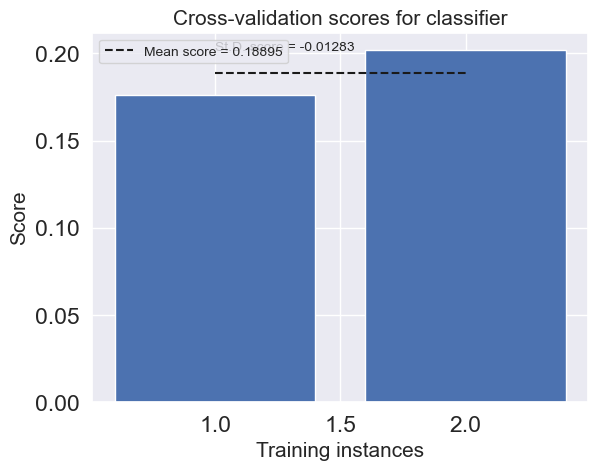

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.1 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0


C:\Users\creep\AppData\Local\Temp\ipykernel_26100\3418699461.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['data_{}'.format(sample_values_solution[1])]['lightgbm_score_random'] = lightgbm_grid_random_search.predict_proba(data['data_{}'.format(sample_values_solution[1])][feats_best_lgbm_back].values)[:,1]


In [110]:
import timeit
start = timeit.default_timer()

# 1,536 models in total
grid = {'n_estimators':[50, 100, 200], # Number of trees, 100-500 is usually sufficient
       'max_depth':[2, 5], # Depth of the tree, 5-6 is usually default
       'learning_rate':[0.1, 0.2], # Learing rate. Shrinkage is used for reducing, or shrinking, the impact of each additional fitted 
# base-learner (tree). It reduces the size of incremental steps and thus penalizes the importance of each consecutive iteration. 
# The intuition behind this technique is that it is better to improve a model by taking many small steps than by taking fewer large steps. 
# If one of the boosting iterations turns out to be erroneous, its negative impact can be easily corrected in subsequent steps. 
# High learn rates and especially values close to 1.0 typically result in overfit models with poor performance. 
# Values much smaller than .01 significantly slow down the learning process and might be reserved for overnight runs. 0.10 default
        'min_child_samples': [10, 100], # Minimum number of observations in each leaf, 10 is usually default
        'subsample': [0.95, 1.0], # The fraction of samples from n_estimators
        'colsample_bytree': np.linspace(0.20, 0.23, 2), # Subsample ratio of columns when constructing each tree
        'eval_metric': ['l2'], # If string, it should be a built-in evaluation metric to use
        'boosting_type': ['gbdt'], # ‘gbdt’, traditional Gradient Boosting Decision Tree. ‘dart’, Dropouts meet Multiple Additive Regression Trees. ‘goss’, Gradient-based One-Side Sampling. ‘rf’, Random Forest
        'num_leaves': [30, 35], # Maximum number of tree leaves 
        'bagging_fraction': [0.95, 1.0], # The fraction of observations to be used for each iteration
        'reg_alpha': [0, 0.1], # L1 regularization term on weights
        'reg_lambda': [0, 0.1], # L2 regularization term on weights
        'lambda_l1': [1], # L1 regularization
        'lambda_l2': [0], # L2 regularization
        'importance_type': ['split'], # The type of feature importance to be filled into feature_importances_. If ‘split’, result contains numbers of times the feature is used in a model. If ‘gain’, result contains total gains of splits which use the feature.
        'objective': ['binary'] # Specify the learning task and the corresponding learning objective
       }

lightgbm_grid_random_search = mb.grid_search_cv(
    n_splits = 2, # Number of cross-validation splits
    classifier = LGBMClassifier, # Classifier name, e.g. RandomForestClassifier
    keras_function = None, # Define Keras function. If Keras is not used, then leave this parameter blank
    grid_params = grid, # Grid space
    dev_df = data['data_{}'.format(sample_values_solution[0])],  # Development sample that this will analysis will be performed
    feats = feats_best_lgbm_back, # List of predictor names
    target = target_variable_name, # Target variable name
    weight_variable = weight_variable_name, # Weight variable name
    randomized_search = True, # Set to True if randomized grid search will be performed, or to False if exhaustive grid search will be performed
    n_random_grids = 100, # Number of grid searches when randomized_search=True. If randomized_search=False, then this parameter is not applicable
    random_state = None, # If int, random_state is the seed used by the random number generator; If RandomState instance, random_state is the random number generator; If None, the random number generator is the RandomState instance used by np.random.
    n_jobs = 8 # Number of jobs to run in parallel
)

stop = timeit.default_timer()
print('Execution time in seconds: ', stop - start)  
#Execution time in seconds:  6.438787699999921

# Save the best parameters
opt_params_random = lightgbm_grid_random_search.best_params_
print('The best hyperparameter set is:', opt_params_random)
print('Mean loss function for cross-validation test data: ', -lightgbm_grid_random_search.cv_results_['mean_test_score'][lightgbm_grid_random_search.best_index_])
print('Standard deviation loss function for cross-validation test data: ', lightgbm_grid_random_search.cv_results_['std_test_score'][lightgbm_grid_random_search.best_index_])
#print('Mean Gini for OOT data', 2*lightgbm_grid_random_search.score(oos[feats_best_lgbm_back], oos[target_variable_name])-1)

ev.plot_cross_validation_score(model=lightgbm_grid_random_search)

# Compute the score for the OOT data
data['data_{}'.format(sample_values_solution[1])]['lightgbm_score_random'] = lightgbm_grid_random_search.predict_proba(data['data_{}'.format(sample_values_solution[1])][feats_best_lgbm_back].values)[:,1]

### Grid search based on GridSearchCV - also uses cross-validation

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=0.95 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=0.95 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Info] Number of positive: 1436, number of negative: 5615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[

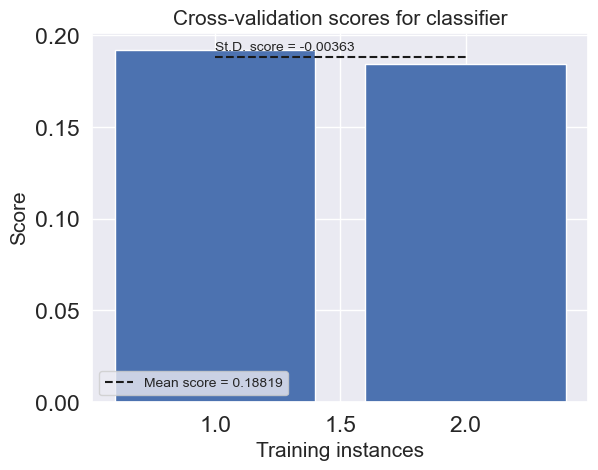

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=0.95 will be ignored. Current value: bagging_fraction=0.95


C:\Users\creep\AppData\Local\Temp\ipykernel_26100\3094938159.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['data_{}'.format(sample_values_solution[1])]['lightgbm_score_fixed'] = lightgbm_grid_fixed_search.predict_proba(data['data_{}'.format(sample_values_solution[1])][feats_best_lgbm_back].values)[:, 1]


In [111]:
import timeit
start = timeit.default_timer()

# 1,536 models in total
grid = {'n_estimators':[50, 100, 200], # Number of trees, 100-500 is usually sufficient
       'max_depth':[2, 5], # Depth of the tree, 5-6 is usually default
       'learning_rate':[0.1, 0.2], # Learing rate. Shrinkage is used for reducing, or shrinking, the impact of each additional fitted 
# base-learner (tree). It reduces the size of incremental steps and thus penalizes the importance of each consecutive iteration. 
# The intuition behind this technique is that it is better to improve a model by taking many small steps than by taking fewer large steps. 
# If one of the boosting iterations turns out to be erroneous, its negative impact can be easily corrected in subsequent steps. 
# High learn rates and especially values close to 1.0 typically result in overfit models with poor performance. 
# Values much smaller than .01 significantly slow down the learning process and might be reserved for overnight runs. 0.10 default
        'min_child_samples': [10, 100], # Minimum number of observations in each leaf, 10 is usually default
        'subsample': [0.95, 1.0], # The fraction of samples from n_estimators
        'colsample_bytree': np.linspace(0.20, 0.23, 2), # Subsample ratio of columns when constructing each tree
        'eval_metric': ['l2'], # If string, it should be a built-in evaluation metric to use
        'boosting_type': ['gbdt'], # ‘gbdt’, traditional Gradient Boosting Decision Tree. ‘dart’, Dropouts meet Multiple Additive Regression Trees. ‘goss’, Gradient-based One-Side Sampling. ‘rf’, Random Forest
        'num_leaves': [30, 35], # Maximum number of tree leaves 
        'bagging_fraction': [0.95, 1.0], # The fraction of observations to be used for each iteration
        'reg_alpha': [0, 0.1], # L1 regularization term on weights
        'reg_lambda': [0, 0.1], # L2 regularization term on weights
        'lambda_l1': [1], # L1 regularization
        'lambda_l2': [0], # L2 regularization
        'importance_type': ['split'], # The type of feature importance to be filled into feature_importances_. If ‘split’, result contains numbers of times the feature is used in a model. If ‘gain’, result contains total gains of splits which use the feature.
        'objective': ['binary'] # Specify the learning task and the corresponding learning objective
       }

lightgbm_grid_fixed_search = mb.grid_search_cv(
    n_splits = 2, # Number of cross-validation splits
    classifier = LGBMClassifier, # Classifier name, e.g. RandomForestClassifier
    keras_function = None, # Define Keras function. If Keras is not used, then leave this parameter blank
    grid_params = grid, # Grid space
    dev_df = data['data_{}'.format(sample_values_solution[0])],  # Development sample that this will analysis will be performed
    feats = feats_best_lgbm_back, # List of predictor names
    target = target_variable_name, # Target variable name
    weight_variable = weight_variable_name, # Weight variable name
    randomized_search = False, # Set to True if randomized grid search will be performed, or to False if exhaustive grid search will be performed
    n_random_grids = 1, # Number of grid searches when randomized_search=True. If randomized_search=False, then this parameter is not applicable
    random_state = None, # If int, random_state is the seed used by the random number generator; If RandomState instance, random_state is the random number generator; If None, the random number generator is the RandomState instance used by np.random.
    n_jobs = 8 # Number of jobs to run in parallel
)

stop = timeit.default_timer()
print('Execution time in seconds: ', stop - start)  
#Execution time in seconds:  111.53426379999996

# Save the best parameters
opt_params_fixed = lightgbm_grid_fixed_search.best_params_
print('The best hyperparameter set is:', opt_params_fixed)
print('Mean loss function for cross-validation test data: ', -lightgbm_grid_fixed_search.cv_results_['mean_test_score'][lightgbm_grid_fixed_search.best_index_])
print('Standard deviation loss function for cross-validation test data: ', lightgbm_grid_fixed_search.cv_results_['std_test_score'][lightgbm_grid_fixed_search.best_index_])
#print('Mean Gini for OOT data', 2*lightgbm_grid_fixed_search.score(oos[feats_best_lgbm_back], oos[target_variable_name], sample_weight=oos[weight_variable_name])-1)

ev.plot_cross_validation_score(model=lightgbm_grid_fixed_search)

# Compute the score for the OOT data
data['data_{}'.format(sample_values_solution[1])]['lightgbm_score_fixed'] = lightgbm_grid_fixed_search.predict_proba(data['data_{}'.format(sample_values_solution[1])][feats_best_lgbm_back].values)[:, 1]

## Calculate lightGBM feature importance

In [112]:
# Define the lightGBM model
opt_params = opt_params_random
lightgbm_classifier = LGBMClassifier(n_estimators=[x[1] for x in list(opt_params.items()) if x[0]=='n_estimators'][0], 
                                 max_depth=[x[1] for x in list(opt_params.items()) if x[0]=='max_depth'][0], 
                                 learning_rate=[x[1] for x in list(opt_params.items()) if x[0]=='learning_rate'][0], 
                                 min_child_samples=[x[1] for x in list(opt_params.items()) if x[0]=='min_child_samples'][0], 
                                 subsample=[x[1] for x in list(opt_params.items()) if x[0]=='subsample'][0], 
                                 colsample_bytree=[x[1] for x in list(opt_params.items()) if x[0]=='colsample_bytree'][0], 
                                 eval_metric=[x[1] for x in list(opt_params.items()) if x[0]=='eval_metric'][0], 
                                 boosting_type=[x[1] for x in list(opt_params.items()) if x[0]=='boosting_type'][0], 
                                 num_leaves=[x[1] for x in list(opt_params.items()) if x[0]=='num_leaves'][0], 
                                 bagging_fraction=[x[1] for x in list(opt_params.items()) if x[0]=='bagging_fraction'][0], 
                                 reg_alpha=[x[1] for x in list(opt_params.items()) if x[0]=='reg_alpha'][0], 
                                 reg_lambda=[x[1] for x in list(opt_params.items()) if x[0]=='reg_lambda'][0], 
                                 lambda_l1=[x[1] for x in list(opt_params.items()) if x[0]=='lambda_l1'][0], 
                                 lambda_l2=[x[1] for x in list(opt_params.items()) if x[0]=='lambda_l2'][0], 
                                 importance_type=[x[1] for x in list(opt_params.items()) if x[0]=='importance_type'][0], 
                                 objective=[x[1] for x in list(opt_params.items()) if x[0]=='objective'][0], 
                                 random_state=1234, 
                                 n_jobs=6)

# Train the model
lightgbm_model = mb.fit_model_weight(data['data_{}'.format(sample_values_solution[0])], feats_best_lgbm_back, target_variable_name, weight_variable_name, lightgbm_classifier, 'lgbm.pkl')

# Calculate feature importance
feat_imprtnce_dictnry_lgbm = mb.feature_imp(lightgbm_model, feats_best_lgbm_back)
for key, value in sorted(feat_imprtnce_dictnry_lgbm.items(), key=lambda item: item[1], reverse=True):
    print("%s: %s" % (key, value))

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.1 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.1 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Info] Number of positive: 1436, number of negative: 5615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[Li

## Calculate lightGBM log-loss

In [113]:
from sklearn.metrics import log_loss
print ("log-loss_iterative")
print(log_loss(y_true=data['data_{}'.format(sample_values_solution[1])][target_variable_name].values, y_pred=data['data_{}'.format(sample_values_solution[1])]['lightgbm_score_iterative'].values, sample_weight=data['data_{}'.format(sample_values_solution[1])][weight_variable_name].values, eps=1e-15))
print ("log-loss_fixed")
print(log_loss(y_true=data['data_{}'.format(sample_values_solution[1])][target_variable_name].values, y_pred=data['data_{}'.format(sample_values_solution[1])]['lightgbm_score_fixed'].values, sample_weight=data['data_{}'.format(sample_values_solution[1])][weight_variable_name].values, eps=1e-15))
print ("log-loss_random")
print(log_loss(y_true=data['data_{}'.format(sample_values_solution[1])][target_variable_name].values, y_pred=data['data_{}'.format(sample_values_solution[1])]['lightgbm_score_random'].values, sample_weight=data['data_{}'.format(sample_values_solution[1])][weight_variable_name].values, eps=1e-15))

log-loss_iterative
0.12916810679146176
log-loss_fixed
0.16160841777702642
log-loss_random
0.16160841777702642


## Calculate lightGBM Precision/Recall Area Under the Curve

In [114]:
print ("precision_recall_auc_iterative")
print(ev.auc_precision_recall(table_name=data['data_{}'.format(sample_values_solution[1])], target_variable=target_variable_name, predicted_variable='lightgbm_score_iterative', 
                            weight_variable=weight_variable_name))
print ("precision_recall_auc_fixed")
print(ev.auc_precision_recall(table_name=data['data_{}'.format(sample_values_solution[1])], target_variable=target_variable_name, predicted_variable='lightgbm_score_fixed', 
                            weight_variable=weight_variable_name))
print ("precision_recall_auc_random")
print(ev.auc_precision_recall(table_name=data['data_{}'.format(sample_values_solution[1])], target_variable=target_variable_name, predicted_variable='lightgbm_score_random', 
                            weight_variable=weight_variable_name))

precision_recall_auc_iterative
0.9531874004926034
precision_recall_auc_fixed
0.9318744038998065
precision_recall_auc_random
0.9318744038998065


## Calculate lightGBM Gini, for the top population

In [115]:
print ("unit_gini_iterative")
print(ev.calculate_gini(
    table_name=data['data_{}'.format(sample_values_solution[1])], # Table name
    target_variable=target_variable_name, # Target variable name
    predicted_variable='lightgbm_score_iterative', # Predicted variable name
    weight_variable=weight_variable_name, # Weight variable name
    select_top_percent=100 # Percent between 0 and 100: Gini is calculated for the top select_top_percent% of the observations, sorted by score
    ))
print ("unit_gini_fixed")
print(ev.calculate_gini(
    table_name=data['data_{}'.format(sample_values_solution[1])], # Table name
    target_variable=target_variable_name, # Target variable name
    predicted_variable='lightgbm_score_fixed', # Predicted variable name
    weight_variable=weight_variable_name, # Weight variable name
    select_top_percent=100 # Percent between 0 and 100: Gini is calculated for the top select_top_percent% of the observations, sorted by score
    ))
print ("unit_gini_random")
print(ev.calculate_gini(
    table_name=data['data_{}'.format(sample_values_solution[1])], # Table name
    target_variable=target_variable_name, # Target variable name
    predicted_variable='lightgbm_score_random', # Predicted variable name
    weight_variable=weight_variable_name, # Weight variable name
    select_top_percent=100 # Percent between 0 and 100: Gini is calculated for the top select_top_percent% of the observations, sorted by score
    ))

unit_gini_iterative
calculate_gini took 0.01 seconds
0.9637242275116549
unit_gini_fixed
calculate_gini took 0.01 seconds
0.9397641251946696
unit_gini_random
calculate_gini took 0.0 seconds
0.9397641251946696


## Calculate lightGBM Lifting table

In [116]:
# Lifting table
lt_lgbm_iterative = ev.lift_table_weight(data['data_{}'.format(sample_values_solution[1])][['lightgbm_score_iterative', target_variable_name, amount_variable_name, weight_variable_name]].values, n_bands=10, rows=10).round(decimals=3)
lt_lgbm_fixed = ev.lift_table_weight(data['data_{}'.format(sample_values_solution[1])][['lightgbm_score_fixed', target_variable_name, amount_variable_name, weight_variable_name]].values, n_bands=10, rows=10).round(decimals=3)
lt_lgbm_random = ev.lift_table_weight(data['data_{}'.format(sample_values_solution[1])][['lightgbm_score_random', target_variable_name, amount_variable_name, weight_variable_name]].values, n_bands=10, rows=10).round(decimals=3)
lt_lgbm_random

lift_table_weight took 0.01 seconds
lift_table_weight took 0.01 seconds
lift_table_weight took 0.01 seconds


Quantile Unit  # Cases  # Responses  Cumulative # Responses  % Response  \
0          0.100  147.145      145.412                 145.412       0.988   
1          0.200  147.914      114.737                 260.150       0.776   
2          0.300  147.636       22.501                 282.651       0.152   
3          0.399  147.651       10.343                 292.994       0.070   
4          0.500  148.493        4.899                 297.893       0.033   
5          0.600  147.533        1.887                 299.781       0.013   
6          0.700  147.879        0.879                 300.659       0.006   
7          0.800  147.527        1.518                 302.177       0.010   
8          0.900  148.227        0.000                 302.177       0.000   
9          1.000  147.840        0.811                 302.988       0.005   

            FPR  Cumulative FPR    ADR  Cumulative ADR   Lift  \
0  1.200000e-02           0.012  0.480           0.480  4.820   
1  2.890000e-01           0.134  0.379           0.859  3.784   
2  5.561000e+00           0.566  0.074           0.933  0.743   
3  1.327500e+01           1.015  0.034           0.967  0.342   
4  2.931200e+01           1.480  0.016           0.983  0.161   
5  7.716800e+01           1.957  0.006           0.989  0.062   
6  1.672940e+02           2.440  0.003           0.992  0.029   
7  9.621000e+01           2.911  0.005           0.997  0.050   
8  1.000000e+09           3.401  0.000           0.997  0.000   
9  1.813310e+02           3.878  0.003           1.000  0.027   

   Cumulative Lift  Quantile Value        Value  Cumulative Value    VDR  \
0            4.820           0.100  1486372.227       1486372.227  0.486   
1            4.301           0.200  1129129.837       2615502.063  0.370   
2            3.114           0.300   235114.652       2850616.716  0.077   
3            2.421           0.399   108475.519       2959092.235  0.036   
4            1.967           0.500    48278.441       3007370.676  0.016   
5            1.650           0.600    21215.729       3028586.405  0.007   
6            1.418           0.700     7298.337       3035884.742  0.002   
7            1.247           0.800    11617.143       3047501.885  0.004   
8            1.108           0.900        0.000       3047501.885  0.000   
9            1.000           1.000     8005.445       3055507.330  0.003   

   Cumulative VDR  
0           0.486  
1           0.856  
2           0.933  
3           0.968  
4           0.984  
5           0.991  
6           0.994  
7           0.997  
8           0.997  
9           1.000

## Plots lightGBM

### Plot lightGBM Detection rate vs. Population Distribution

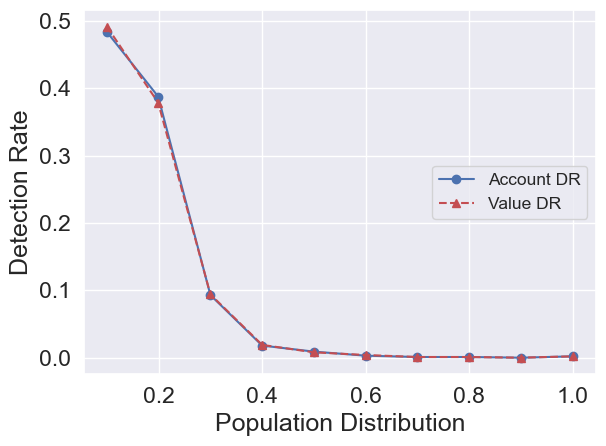

plot_ADR_Quantile took 0.27 seconds


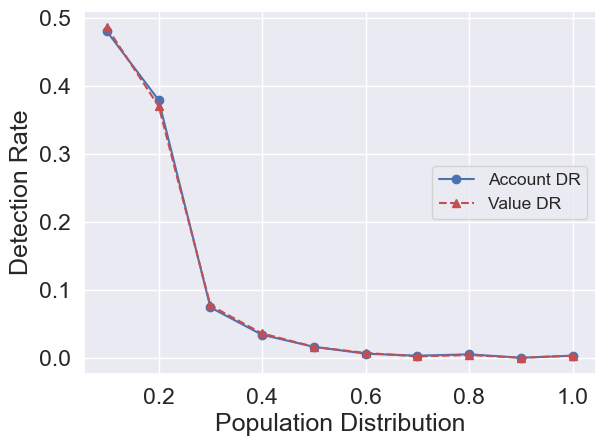

plot_ADR_Quantile took 0.24 seconds


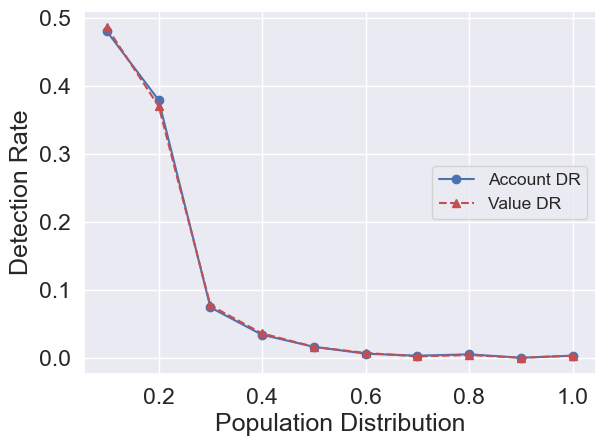

plot_ADR_Quantile took 0.21 seconds


In [117]:
ev.plot_ADR_Quantile(lt_lgbm_iterative)
ev.plot_ADR_Quantile(lt_lgbm_fixed)
ev.plot_ADR_Quantile(lt_lgbm_random)

### Plot lightGBM Cum. Detection rate vs. Population Distribution (Gains chart)

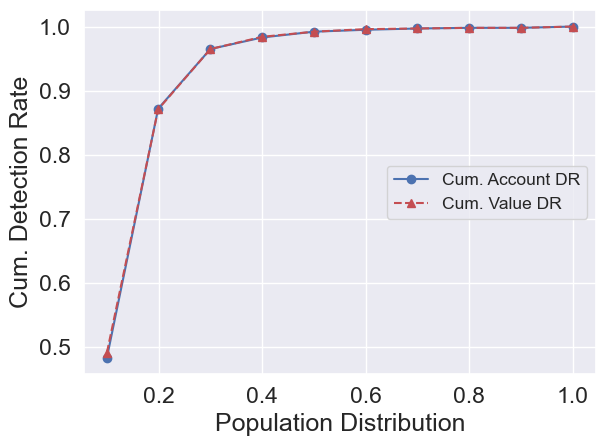

plot_cADR_Quantile took 0.24 seconds


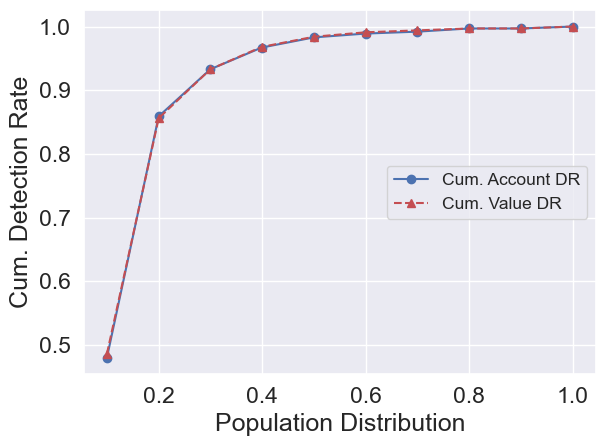

plot_cADR_Quantile took 0.2 seconds


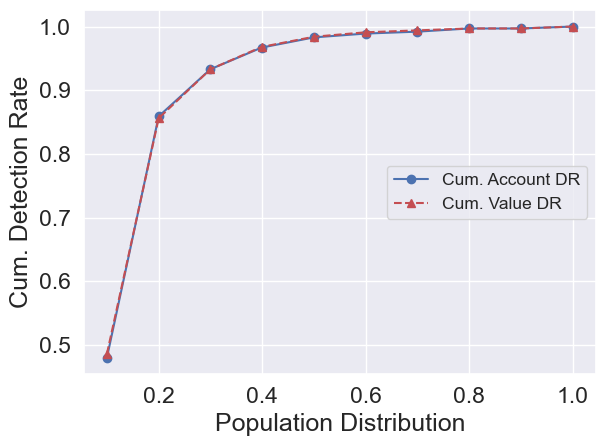

plot_cADR_Quantile took 0.22 seconds


In [118]:
ev.plot_cADR_Quantile(lt_lgbm_iterative)
ev.plot_cADR_Quantile(lt_lgbm_fixed)
ev.plot_cADR_Quantile(lt_lgbm_random)

### Plot lightGBM FPR vs. Population Distribution

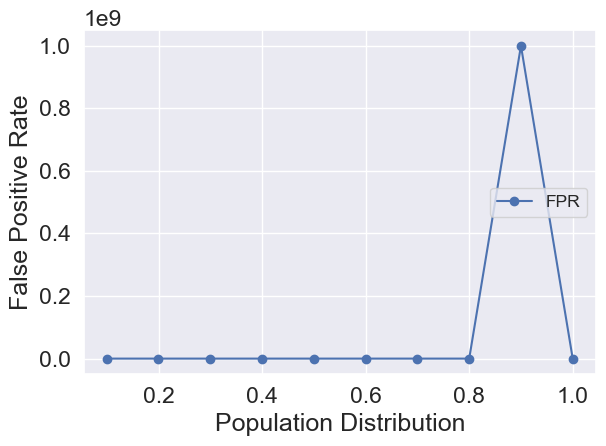

plot_FPR_Quantile took 0.23 seconds


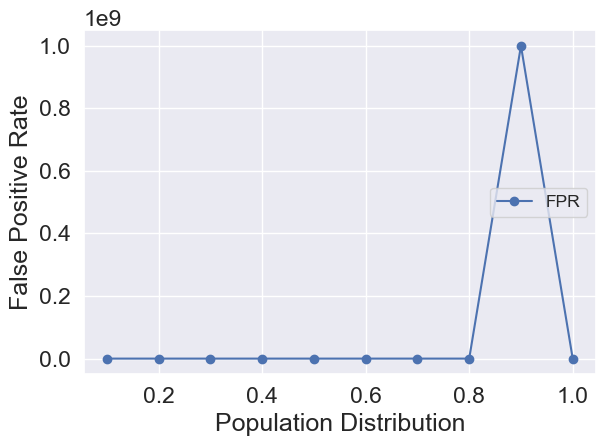

plot_FPR_Quantile took 0.2 seconds


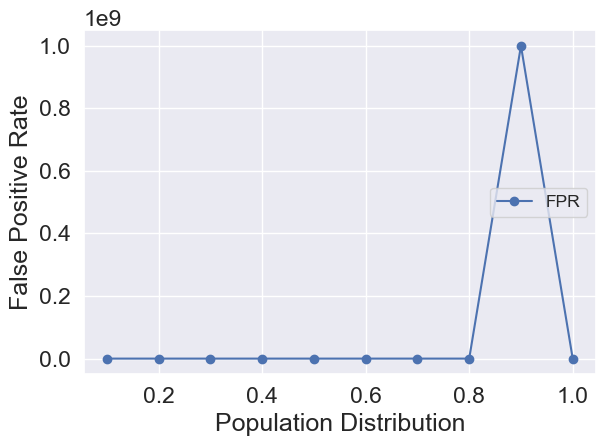

plot_FPR_Quantile took 0.24 seconds


In [119]:
ev.plot_FPR_Quantile(lt_lgbm_iterative)
ev.plot_FPR_Quantile(lt_lgbm_fixed)
ev.plot_FPR_Quantile(lt_lgbm_random)

### Plot lightGBM Cum. FPR vs. Population Distribution

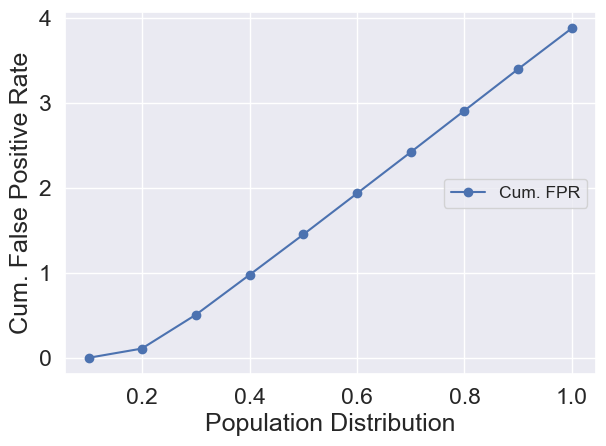

plot_cFPR_Quantile took 0.21 seconds


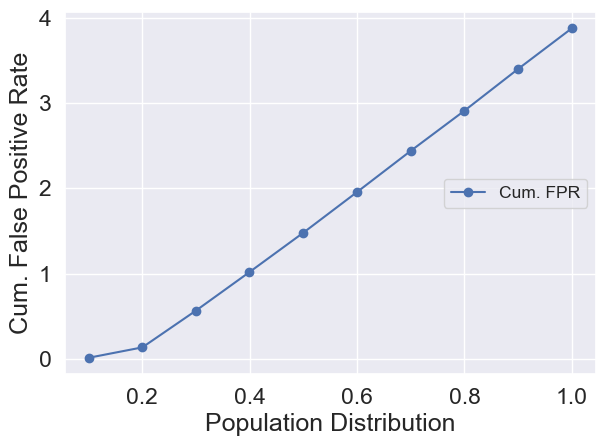

plot_cFPR_Quantile took 0.2 seconds


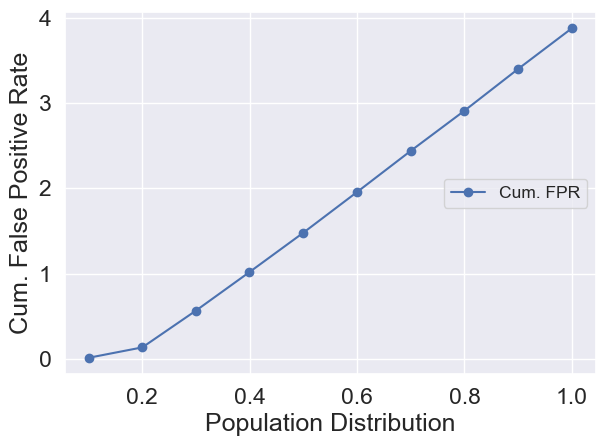

plot_cFPR_Quantile took 0.2 seconds


In [120]:
ev.plot_cFPR_Quantile(lt_lgbm_iterative)
ev.plot_cFPR_Quantile(lt_lgbm_fixed)
ev.plot_cFPR_Quantile(lt_lgbm_random)

### Plot lightGBM ROC curve

Random: ROC AUC=0.500
Model: ROC AUC=0.982


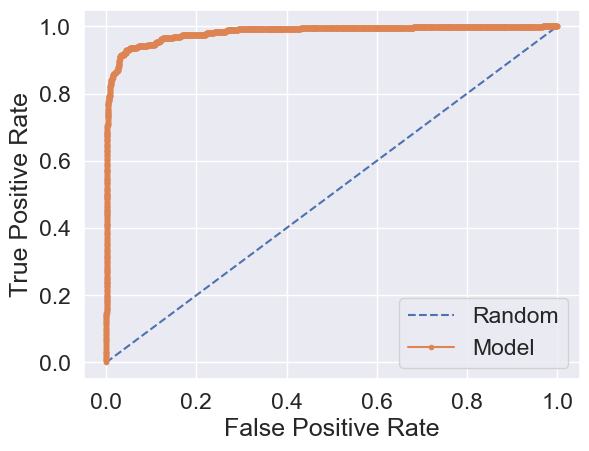

plot_ROC_curve took 0.22 seconds
Random: ROC AUC=0.500
Model: ROC AUC=0.970


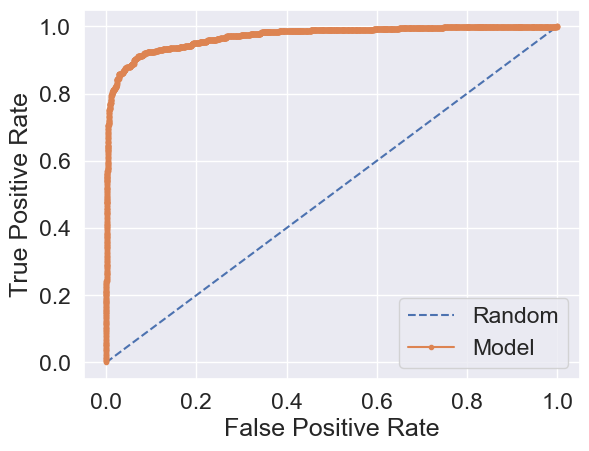

plot_ROC_curve took 0.21 seconds
Random: ROC AUC=0.500
Model: ROC AUC=0.970


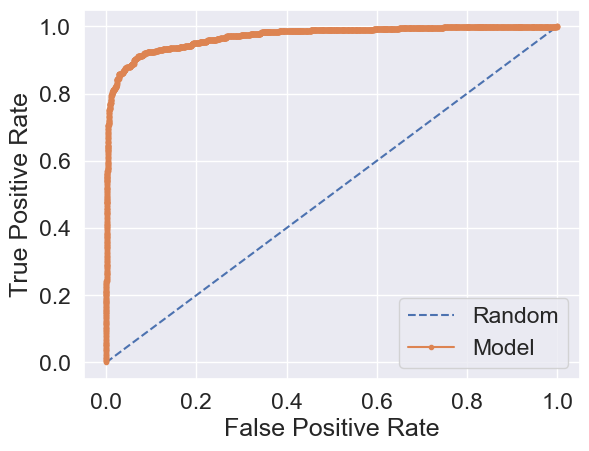

plot_ROC_curve took 0.21 seconds


In [121]:
ev.plot_ROC_curve(table_name=data['data_{}'.format(sample_values_solution[1])], target_variable=target_variable_name, predicted_variable='lightgbm_score_iterative', weight_variable=weight_variable_name) 
ev.plot_ROC_curve(table_name=data['data_{}'.format(sample_values_solution[1])], target_variable=target_variable_name, predicted_variable='lightgbm_score_fixed', weight_variable=weight_variable_name) 
ev.plot_ROC_curve(table_name=data['data_{}'.format(sample_values_solution[1])], target_variable=target_variable_name, predicted_variable='lightgbm_score_random', weight_variable=weight_variable_name) 

### Plot lightGBM Precision Recall curve

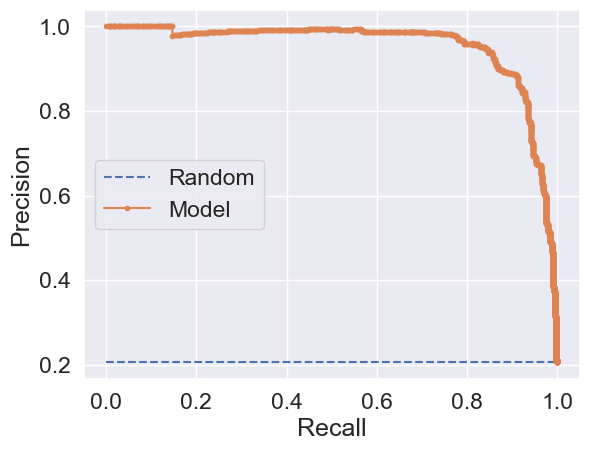

plot_precision_recall_curve took 0.22 seconds


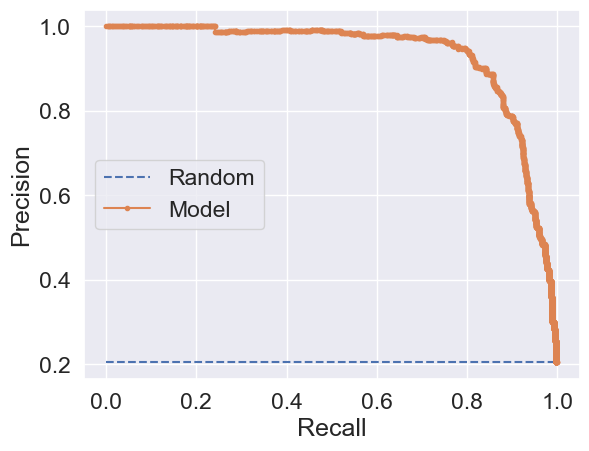

plot_precision_recall_curve took 0.19 seconds


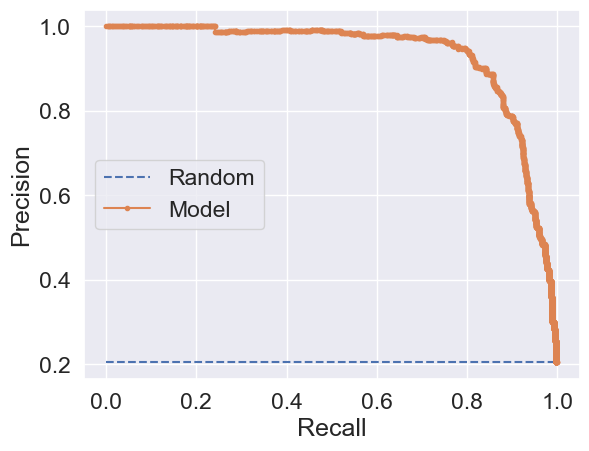

plot_precision_recall_curve took 0.22 seconds


In [122]:
ev.plot_precision_recall_curve(table_name=data['data_{}'.format(sample_values_solution[1])], target_variable=target_variable_name, predicted_variable='lightgbm_score_iterative', 
                            weight_variable=weight_variable_name)
ev.plot_precision_recall_curve(table_name=data['data_{}'.format(sample_values_solution[1])], target_variable=target_variable_name, predicted_variable='lightgbm_score_fixed', 
                            weight_variable=weight_variable_name)
ev.plot_precision_recall_curve(table_name=data['data_{}'.format(sample_values_solution[1])], target_variable=target_variable_name, predicted_variable='lightgbm_score_random', 
                            weight_variable=weight_variable_name)  

### Plot lightGBM F1 score, Accuracy, Sensitivity, Specificity, Precision vs Cutoff

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\evaluation.py:575: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  
C:\Users\creep\Anaconda\Sotiris_Solutions\functions\evaluation.py:571: RuntimeWarning: invalid value encountered in double_scalars
  if sys.version_info[0] < 2:


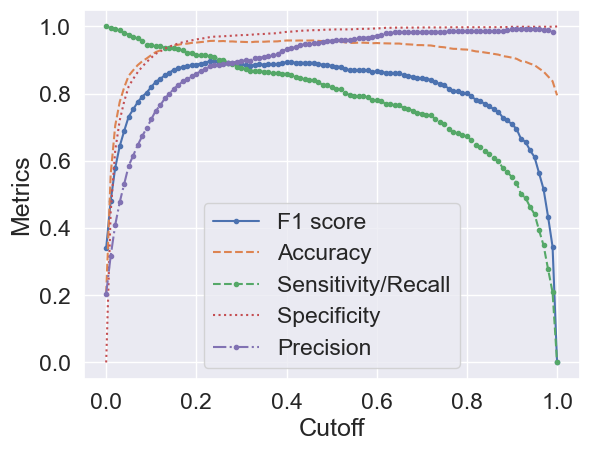

plot_cutoffs took 0.53 seconds


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\evaluation.py:575: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  
C:\Users\creep\Anaconda\Sotiris_Solutions\functions\evaluation.py:571: RuntimeWarning: invalid value encountered in double_scalars
  if sys.version_info[0] < 2:


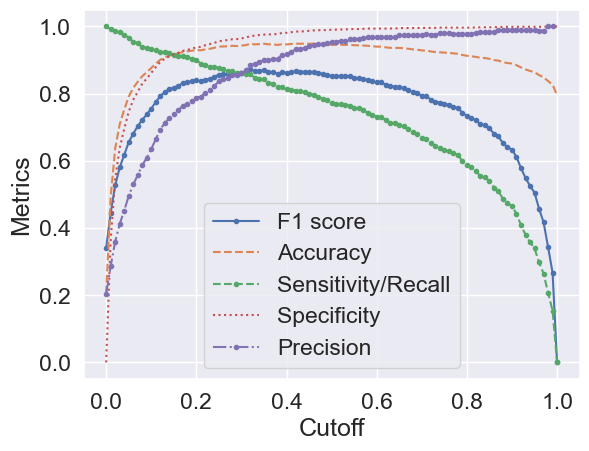

plot_cutoffs took 0.55 seconds


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\evaluation.py:575: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  
C:\Users\creep\Anaconda\Sotiris_Solutions\functions\evaluation.py:571: RuntimeWarning: invalid value encountered in double_scalars
  if sys.version_info[0] < 2:


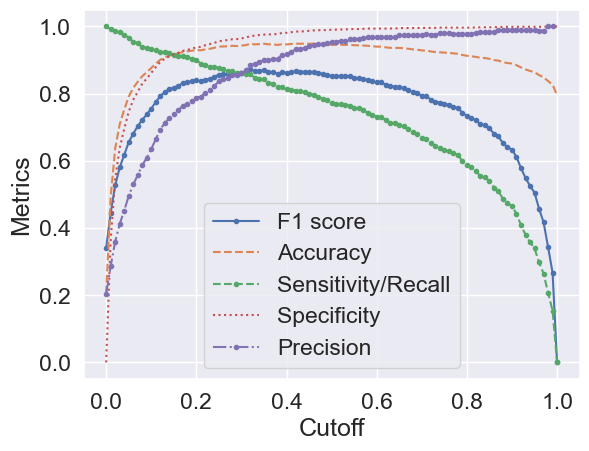

plot_cutoffs took 0.54 seconds


In [123]:
ev.plot_cutoffs(table_name=data['data_{}'.format(sample_values_solution[1])], target_variable=target_variable_name, predicted_variable='lightgbm_score_iterative', 
                            weight_variable=weight_variable_name, n_bands=100, return_table=False)
ev.plot_cutoffs(table_name=data['data_{}'.format(sample_values_solution[1])], target_variable=target_variable_name, predicted_variable='lightgbm_score_fixed', 
                            weight_variable=weight_variable_name, n_bands=100, return_table=False)
ev.plot_cutoffs(table_name=data['data_{}'.format(sample_values_solution[1])], target_variable=target_variable_name, predicted_variable='lightgbm_score_random', 
                            weight_variable=weight_variable_name, n_bands=100, return_table=False)

# Keras NN

## Feature selection Keras Neural Network

### First find neural network hyperparameters for a decent network using RandomizedSearchCV, then select the top variables based on that network

In [127]:
import math
from keras.wrappers.scikit_learn import KerasClassifier

grid = [
# SGD optimizer
    {
    'num_neurons': [math.floor((len(keep_num_vars_gini)+1)/2)]
    , 'num_hidden_layers': [1, 2]
    , 'input_dim': [data['data_{}'.format(sample_values_solution[0])][keep_num_vars_gini].shape[1]]
    , 'kernel_initializer': ['normal', 'uniform']
    , 'activation': ['relu', 'elu', 'linear', 'softplus']
    , 'kernel_constraint': [0,1,2,3,4,5]
    , 'dropout_rate': [0, 0.25, 0.5, 0.75]
    , 'output_kernel_initializer': ['uniform']
    , 'output_activation': ['sigmoid']
    , 'loss': ['binary_crossentropy']
    , 'optimizer': ['SGD']
    , 'learning_rate': [0.01, 0.001, 0.10, 0.30]
    , 'momentum': [0.0, 0.25, 0.5]
    , 'rho': [99999]
    , 'beta_1': [99999]
    , 'beta_2': [99999]
    , 'return_metrics': ['False']
    , 'batch_size': [None, 32, 64, 128]
    , 'epochs': [1, 10, 100, 500, 1000]
},
# Adadelta optimizer
    {
    'num_neurons': [math.floor((len(keep_num_vars_gini)+1)/2)]
    , 'num_hidden_layers': [1, 2]
    , 'input_dim': [data['data_{}'.format(sample_values_solution[0])][keep_num_vars_gini].shape[1]]
    , 'kernel_initializer': ['normal', 'uniform']
    , 'activation': ['relu', 'elu', 'linear', 'softplus']
    , 'kernel_constraint': [0,1,2,3,4,5]
    , 'dropout_rate': [0, 0.25, 0.5, 0.75]
    , 'output_kernel_initializer': ['uniform']
    , 'output_activation': ['sigmoid']
    , 'loss': ['binary_crossentropy']
    , 'optimizer': ['Adadelta']
    , 'learning_rate': [1, 0.5, 0.7, 0.9]
    , 'momentum': [0.0, 0.25, 0.5]
    , 'rho': [0.95, 0.8, 0.9, 0.99]
    , 'beta_1': [99999]
    , 'beta_2': [99999]
    , 'return_metrics': ['False']
    , 'batch_size': [None, 32, 64, 128]
    , 'epochs': [1, 10, 100, 500, 1000]
}, 
# Adam optimizer
    {
    'num_neurons': [math.floor((len(keep_num_vars_gini)+1)/2)]
    , 'num_hidden_layers': [1, 2]
    , 'input_dim': [data['data_{}'.format(sample_values_solution[0])][keep_num_vars_gini].shape[1]]
    , 'kernel_initializer': ['normal', 'uniform']
    , 'activation': ['relu', 'elu', 'linear', 'softplus']
    , 'kernel_constraint': [0,1,2,3,4,5]
    , 'dropout_rate': [0, 0.25, 0.5, 0.75]
    , 'output_kernel_initializer': ['uniform']
    , 'output_activation': ['sigmoid']
    , 'loss': ['binary_crossentropy']
    , 'optimizer': ['Adam']
    , 'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3]
    , 'momentum': [99999]
    , 'rho': [99999]
    , 'beta_1': [0.9, 0.8, 0.95, 0.99]
    , 'beta_2': [0.999, 0.8, 0.9, 0.95]
    , 'return_metrics': ['False']
    , 'batch_size': [None, 32, 64, 128]
    , 'epochs': [1, 10, 100, 500, 1000]
}, 
# Nadam optimizer
    {
    'num_neurons': [math.floor((len(keep_num_vars_gini)+1)/2)]
    , 'num_hidden_layers': [1, 2]
    , 'input_dim': [data['data_{}'.format(sample_values_solution[0])][keep_num_vars_gini].shape[1]]
    , 'kernel_initializer': ['normal', 'uniform']
    , 'activation': ['relu', 'elu', 'linear', 'softplus']
    , 'kernel_constraint': [0,1,2,3,4,5]
    , 'dropout_rate': [0, 0.25, 0.5, 0.75]
    , 'output_kernel_initializer': ['uniform']
    , 'output_activation': ['sigmoid']
    , 'loss': ['binary_crossentropy']
    , 'optimizer': ['Nadam']
    , 'learning_rate': [0.002, 0.01, 0.1, 0.2]
    , 'momentum': [99999]
    , 'rho': [99999]
    , 'beta_1': [0.9, 0.8, 0.95, 0.99]
    , 'beta_2': [0.999, 0.8, 0.9, 0.95]
    , 'return_metrics': ['False']
    , 'batch_size': [None, 32, 64, 128]
    , 'epochs': [1, 10, 100, 500, 1000]
}, 
# Adamax optimizer
    {
    'num_neurons': [math.floor((len(keep_num_vars_gini)+1)/2)]
    , 'num_hidden_layers': [1, 2]
    , 'input_dim': [data['data_{}'.format(sample_values_solution[0])][keep_num_vars_gini].shape[1]]
    , 'kernel_initializer': ['normal', 'uniform']
    , 'activation': ['relu', 'elu', 'linear', 'softplus']
    , 'kernel_constraint': [0,1,2,3,4,5]
    , 'dropout_rate': [0, 0.25, 0.5, 0.75]
    , 'output_kernel_initializer': ['uniform']
    , 'output_activation': ['sigmoid']
    , 'loss': ['binary_crossentropy']
    , 'optimizer': ['Adamax']
    , 'learning_rate': [0.002, 0.01, 0.1, 0.2]
    , 'momentum': [99999]
    , 'rho': [99999]
    , 'beta_1': [0.9, 0.8, 0.95, 0.99]
    , 'beta_2': [0.999, 0.8, 0.9, 0.95]
    , 'return_metrics': ['False']
    , 'batch_size': [None, 32, 64, 128]
    , 'epochs': [1, 10, 100, 500, 1000]
}
]

params=[{'num_neurons': 4, 'num_hidden_layers': 2, 'input_dim': data['data_{}'.format(sample_values_solution[0])][keep_num_vars_gini].shape[1], 
             'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 
             'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 
             'optimizer': 'SGD', 'learning_rate': 0.01, 'momentum': 0, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 
             'return_metrics': 'False', 'batch_size': None, 'epochs': 1}
        , {'num_neurons': 4, 'num_hidden_layers': 2, 'input_dim': data['data_{}'.format(sample_values_solution[0])][keep_num_vars_gini].shape[1], 
             'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 
             'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 
             'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.0, 'rho': 0.95, 'beta_1': 99999, 'beta_2': 99999, 
             'return_metrics': 'False', 'batch_size': None, 'epochs': 1}
        , {'num_neurons': 4, 'num_hidden_layers': 2, 'input_dim': data['data_{}'.format(sample_values_solution[0])][keep_num_vars_gini].shape[1], 
             'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 
             'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 
             'optimizer': 'Adam', 'learning_rate': 0.001, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 
             'return_metrics': 'False', 'batch_size': None, 'epochs': 1}
        , {'num_neurons': 4, 'num_hidden_layers': 2, 'input_dim': data['data_{}'.format(sample_values_solution[0])][keep_num_vars_gini].shape[1], 
                     'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 
                     'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 
                     'optimizer': 'Nadam', 'learning_rate': 0.002, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 
                     'return_metrics': 'False', 'batch_size': None, 'epochs': 1}
        , {'num_neurons': 4, 'num_hidden_layers': 2, 'input_dim': data['data_{}'.format(sample_values_solution[0])][keep_num_vars_gini].shape[1], 
                     'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 
                     'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 
                     'optimizer': 'Adamax', 'learning_rate': 0.002, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 
                     'return_metrics': 'False', 'batch_size': None, 'epochs': 1}]

In [130]:
import timeit
start = timeit.default_timer()

opt_params_dict, loss_dict = mb.step_search_weight(estimator=KerasClassifier, params=params, grid=grid, target=target_variable_name,
    weight=weight_variable_name, dev=data['data_{}'.format(sample_values_solution[0])], val=data['data_{}'.format(sample_values_solution[1])], keep=keep_num_vars_gini)

print('\n Best Parameters for each optimizer')
print(opt_params_dict)
print(loss_dict)

loss = loss_dict[loss_dict.index(min(loss_dict))]
opt_params = opt_params_dict[loss_dict.index(min(loss_dict))]
print('\n Best Parameters')
print(opt_params)
print(loss)

stop = timeit.default_timer()
print('Execution time in seconds: ', stop - start)  
#Execution time in seconds:  2544.1952324999997

Search Progress:
93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.1, 'momentum': 0.5, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': 64, 'epochs': 500} num_neurons 12 0.20763128907596132 0.20763128907596132



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.1, 'momentum': 0.5, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': 64, 'epochs': 500} num_hidden_layers 1 0.194112562220025 0.194112562220025


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.1, 'momentum': 0.5, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': 64, 'epochs': 500} num_hidden_layers 2 0.229260353373369 0.194112562220025



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.1, 'momentum': 0.5, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': 64, 'epochs': 500} input_dim 24 0.27063558183008357 0.194112562220025



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 954us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.1, 'momentum': 0.5, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': 64, 'epochs': 500} kernel_initializer normal 0.21198256966339618 0.194112562220025


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.1, 'momentum': 0.5, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': 64, 'epochs': 500} kernel_initializer uniform 0.2401688866567338 0.194112562220025



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.1, 'momentum': 0.5, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': 64, 'epochs': 500} activation relu 0.2382706272729579 0.194112562220025


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.1, 'momentum': 0.5, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': 64, 'epochs': 500} activation elu 0.2142182115791558 0.194112562220025


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 955us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.1, 'momentum': 0.5, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': 64, 'epochs': 500} activation linear 0.25534880023158757 0.194112562220025


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 956us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.1, 'momentum': 0.5, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': 64, 'epochs': 500} activation softplus 0.1979219359486757 0.194112562220025



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.1, 'momentum': 0.5, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': 64, 'epochs': 500} kernel_constraint 0 0.5072831091899834 0.194112562220025


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.1, 'momentum': 0.5, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': 64, 'epochs': 500} kernel_constraint 1 0.31320505558325706 0.194112562220025


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.1, 'momentum': 0.5, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': 64, 'epochs': 500} kernel_constraint 2 0.24621628977940807 0.194112562220025


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.1, 'momentum': 0.5, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': 64, 'epochs': 500} kernel_constraint 3 0.22936049025712107 0.194112562220025


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 4, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.1, 'momentum': 0.5, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': 64, 'epochs': 500} kernel_constraint 4 0.1884393923278242 0.1884393923278242


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 5, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.1, 'momentum': 0.5, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': 64, 'epochs': 500} kernel_constraint 5 0.1676699208474473 0.1676699208474473



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 5, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.1, 'momentum': 0.5, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': 64, 'epochs': 500} dropout_rate 0 0.17716185974146387 0.1676699208474473


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 967us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 5, 'dropout_rate': 0.25, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.1, 'momentum': 0.5, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': 64, 'epochs': 500} dropout_rate 0.25 0.15461720730370618 0.15461720730370618


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 5, 'dropout_rate': 0.25, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.1, 'momentum': 0.5, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': 64, 'epochs': 500} dropout_rate 0.5 0.15911646963779855 0.15461720730370618


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 899us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 5, 'dropout_rate': 0.25, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.1, 'momentum': 0.5, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': 64, 'epochs': 500} dropout_rate 0.75 0.2002187472385266 0.15461720730370618



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 5, 'dropout_rate': 0.25, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.1, 'momentum': 0.5, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': 64, 'epochs': 500} output_kernel_initializer uniform 0.14579496012604154 0.14579496012604154



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 962us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 5, 'dropout_rate': 0.25, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.1, 'momentum': 0.5, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': 64, 'epochs': 500} output_activation sigmoid 0.1452871915405715 0.1452871915405715



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 930us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 5, 'dropout_rate': 0.25, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.1, 'momentum': 0.5, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': 64, 'epochs': 500} loss binary_crossentropy 0.14611033049935718 0.1452871915405715



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 5, 'dropout_rate': 0.25, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.1, 'momentum': 0.5, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': 64, 'epochs': 500} optimizer SGD 0.13606510930407376 0.13606510930407376



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 921us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 5, 'dropout_rate': 0.25, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.01, 'momentum': 0.5, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': 64, 'epochs': 500} learning_rate 0.01 0.12543337514595962 0.12543337514595962


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 5, 'dropout_rate': 0.25, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.01, 'momentum': 0.5, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': 64, 'epochs': 500} learning_rate 0.001 0.1526867867243339 0.12543337514595962


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 867us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 5, 'dropout_rate': 0.25, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.01, 'momentum': 0.5, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': 64, 'epochs': 500} learning_rate 0.1 0.14777733654295883 0.12543337514595962


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 5, 'dropout_rate': 0.25, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.01, 'momentum': 0.5, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': 64, 'epochs': 500} learning_rate 0.3 0.3274405433628001 0.12543337514595962



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 5, 'dropout_rate': 0.25, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.01, 'momentum': 0.0, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': 64, 'epochs': 500} momentum 0.0 0.12407297466607513 0.12407297466607513


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 5, 'dropout_rate': 0.25, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.01, 'momentum': 0.25, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': 64, 'epochs': 500} momentum 0.25 0.12345193422369422 0.12345193422369422


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 809us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 5, 'dropout_rate': 0.25, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.01, 'momentum': 0.5, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': 64, 'epochs': 500} momentum 0.5 0.12333477745870512 0.12333477745870512



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 5, 'dropout_rate': 0.25, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.01, 'momentum': 0.5, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': 64, 'epochs': 500} rho 99999 0.11940449201698498 0.11940449201698498



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 5, 'dropout_rate': 0.25, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.01, 'momentum': 0.5, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': 64, 'epochs': 500} beta_1 99999 0.11827413767207423 0.11827413767207423



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 946us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 5, 'dropout_rate': 0.25, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.01, 'momentum': 0.5, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': 64, 'epochs': 500} beta_2 99999 0.11819710895126459 0.11819710895126459



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 5, 'dropout_rate': 0.25, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.01, 'momentum': 0.5, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': 64, 'epochs': 500} return_metrics False 0.1175011227626248 0.1175011227626248



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 901us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 5, 'dropout_rate': 0.25, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.01, 'momentum': 0.5, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': 64, 'epochs': 500} batch_size None 0.1206875172683139 0.1175011227626248


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 5, 'dropout_rate': 0.25, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.01, 'momentum': 0.5, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': 64, 'epochs': 500} batch_size 32 0.12200912305800043 0.1175011227626248


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 899us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 5, 'dropout_rate': 0.25, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.01, 'momentum': 0.5, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': 64, 'epochs': 500} batch_size 64 0.12095633045245455 0.1175011227626248


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 882us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 5, 'dropout_rate': 0.25, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.01, 'momentum': 0.5, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': 64, 'epochs': 500} batch_size 128 0.13248366261776243 0.1175011227626248



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 874us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 5, 'dropout_rate': 0.25, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.01, 'momentum': 0.5, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': 64, 'epochs': 500} epochs 1 0.5193274564282293 0.1175011227626248


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 904us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 5, 'dropout_rate': 0.25, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.01, 'momentum': 0.5, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': 64, 'epochs': 500} epochs 10 0.2963270120034466 0.1175011227626248


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 5, 'dropout_rate': 0.25, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.01, 'momentum': 0.5, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': 64, 'epochs': 500} epochs 100 0.1864306358526397 0.1175011227626248


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 5, 'dropout_rate': 0.25, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.01, 'momentum': 0.5, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': 64, 'epochs': 500} epochs 500 0.11913305478405689 0.1175011227626248
93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 5, 'dropout_rate': 0.25, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.01, 'momentum': 0.5, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': 64, 'epochs': 1000} epochs 1000 0.11179463628213895 0.

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 5, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.0, 'rho': 0.99, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 500} num_neurons 12 0.13092314697141516 0.13092314697141516



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 870us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 5, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.0, 'rho': 0.99, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 500} num_hidden_layers 1 0.14872416694907292 0.13092314697141516


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 5, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.0, 'rho': 0.99, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 500} num_hidden_layers 2 0.22375265583284512 0.13092314697141516



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 934us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 5, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.0, 'rho': 0.99, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 500} input_dim 24 0.11155082993310296 0.11155082993310296



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 846us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 5, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.0, 'rho': 0.99, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 500} kernel_initializer normal 0.11113652578565553 0.11113652578565553


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 925us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'uniform', 'activation': 'elu', 'kernel_constraint': 5, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.0, 'rho': 0.99, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 500} kernel_initializer uniform 0.10245228667542482 0.10245228667542482



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 789us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'uniform', 'activation': 'elu', 'kernel_constraint': 5, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.0, 'rho': 0.99, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 500} activation relu 0.13968914689450443 0.10245228667542482


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 909us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'uniform', 'activation': 'elu', 'kernel_constraint': 5, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.0, 'rho': 0.99, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 500} activation elu 0.11899044064783705 0.10245228667542482


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 959us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'uniform', 'activation': 'elu', 'kernel_constraint': 5, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.0, 'rho': 0.99, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 500} activation linear 0.2464221233658378 0.10245228667542482


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 840us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'uniform', 'activation': 'elu', 'kernel_constraint': 5, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.0, 'rho': 0.99, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 500} activation softplus 0.10675586624806614 0.10245228667542482



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 953us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'uniform', 'activation': 'elu', 'kernel_constraint': 5, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.0, 'rho': 0.99, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 500} kernel_constraint 0 0.5073021430584977 0.10245228667542482


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'uniform', 'activation': 'elu', 'kernel_constraint': 5, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.0, 'rho': 0.99, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 500} kernel_constraint 1 0.10710756597842203 0.10245228667542482


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 900us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'uniform', 'activation': 'elu', 'kernel_constraint': 5, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.0, 'rho': 0.99, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 500} kernel_constraint 2 0.11077569669369026 0.10245228667542482


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 802us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'uniform', 'activation': 'elu', 'kernel_constraint': 5, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.0, 'rho': 0.99, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 500} kernel_constraint 3 0.12792481378498152 0.10245228667542482


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'uniform', 'activation': 'elu', 'kernel_constraint': 5, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.0, 'rho': 0.99, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 500} kernel_constraint 4 0.11861502969112205 0.10245228667542482


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'uniform', 'activation': 'elu', 'kernel_constraint': 5, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.0, 'rho': 0.99, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 500} kernel_constraint 5 0.13901383463340675 0.10245228667542482



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'uniform', 'activation': 'elu', 'kernel_constraint': 5, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.0, 'rho': 0.99, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 500} dropout_rate 0 0.12518825225264396 0.10245228667542482


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 936us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'uniform', 'activation': 'elu', 'kernel_constraint': 5, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.0, 'rho': 0.99, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 500} dropout_rate 0.25 0.1116532322314619 0.10245228667542482


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'uniform', 'activation': 'elu', 'kernel_constraint': 5, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.0, 'rho': 0.99, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 500} dropout_rate 0.5 0.12076086908569131 0.10245228667542482


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'uniform', 'activation': 'elu', 'kernel_constraint': 5, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.0, 'rho': 0.99, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 500} dropout_rate 0.75 0.17046830939956795 0.10245228667542482



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'uniform', 'activation': 'elu', 'kernel_constraint': 5, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.0, 'rho': 0.99, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 500} output_kernel_initializer uniform 0.11746178260092027 0.10245228667542482



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'uniform', 'activation': 'elu', 'kernel_constraint': 5, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.0, 'rho': 0.99, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 500} output_activation sigmoid 0.11487708156829929 0.10245228667542482



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 941us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'uniform', 'activation': 'elu', 'kernel_constraint': 5, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.0, 'rho': 0.99, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 500} loss binary_crossentropy 0.11338822980944138 0.10245228667542482



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 942us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'uniform', 'activation': 'elu', 'kernel_constraint': 5, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.0, 'rho': 0.99, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 500} optimizer Adadelta 0.13826613709904764 0.10245228667542482



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 955us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'uniform', 'activation': 'elu', 'kernel_constraint': 5, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.0, 'rho': 0.99, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 500} learning_rate 1 0.13605951769334904 0.10245228667542482


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'uniform', 'activation': 'elu', 'kernel_constraint': 5, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.0, 'rho': 0.99, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 500} learning_rate 0.5 0.11507827354177877 0.10245228667542482
93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'uniform', 'activation': 'elu', 'kernel_constraint': 5, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.0, 'rho': 0.99, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 500} learning_rate 0.7 0.11544

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 755us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'uniform', 'activation': 'elu', 'kernel_constraint': 5, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.0, 'rho': 0.99, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 500} learning_rate 0.9 0.11026288206245756 0.10245228667542482



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 806us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'uniform', 'activation': 'elu', 'kernel_constraint': 5, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.0, 'rho': 0.99, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 500} momentum 0.0 0.10953021083667958 0.10245228667542482


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'uniform', 'activation': 'elu', 'kernel_constraint': 5, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.25, 'rho': 0.99, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 500} momentum 0.25 0.09980736150814423 0.09980736150814423


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'uniform', 'activation': 'elu', 'kernel_constraint': 5, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.25, 'rho': 0.99, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 500} momentum 0.5 0.13285984387148683 0.09980736150814423



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 849us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'uniform', 'activation': 'elu', 'kernel_constraint': 5, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.25, 'rho': 0.99, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 500} rho 0.95 0.12119497373236728 0.09980736150814423


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'uniform', 'activation': 'elu', 'kernel_constraint': 5, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.25, 'rho': 0.99, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 500} rho 0.8 0.13651267228079536 0.09980736150814423


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'uniform', 'activation': 'elu', 'kernel_constraint': 5, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.25, 'rho': 0.99, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 500} rho 0.9 0.11984251492078897 0.09980736150814423


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 843us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'uniform', 'activation': 'elu', 'kernel_constraint': 5, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.25, 'rho': 0.99, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 500} rho 0.99 0.10224107169854053 0.09980736150814423



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 759us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'uniform', 'activation': 'elu', 'kernel_constraint': 5, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.25, 'rho': 0.99, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 500} beta_1 99999 0.109619999077913 0.09980736150814423



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 849us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'uniform', 'activation': 'elu', 'kernel_constraint': 5, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.25, 'rho': 0.99, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 500} beta_2 99999 0.11561048089681758 0.09980736150814423



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'uniform', 'activation': 'elu', 'kernel_constraint': 5, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.25, 'rho': 0.99, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 500} return_metrics False 0.1094277963891676 0.09980736150814423



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 849us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'uniform', 'activation': 'elu', 'kernel_constraint': 5, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.25, 'rho': 0.99, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 500} batch_size None 0.13859537279270848 0.09980736150814423


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 851us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'uniform', 'activation': 'elu', 'kernel_constraint': 5, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.25, 'rho': 0.99, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 500} batch_size 32 0.12575761040044772 0.09980736150814423


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'uniform', 'activation': 'elu', 'kernel_constraint': 5, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.25, 'rho': 0.99, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 500} batch_size 64 0.11217720306702239 0.09980736150814423


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'uniform', 'activation': 'elu', 'kernel_constraint': 5, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.25, 'rho': 0.99, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 500} batch_size 128 0.10321785286456626 0.09980736150814423



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'uniform', 'activation': 'elu', 'kernel_constraint': 5, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.25, 'rho': 0.99, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 500} epochs 1 0.24386867463346815 0.09980736150814423


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'uniform', 'activation': 'elu', 'kernel_constraint': 5, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.25, 'rho': 0.99, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 500} epochs 10 0.13161333174560513 0.09980736150814423


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 963us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'uniform', 'activation': 'elu', 'kernel_constraint': 5, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.25, 'rho': 0.99, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 500} epochs 100 0.10788828251417758 0.09980736150814423


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 849us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'uniform', 'activation': 'elu', 'kernel_constraint': 5, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.25, 'rho': 0.99, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 500} epochs 500 0.14201026414796736 0.09980736150814423


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'uniform', 'activation': 'elu', 'kernel_constraint': 5, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.25, 'rho': 0.99, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 500} epochs 1000 0.18825663179928467 0.09980736150814423



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.001, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} num_neurons 12 0.2878853222583765 0.2878853222583765



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 936us/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.001, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} num_hidden_layers 1 0.35893827375497783 0.2878853222583765


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.001, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} num_hidden_layers 2 0.3129226912396313 0.2878853222583765



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.001, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} input_dim 24 0.3234927710621095 0.2878853222583765



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.001, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} kernel_initializer normal 0.31740482115957147 0.2878853222583765


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.001, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} kernel_initializer uniform 0.32656891130113325 0.2878853222583765



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 2ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.001, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} activation relu 0.3129502593531353 0.2878853222583765


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.001, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} activation elu 0.3062563383854718 0.2878853222583765


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 2ms/step


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.001, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} activation linear 0.2846611508889384 0.2846611508889384
93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.001, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} activation softplus 0.339

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 849us/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.001, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} kernel_constraint 0 0.5199633048197391 0.2846611508889384


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.001, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} kernel_constraint 1 0.2930495500589314 0.2846611508889384


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 2ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.001, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} kernel_constraint 2 0.2908053212806761 0.2846611508889384


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 2ms/step


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.001, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} kernel_constraint 3 0.29812297558329975 0.2846611508889384
93/93 [==============================] - 0s 966us/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.001, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} kernel_constraint 4 

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 926us/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.001, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} kernel_constraint 5 0.3017935908925116 0.2846611508889384



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.001, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} dropout_rate 0 0.28380462579350807 0.28380462579350807


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.001, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} dropout_rate 0.25 0.32142568091564744 0.28380462579350807


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 991us/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.001, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} dropout_rate 0.5 0.3591707421774114 0.28380462579350807


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.001, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} dropout_rate 0.75 0.4527394560380598 0.28380462579350807



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 988us/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.001, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} output_kernel_initializer uniform 0.29357459054447305 0.28380462579350807



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.001, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} output_activation sigmoid 0.2845503336694105 0.28380462579350807



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 2ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.001, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} loss binary_crossentropy 0.2934435635516675 0.28380462579350807



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.001, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} optimizer Adam 0.28426065079379254 0.28380462579350807



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.001, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} learning_rate 0.001 0.29110763901739206 0.28380462579350807
93/93 [==============================] - 0s 977us/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} learning_rate 0.01 0

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} learning_rate 0.1 0.2811869129520684 0.27721729791104105


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 976us/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} learning_rate 0.2 0.2861403948013942 0.27721729791104105


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} learning_rate 0.3 0.2861515298466693 0.27721729791104105



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} momentum 99999 0.2794075310512153 0.27721729791104105



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} rho 99999 0.2806926711122099 0.27721729791104105



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} beta_1 0.9 0.27980776027808474 0.27721729791104105


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.8, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} beta_1 0.8 0.26832420764589676 0.26832420764589676
93/93 [==============================] - 0s 976us/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.95, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} beta_1 0.95 0.268114230296507

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.95, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} beta_1 0.99 0.28427061092387435 0.2681142302965071



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.95, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} beta_2 0.999 0.27166436982014014 0.2681142302965071


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.95, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} beta_2 0.8 0.27951764632606363 0.2681142302965071
93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.95, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} beta_2 0.9 0.26880330424459287 

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 976us/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.95, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} beta_2 0.95 0.2733480924261882 0.2681142302965071



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.95, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} return_metrics False 0.27137398415079195 0.2681142302965071



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.95, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} batch_size None 0.26781800585177484 0.26781800585177484
93/93 [==============================] - 0s 933us/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.95, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': 32, 'epochs': 1} batch_size 32 0.266218141

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 2ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.95, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': 32, 'epochs': 1} batch_size 64 0.27092031667514366 0.266218141145769


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.95, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': 32, 'epochs': 1} batch_size 128 0.27604317360398023 0.266218141145769



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.95, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': 32, 'epochs': 1} epochs 1 0.2678996384037806 0.266218141145769


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.95, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': 32, 'epochs': 10} epochs 10 0.2573849784912229 0.2573849784912229


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.95, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': 32, 'epochs': 10} epochs 100 0.25886018340832945 0.2573849784912229


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 871us/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.95, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': 32, 'epochs': 500} epochs 500 0.2562698464453545 0.2562698464453545


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.95, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': 32, 'epochs': 500} epochs 1000 0.25778817740900645 0.2562698464453545



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Nadam', 'learning_rate': 0.002, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} num_neurons 12 0.2613973415539319 0.2613973415539319



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 954us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Nadam', 'learning_rate': 0.002, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} num_hidden_layers 1 0.2485538516409737 0.2485538516409737


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Nadam', 'learning_rate': 0.002, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} num_hidden_layers 2 0.2799730740756209 0.2485538516409737



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 849us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Nadam', 'learning_rate': 0.002, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} input_dim 24 0.25666501256844226 0.2485538516409737



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 849us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Nadam', 'learning_rate': 0.002, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} kernel_initializer normal 0.26247704081063483 0.2485538516409737


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 894us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'uniform', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Nadam', 'learning_rate': 0.002, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} kernel_initializer uniform 0.24772511140970457 0.24772511140970457



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'uniform', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Nadam', 'learning_rate': 0.002, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} activation relu 0.2562274433299947 0.24772511140970457


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'uniform', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Nadam', 'learning_rate': 0.002, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} activation elu 0.25852913218113815 0.24772511140970457


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 849us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'uniform', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Nadam', 'learning_rate': 0.002, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} activation linear 0.2605910880664415 0.24772511140970457


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'uniform', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Nadam', 'learning_rate': 0.002, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} activation softplus 0.26187999171844106 0.24772511140970457



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'uniform', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Nadam', 'learning_rate': 0.002, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} kernel_constraint 0 0.5113984567985441 0.24772511140970457


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'uniform', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Nadam', 'learning_rate': 0.002, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} kernel_constraint 1 0.2589780148793496 0.24772511140970457


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'uniform', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Nadam', 'learning_rate': 0.002, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} kernel_constraint 2 0.25817032142228125 0.24772511140970457


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 882us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'uniform', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Nadam', 'learning_rate': 0.002, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} kernel_constraint 3 0.2531422520611467 0.24772511140970457


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 849us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'uniform', 'activation': 'relu', 'kernel_constraint': 4, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Nadam', 'learning_rate': 0.002, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} kernel_constraint 4 0.24474412337076698 0.24474412337076698


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 849us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'uniform', 'activation': 'relu', 'kernel_constraint': 4, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Nadam', 'learning_rate': 0.002, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} kernel_constraint 5 0.2529235641896295 0.24474412337076698



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'uniform', 'activation': 'relu', 'kernel_constraint': 4, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Nadam', 'learning_rate': 0.002, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} dropout_rate 0 0.24373644991169255 0.24373644991169255


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'uniform', 'activation': 'relu', 'kernel_constraint': 4, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Nadam', 'learning_rate': 0.002, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} dropout_rate 0.25 0.25483362121901776 0.24373644991169255


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'uniform', 'activation': 'relu', 'kernel_constraint': 4, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Nadam', 'learning_rate': 0.002, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} dropout_rate 0.5 0.2820193070377406 0.24373644991169255


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'uniform', 'activation': 'relu', 'kernel_constraint': 4, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Nadam', 'learning_rate': 0.002, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} dropout_rate 0.75 0.3321020173018367 0.24373644991169255



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 849us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'uniform', 'activation': 'relu', 'kernel_constraint': 4, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Nadam', 'learning_rate': 0.002, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} output_kernel_initializer uniform 0.25024940942538193 0.24373644991169255



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 849us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'uniform', 'activation': 'relu', 'kernel_constraint': 4, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Nadam', 'learning_rate': 0.002, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} output_activation sigmoid 0.2453672255832793 0.24373644991169255



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 849us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'uniform', 'activation': 'relu', 'kernel_constraint': 4, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Nadam', 'learning_rate': 0.002, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} loss binary_crossentropy 0.26297060039967113 0.24373644991169255



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'uniform', 'activation': 'relu', 'kernel_constraint': 4, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Nadam', 'learning_rate': 0.002, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} optimizer Nadam 0.2591825554471133 0.24373644991169255



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 849us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'uniform', 'activation': 'relu', 'kernel_constraint': 4, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Nadam', 'learning_rate': 0.002, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} learning_rate 0.002 0.24821691628358405 0.24373644991169255


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 849us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'uniform', 'activation': 'relu', 'kernel_constraint': 4, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Nadam', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} learning_rate 0.01 0.21874918464467782 0.21874918464467782


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 849us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'uniform', 'activation': 'relu', 'kernel_constraint': 4, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Nadam', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} learning_rate 0.1 0.3987371328459835 0.21874918464467782


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 849us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'uniform', 'activation': 'relu', 'kernel_constraint': 4, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Nadam', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} learning_rate 0.2 0.41086361377960867 0.21874918464467782



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'uniform', 'activation': 'relu', 'kernel_constraint': 4, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Nadam', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} momentum 99999 0.18040491163805794 0.18040491163805794



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 849us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'uniform', 'activation': 'relu', 'kernel_constraint': 4, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Nadam', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} rho 99999 0.18586191939787178 0.18040491163805794



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'uniform', 'activation': 'relu', 'kernel_constraint': 4, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Nadam', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} beta_1 0.9 0.18168926293062998 0.18040491163805794


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 849us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'uniform', 'activation': 'relu', 'kernel_constraint': 4, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Nadam', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} beta_1 0.8 0.2040592048793426 0.18040491163805794


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 849us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'uniform', 'activation': 'relu', 'kernel_constraint': 4, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Nadam', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} beta_1 0.95 0.20291009991865824 0.18040491163805794


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 849us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'uniform', 'activation': 'relu', 'kernel_constraint': 4, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Nadam', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} beta_1 0.99 0.20736133071119286 0.18040491163805794



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 849us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'uniform', 'activation': 'relu', 'kernel_constraint': 4, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Nadam', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} beta_2 0.999 0.22601588736215045 0.18040491163805794


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 849us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'uniform', 'activation': 'relu', 'kernel_constraint': 4, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Nadam', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} beta_2 0.8 0.24816017333512655 0.18040491163805794


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'uniform', 'activation': 'relu', 'kernel_constraint': 4, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Nadam', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} beta_2 0.9 0.24916864494619495 0.18040491163805794


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 849us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'uniform', 'activation': 'relu', 'kernel_constraint': 4, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Nadam', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} beta_2 0.95 0.21526831769494834 0.18040491163805794



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 847us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'uniform', 'activation': 'relu', 'kernel_constraint': 4, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Nadam', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} return_metrics False 0.21869959477769835 0.18040491163805794



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 849us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'uniform', 'activation': 'relu', 'kernel_constraint': 4, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Nadam', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} batch_size None 0.25404115131788446 0.18040491163805794


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 849us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'uniform', 'activation': 'relu', 'kernel_constraint': 4, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Nadam', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} batch_size 32 0.22169926294459014 0.18040491163805794


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 849us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'uniform', 'activation': 'relu', 'kernel_constraint': 4, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Nadam', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} batch_size 64 0.26200760768300185 0.18040491163805794


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 849us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'uniform', 'activation': 'relu', 'kernel_constraint': 4, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Nadam', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} batch_size 128 0.21365736435426905 0.18040491163805794



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 849us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'uniform', 'activation': 'relu', 'kernel_constraint': 4, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Nadam', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} epochs 1 0.26086710407625757 0.18040491163805794


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'uniform', 'activation': 'relu', 'kernel_constraint': 4, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Nadam', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 10} epochs 10 0.14514535184772628 0.14514535184772628


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'uniform', 'activation': 'relu', 'kernel_constraint': 4, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Nadam', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 10} epochs 100 0.15820088038601746 0.14514535184772628


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 849us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'uniform', 'activation': 'relu', 'kernel_constraint': 4, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Nadam', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 10} epochs 500 0.1508366556304385 0.14514535184772628


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 992us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'uniform', 'activation': 'relu', 'kernel_constraint': 4, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Nadam', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 10} epochs 1000 0.16384997506063287 0.14514535184772628



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adamax', 'learning_rate': 0.002, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} num_neurons 12 0.4068145492165907 0.4068145492165907



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 849us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adamax', 'learning_rate': 0.002, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} num_hidden_layers 1 0.35487161078033447 0.35487161078033447


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adamax', 'learning_rate': 0.002, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} num_hidden_layers 2 0.4083459959043735 0.35487161078033447



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 849us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adamax', 'learning_rate': 0.002, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} input_dim 24 0.3505371356451903 0.3505371356451903



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 849us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adamax', 'learning_rate': 0.002, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} kernel_initializer normal 0.33851603598627966 0.33851603598627966


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adamax', 'learning_rate': 0.002, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} kernel_initializer uniform 0.3414053798077284 0.33851603598627966



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 849us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adamax', 'learning_rate': 0.002, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} activation relu 0.36488752238132327 0.33851603598627966


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adamax', 'learning_rate': 0.002, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} activation elu 0.35805442599489695 0.33851603598627966


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 849us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adamax', 'learning_rate': 0.002, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} activation linear 0.32368730402449125 0.32368730402449125


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 849us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adamax', 'learning_rate': 0.002, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} activation softplus 0.38752926828327505 0.32368730402449125



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 849us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adamax', 'learning_rate': 0.002, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} kernel_constraint 0 0.557919952781919 0.32368730402449125


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 764us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adamax', 'learning_rate': 0.002, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} kernel_constraint 1 0.35036808094251143 0.32368730402449125


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 849us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adamax', 'learning_rate': 0.002, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} kernel_constraint 2 0.34223360726148516 0.32368730402449125


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adamax', 'learning_rate': 0.002, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} kernel_constraint 3 0.3415011893525345 0.32368730402449125


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 849us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adamax', 'learning_rate': 0.002, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} kernel_constraint 4 0.33680463325840315 0.32368730402449125


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adamax', 'learning_rate': 0.002, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} kernel_constraint 5 0.3572441351781817 0.32368730402449125



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adamax', 'learning_rate': 0.002, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} dropout_rate 0 0.34853131563926143 0.32368730402449125


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 849us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adamax', 'learning_rate': 0.002, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} dropout_rate 0.25 0.3748131412820609 0.32368730402449125


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 849us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adamax', 'learning_rate': 0.002, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} dropout_rate 0.5 0.4030440046272335 0.32368730402449125


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adamax', 'learning_rate': 0.002, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} dropout_rate 0.75 0.4421751227880557 0.32368730402449125



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adamax', 'learning_rate': 0.002, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} output_kernel_initializer uniform 0.3568628564428263 0.32368730402449125



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 849us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adamax', 'learning_rate': 0.002, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} output_activation sigmoid 0.31679283973225225 0.31679283973225225



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 849us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adamax', 'learning_rate': 0.002, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} loss binary_crossentropy 0.32953355573591475 0.31679283973225225



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 849us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adamax', 'learning_rate': 0.002, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} optimizer Adamax 0.3418511770951216 0.31679283973225225



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adamax', 'learning_rate': 0.002, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} learning_rate 0.002 0.3483802469580796 0.31679283973225225


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 849us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adamax', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} learning_rate 0.01 0.25241599424481387 0.25241599424481387


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 849us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adamax', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} learning_rate 0.1 0.2834544273709288 0.25241599424481387


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 849us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adamax', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} learning_rate 0.2 0.2832084696165406 0.25241599424481387



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 849us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adamax', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} momentum 99999 0.25194540591574094 0.25194540591574094



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 849us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adamax', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} rho 99999 0.2520237923088974 0.25194540591574094



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adamax', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} beta_1 0.9 0.25187815888107684 0.25187815888107684


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adamax', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} beta_1 0.8 0.25414084427639283 0.25187815888107684


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 849us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adamax', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.95, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} beta_1 0.95 0.24980180470939314 0.24980180470939314


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adamax', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.95, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} beta_1 0.99 0.26512410243854917 0.24980180470939314



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adamax', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.95, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} beta_2 0.999 0.2502564688219253 0.24980180470939314


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 849us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adamax', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.95, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} beta_2 0.8 0.27835480162249604 0.24980180470939314


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 849us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adamax', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.95, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} beta_2 0.9 0.26212170271835494 0.24980180470939314


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 849us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adamax', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.95, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} beta_2 0.95 0.25753896185330977 0.24980180470939314



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adamax', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.95, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} return_metrics False 0.25113838271227296 0.24980180470939314



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 738us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adamax', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.95, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} batch_size None 0.2505437529389113 0.24980180470939314


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 849us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adamax', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.95, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} batch_size 32 0.250277756516827 0.24980180470939314


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 849us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adamax', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.95, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} batch_size 64 0.26542900900605604 0.24980180470939314


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adamax', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.95, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} batch_size 128 0.2734389126889731 0.24980180470939314



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adamax', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.95, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} epochs 1 0.2519513111224565 0.24980180470939314


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 849us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adamax', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.95, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 10} epochs 10 0.24710703422853844 0.24710703422853844


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adamax', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.95, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 100} epochs 100 0.2469775544433469 0.2469775544433469


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 849us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adamax', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.95, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 500} epochs 500 0.24572078633823163 0.24572078633823163


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adamax', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.95, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1000} epochs 1000 0.24551882843453277 0.24551882843453277

step_search_weight took 15324.33 seconds

 Best Parameters for each optimizer
[{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 5, 'dropout_rate': 0.25, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.01, 'momentum': 0.5, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'retur

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


In [131]:
# Select the top features
feats_best_keras = ks_fn.top_keras_feat(dev_df=data['data_{}'.format(sample_values_solution[0])], feats=keep_num_vars_gini, target=target_variable_name, weight_variable=weight_variable_name, 
                                  threshold=0.0001, keras_function=ks_fn.neural_network_function_wrapper(
    num_neurons_=[x[1] for x in list(opt_params.items()) if x[0]=='num_neurons'][0]
    , num_hidden_layers_=[x[1] for x in list(opt_params.items()) if x[0]=='num_hidden_layers'][0]
    , input_dim_=[x[1] for x in list(opt_params.items()) if x[0]=='input_dim'][0]
    , kernel_initializer_=[x[1] for x in list(opt_params.items()) if x[0]=='kernel_initializer'][0]
    , activation_=[x[1] for x in list(opt_params.items()) if x[0]=='activation'][0]
    , kernel_constraint_=[x[1] for x in list(opt_params.items()) if x[0]=='kernel_constraint'][0]
    , dropout_rate_=[x[1] for x in list(opt_params.items()) if x[0]=='dropout_rate'][0]
    , output_kernel_initializer_=[x[1] for x in list(opt_params.items()) if x[0]=='output_kernel_initializer'][0]
    , output_activation_=[x[1] for x in list(opt_params.items()) if x[0]=='output_activation'][0]
    , loss_=[x[1] for x in list(opt_params.items()) if x[0]=='loss'][0]
    , optimizer_=[x[1] for x in list(opt_params.items()) if x[0]=='optimizer'][0]
    , learning_rate_=[x[1] for x in list(opt_params.items()) if x[0]=='learning_rate'][0]
    , momentum_=[x[1] for x in list(opt_params.items()) if x[0]=='momentum'][0]
    , rho_=[x[1] for x in list(opt_params.items()) if x[0]=='rho'][0]
    , beta_1_=[x[1] for x in list(opt_params.items()) if x[0]=='beta_1'][0]
    , beta_2_=[x[1] for x in list(opt_params.items()) if x[0]=='beta_2'][0]
    , return_metrics_='True'), 
                epochs_=[x[1] for x in list(opt_params.items()) if x[0]=='epochs'][0]
              , batch_size_=[x[1] for x in list(opt_params.items()) if x[0]=='batch_size'][0]
            , feat_importance_num_display = 1000
                                 )

feats_best_keras

['random_var_7',
 'random_var_15',
 'random_var_8',
 'random_var_11',
 'random_var_6',
 'random_var_13',
 'random_var_10',
 'random_var_17',
 'random_var_19',
 'random_var_4',
 'cat_3_3',
 'cat_3_2',
 'random_var_1',
 'num_2%',
 'random_var_0',
 'random_var_5',
 'random_var_3',
 'random_var_12',
 'num_20%',
 'random_var_9',
 'random_var_2',
 'random_var_18',
 'random_var_14',
 'random_var_16']

### Grid search based on iterative step search

In [132]:
import math
from keras.wrappers.scikit_learn import KerasClassifier

grid = [
# SGD optimizer
    {
    'num_neurons': [math.floor((len(feats_best_keras)+1)/2)]
    , 'num_hidden_layers': [1, 2]
    , 'input_dim': [data['data_{}'.format(sample_values_solution[0])][feats_best_keras].shape[1]]
    , 'kernel_initializer': ['normal', 'uniform']
    , 'activation': ['relu', 'elu', 'linear', 'softplus']
    , 'kernel_constraint': [0,1,2,3,4,5]
    , 'dropout_rate': [0, 0.25, 0.5, 0.75]
    , 'output_kernel_initializer': ['uniform']
    , 'output_activation': ['sigmoid']
    , 'loss': ['binary_crossentropy']
    , 'optimizer': ['SGD']
    , 'learning_rate': [0.01, 0.001, 0.10, 0.30]
    , 'momentum': [0.0, 0.25, 0.5]
    , 'rho': [99999]
    , 'beta_1': [99999]
    , 'beta_2': [99999]
    , 'return_metrics': ['False']
    , 'batch_size': [None, 32, 64, 128]
    , 'epochs': [1, 10, 100, 500, 1000]
},
# Adadelta optimizer
    {
    'num_neurons': [math.floor((len(feats_best_keras)+1)/2)]
    , 'num_hidden_layers': [1, 2]
    , 'input_dim': [data['data_{}'.format(sample_values_solution[0])][feats_best_keras].shape[1]]
    , 'kernel_initializer': ['normal', 'uniform']
    , 'activation': ['relu', 'elu', 'linear', 'softplus']
    , 'kernel_constraint': [0,1,2,3,4,5]
    , 'dropout_rate': [0, 0.25, 0.5, 0.75]
    , 'output_kernel_initializer': ['uniform']
    , 'output_activation': ['sigmoid']
    , 'loss': ['binary_crossentropy']
    , 'optimizer': ['Adadelta']
    , 'learning_rate': [1, 0.5, 0.7, 0.9]
    , 'momentum': [0.0, 0.25, 0.5]
    , 'rho': [0.95, 0.8, 0.9, 0.99]
    , 'beta_1': [99999]
    , 'beta_2': [99999]
    , 'return_metrics': ['False']
    , 'batch_size': [None, 32, 64, 128]
    , 'epochs': [1, 10, 100, 500, 1000]
}, 
# Adam optimizer
    {
    'num_neurons': [math.floor((len(feats_best_keras)+1)/2)]
    , 'num_hidden_layers': [1, 2]
    , 'input_dim': [data['data_{}'.format(sample_values_solution[0])][feats_best_keras].shape[1]]
    , 'kernel_initializer': ['normal', 'uniform']
    , 'activation': ['relu', 'elu', 'linear', 'softplus']
    , 'kernel_constraint': [0,1,2,3,4,5]
    , 'dropout_rate': [0, 0.25, 0.5, 0.75]
    , 'output_kernel_initializer': ['uniform']
    , 'output_activation': ['sigmoid']
    , 'loss': ['binary_crossentropy']
    , 'optimizer': ['Adam']
    , 'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3]
    , 'momentum': [99999]
    , 'rho': [99999]
    , 'beta_1': [0.9, 0.8, 0.95, 0.99]
    , 'beta_2': [0.999, 0.8, 0.9, 0.95]
    , 'return_metrics': ['False']
    , 'batch_size': [None, 32, 64, 128]
    , 'epochs': [1, 10, 100, 500, 1000]
}, 
# Nadam optimizer
    {
    'num_neurons': [math.floor((len(feats_best_keras)+1)/2)]
    , 'num_hidden_layers': [1, 2]
    , 'input_dim': [data['data_{}'.format(sample_values_solution[0])][feats_best_keras].shape[1]]
    , 'kernel_initializer': ['normal', 'uniform']
    , 'activation': ['relu', 'elu', 'linear', 'softplus']
    , 'kernel_constraint': [0,1,2,3,4,5]
    , 'dropout_rate': [0, 0.25, 0.5, 0.75]
    , 'output_kernel_initializer': ['uniform']
    , 'output_activation': ['sigmoid']
    , 'loss': ['binary_crossentropy']
    , 'optimizer': ['Nadam']
    , 'learning_rate': [0.002, 0.01, 0.1, 0.2]
    , 'momentum': [99999]
    , 'rho': [99999]
    , 'beta_1': [0.9, 0.8, 0.95, 0.99]
    , 'beta_2': [0.999, 0.8, 0.9, 0.95]
    , 'return_metrics': ['False']
    , 'batch_size': [None, 32, 64, 128]
    , 'epochs': [1, 10, 100, 500, 1000]
}, 
# Adamax optimizer
    {
    'num_neurons': [math.floor((len(feats_best_keras)+1)/2)]
    , 'num_hidden_layers': [1, 2]
    , 'input_dim': [data['data_{}'.format(sample_values_solution[0])][feats_best_keras].shape[1]]
    , 'kernel_initializer': ['normal', 'uniform']
    , 'activation': ['relu', 'elu', 'linear', 'softplus']
    , 'kernel_constraint': [0,1,2,3,4,5]
    , 'dropout_rate': [0, 0.25, 0.5, 0.75]
    , 'output_kernel_initializer': ['uniform']
    , 'output_activation': ['sigmoid']
    , 'loss': ['binary_crossentropy']
    , 'optimizer': ['Adamax']
    , 'learning_rate': [0.002, 0.01, 0.1, 0.2]
    , 'momentum': [99999]
    , 'rho': [99999]
    , 'beta_1': [0.9, 0.8, 0.95, 0.99]
    , 'beta_2': [0.999, 0.8, 0.9, 0.95]
    , 'return_metrics': ['False']
    , 'batch_size': [None, 32, 64, 128]
    , 'epochs': [1, 10, 100, 500, 1000]
}
]

params=[{'num_neurons': 4, 'num_hidden_layers': 2, 'input_dim': data['data_{}'.format(sample_values_solution[0])][feats_best_keras].shape[1], 
             'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 
             'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 
             'optimizer': 'SGD', 'learning_rate': 0.01, 'momentum': 0, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 
             'return_metrics': 'False', 'batch_size': None, 'epochs': 1}
        , {'num_neurons': 4, 'num_hidden_layers': 2, 'input_dim': data['data_{}'.format(sample_values_solution[0])][feats_best_keras].shape[1], 
             'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 
             'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 
             'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.0, 'rho': 0.95, 'beta_1': 99999, 'beta_2': 99999, 
             'return_metrics': 'False', 'batch_size': None, 'epochs': 1}
        , {'num_neurons': 4, 'num_hidden_layers': 2, 'input_dim': data['data_{}'.format(sample_values_solution[0])][feats_best_keras].shape[1], 
             'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 
             'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 
             'optimizer': 'Adam', 'learning_rate': 0.001, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 
             'return_metrics': 'False', 'batch_size': None, 'epochs': 1}
        , {'num_neurons': 4, 'num_hidden_layers': 2, 'input_dim': data['data_{}'.format(sample_values_solution[0])][feats_best_keras].shape[1], 
                     'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 
                     'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 
                     'optimizer': 'Nadam', 'learning_rate': 0.002, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 
                     'return_metrics': 'False', 'batch_size': None, 'epochs': 1}
        , {'num_neurons': 4, 'num_hidden_layers': 2, 'input_dim': data['data_{}'.format(sample_values_solution[0])][feats_best_keras].shape[1], 
                     'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 
                     'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 
                     'optimizer': 'Adamax', 'learning_rate': 0.002, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 
                     'return_metrics': 'False', 'batch_size': None, 'epochs': 1}]

In [134]:
import timeit
start = timeit.default_timer()

opt_params_dict, loss_dict = mb.step_search_weight(estimator=KerasClassifier, params=params, grid=grid, target=target_variable_name,
    weight=weight_variable_name, dev=data['data_{}'.format(sample_values_solution[0])], val=data['data_{}'.format(sample_values_solution[1])], keep=feats_best_keras)

print('\n Best Parameters for each optimizer')
print(opt_params_dict)
print(loss_dict)

loss = loss_dict[loss_dict.index(min(loss_dict))]
opt_params_iterative = opt_params_dict[loss_dict.index(min(loss_dict))]
print('\n Best Parameters')
print(opt_params_iterative)
print(loss)

stop = timeit.default_timer()
print('Execution time in seconds: ', stop - start)  
#Execution time in seconds:  2120.6510301999997

Search Progress:
93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.01, 'momentum': 0, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} num_neurons 12 0.5287092191136098 0.5287092191136098



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.01, 'momentum': 0, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} num_hidden_layers 1 0.49844663638764664 0.49844663638764664


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 919us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.01, 'momentum': 0, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} num_hidden_layers 2 0.5312337335440918 0.49844663638764664



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.01, 'momentum': 0, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} input_dim 24 0.5165375379496491 0.49844663638764664



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.01, 'momentum': 0, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} kernel_initializer normal 0.5261996866102389 0.49844663638764664


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.01, 'momentum': 0, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} kernel_initializer uniform 0.506465258589014 0.49844663638764664



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 905us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.01, 'momentum': 0, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} activation relu 0.496730428274005 0.496730428274005


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.01, 'momentum': 0, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} activation elu 0.47752819491176896 0.47752819491176896


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.01, 'momentum': 0, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} activation linear 0.49468187745220327 0.47752819491176896


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.01, 'momentum': 0, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} activation softplus 0.5099935818805619 0.47752819491176896



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.01, 'momentum': 0, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} kernel_constraint 0 0.6185643157399642 0.47752819491176896


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.01, 'momentum': 0, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} kernel_constraint 1 0.5114700706613452 0.47752819491176896


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.01, 'momentum': 0, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} kernel_constraint 2 0.48717006699615717 0.47752819491176896


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 855us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.01, 'momentum': 0, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} kernel_constraint 3 0.5226179828063297 0.47752819491176896


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.01, 'momentum': 0, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} kernel_constraint 4 0.4972074000174491 0.47752819491176896


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 2ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.01, 'momentum': 0, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} kernel_constraint 5 0.4952667243254037 0.47752819491176896



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 988us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.01, 'momentum': 0, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} dropout_rate 0 0.4909267716270909 0.47752819491176896


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.01, 'momentum': 0, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} dropout_rate 0.25 0.4977212833820912 0.47752819491176896


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 914us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.01, 'momentum': 0, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} dropout_rate 0.5 0.5102937185679783 0.47752819491176896


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.01, 'momentum': 0, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} dropout_rate 0.75 0.5081505683160262 0.47752819491176896



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.01, 'momentum': 0, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} output_kernel_initializer uniform 0.5008992058645825 0.47752819491176896



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.01, 'momentum': 0, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} output_activation sigmoid 0.486302730077108 0.47752819491176896



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.01, 'momentum': 0, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} loss binary_crossentropy 0.47912773166966954 0.47752819491176896



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 851us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.01, 'momentum': 0, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} optimizer SGD 0.5059276201109446 0.47752819491176896



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.01, 'momentum': 0, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} learning_rate 0.01 0.48884975296725963 0.47752819491176896


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.01, 'momentum': 0, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} learning_rate 0.001 0.5460048501788383 0.47752819491176896


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 899us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.1, 'momentum': 0, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} learning_rate 0.1 0.38760459399328595 0.38760459399328595


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 902us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.1, 'momentum': 0, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} learning_rate 0.3 0.5123550333423063 0.38760459399328595



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 988us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.1, 'momentum': 0, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} momentum 0.0 0.41419525760692144 0.38760459399328595


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 890us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.1, 'momentum': 0, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} momentum 0.25 0.47855028948588946 0.38760459399328595


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 898us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.1, 'momentum': 0, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} momentum 0.5 0.49580748226542576 0.38760459399328595



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 871us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.1, 'momentum': 0, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} rho 99999 0.3722422025655096 0.3722422025655096



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 909us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.1, 'momentum': 0, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} beta_1 99999 0.3981493645022111 0.3722422025655096



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 860us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.1, 'momentum': 0, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} beta_2 99999 0.3885653143627702 0.3722422025655096



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 828us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.1, 'momentum': 0, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} return_metrics False 0.3446719870938984 0.3446719870938984



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 905us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.1, 'momentum': 0, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} batch_size None 0.41781391170586457 0.3446719870938984


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.1, 'momentum': 0, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} batch_size 32 0.3750074768121742 0.3446719870938984


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 891us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.1, 'momentum': 0, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} batch_size 64 0.368101499774215 0.3446719870938984


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 975us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.1, 'momentum': 0, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} batch_size 128 0.42827075759810596 0.3446719870938984



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 915us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.1, 'momentum': 0, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} epochs 1 0.38229747211826304 0.3446719870938984


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 908us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.1, 'momentum': 0, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 10} epochs 10 0.24582263704670115 0.24582263704670115


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.1, 'momentum': 0, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 100} epochs 100 0.23038021700575484 0.23038021700575484
93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.1, 'momentum': 0, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 100} epochs 500 0.2357417067261054 0.2303802170

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 966us/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.1, 'momentum': 0, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1000} epochs 1000 0.21965909822920482 0.21965909822920482



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.0, 'rho': 0.95, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} num_neurons 12 0.2796105227343712 0.2796105227343712



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 1, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.0, 'rho': 0.95, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} num_hidden_layers 1 0.2738741315704526 0.2738741315704526


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.0, 'rho': 0.95, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} num_hidden_layers 2 0.2732123361159485 0.2732123361159485



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.0, 'rho': 0.95, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} input_dim 24 0.2969906480730743 0.2732123361159485



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 984us/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.0, 'rho': 0.95, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} kernel_initializer normal 0.27559829952436304 0.2732123361159485


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 989us/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.0, 'rho': 0.95, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} kernel_initializer uniform 0.328169100591339 0.2732123361159485



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.0, 'rho': 0.95, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} activation relu 0.28008954685715887 0.2732123361159485


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.0, 'rho': 0.95, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} activation elu 0.2595415144350356 0.2595415144350356


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 996us/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.0, 'rho': 0.95, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} activation linear 0.2660720476432403 0.2595415144350356


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.0, 'rho': 0.95, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} activation softplus 0.34128229610341926 0.2595415144350356



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.0, 'rho': 0.95, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} kernel_constraint 0 0.5077708914490436 0.2595415144350356


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.0, 'rho': 0.95, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} kernel_constraint 1 0.26980844513362573 0.2595415144350356


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.0, 'rho': 0.95, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} kernel_constraint 2 0.2749331699204019 0.2595415144350356


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.0, 'rho': 0.95, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} kernel_constraint 3 0.2704963992151385 0.2595415144350356


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 990us/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.0, 'rho': 0.95, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} kernel_constraint 4 0.2672038783980609 0.2595415144350356


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.0, 'rho': 0.95, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} kernel_constraint 5 0.26837763950429044 0.2595415144350356



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.0, 'rho': 0.95, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} dropout_rate 0 0.2615307831142577 0.2595415144350356


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.0, 'rho': 0.95, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} dropout_rate 0.25 0.3080001801523723 0.2595415144350356


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.0, 'rho': 0.95, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} dropout_rate 0.5 0.3118220263523807 0.2595415144350356


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.0, 'rho': 0.95, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} dropout_rate 0.75 0.4029244685597207 0.2595415144350356



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.0, 'rho': 0.95, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} output_kernel_initializer uniform 0.26113788886427136 0.2595415144350356



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 849us/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.0, 'rho': 0.95, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} output_activation sigmoid 0.28168776114538335 0.2595415144350356



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.0, 'rho': 0.95, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} loss binary_crossentropy 0.2657107009727533 0.2595415144350356



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.0, 'rho': 0.95, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} optimizer Adadelta 0.27055834301792925 0.2595415144350356



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 933us/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.0, 'rho': 0.95, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} learning_rate 1 0.26343144499166204 0.2595415144350356


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.0, 'rho': 0.95, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} learning_rate 0.5 0.2906862552631642 0.2595415144350356


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 965us/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.0, 'rho': 0.95, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} learning_rate 0.7 0.2940621452168362 0.2595415144350356


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.0, 'rho': 0.95, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} learning_rate 0.9 0.26128400183539074 0.2595415144350356



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 984us/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.0, 'rho': 0.95, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} momentum 0.0 0.2778034742356006 0.2595415144350356


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 956us/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.25, 'rho': 0.95, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} momentum 0.25 0.2586856880964811 0.2586856880964811


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.25, 'rho': 0.95, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} momentum 0.5 0.26386058287323133 0.2586856880964811



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 938us/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.25, 'rho': 0.95, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} rho 0.95 0.2725463224609677 0.2586856880964811


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.25, 'rho': 0.95, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} rho 0.8 0.37660212072820576 0.2586856880964811


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 973us/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.25, 'rho': 0.95, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} rho 0.9 0.2833470619779456 0.2586856880964811


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.25, 'rho': 0.95, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} rho 0.99 0.2758811567733583 0.2586856880964811



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.25, 'rho': 0.95, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} beta_1 99999 0.25911464734766854 0.2586856880964811



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.25, 'rho': 0.95, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} beta_2 99999 0.2589714870680304 0.2586856880964811



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 952us/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.25, 'rho': 0.95, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} return_metrics False 0.27312120137589807 0.2586856880964811



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.25, 'rho': 0.95, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} batch_size None 0.25786731006245805 0.25786731006245805


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 971us/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.25, 'rho': 0.95, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} batch_size 32 0.2702483192388955 0.25786731006245805


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 975us/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.25, 'rho': 0.95, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} batch_size 64 0.30169901640986213 0.25786731006245805


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 841us/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.25, 'rho': 0.95, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} batch_size 128 0.38867158501303584 0.25786731006245805



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.25, 'rho': 0.95, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} epochs 1 0.2716892244789398 0.25786731006245805


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.25, 'rho': 0.95, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 10} epochs 10 0.13879426879389087 0.13879426879389087


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.25, 'rho': 0.95, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 100} epochs 100 0.09235257108811727 0.09235257108811727


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 973us/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.25, 'rho': 0.95, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 100} epochs 500 0.17836001739413845 0.09235257108811727


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'elu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.25, 'rho': 0.95, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 100} epochs 1000 0.12777676166630836 0.09235257108811727



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.001, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} num_neurons 12 0.28657215216213994 0.28657215216213994



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 975us/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.001, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} num_hidden_layers 1 0.34461637442073606 0.28657215216213994


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.001, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} num_hidden_layers 2 0.3390672719605554 0.28657215216213994



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.001, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} input_dim 24 0.33994616780139186 0.28657215216213994



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.001, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} kernel_initializer normal 0.3085006418050042 0.28657215216213994


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.001, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} kernel_initializer uniform 0.38438347877884876 0.28657215216213994

93/93 [==============================] - 0s 1ms/step


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.001, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} activation relu 0.3195667807271967 0.28657215216213994
93/93 [==============================] - 0s 1ms/step


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.001, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} activation elu 0.30216513454321514 0.28657215216213994
93/93 [==============================] - 0s 1ms/step


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.001, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} activation linear 0.2926297547422133 0.28657215216213994
93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.001, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} activation softplus 0.380593

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.001, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} kernel_constraint 0 0.5599200602582658 0.28657215216213994


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.001, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} kernel_constraint 1 0.30268585986474084 0.28657215216213994


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.001, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} kernel_constraint 2 0.3221979435500912 0.28657215216213994


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 3, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.001, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1}

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


 kernel_constraint 3 0.28572329149511505 0.28572329149511505
93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 4, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.001, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} kernel_constraint 4 0.2815829096809532 0.2815829096809532


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 4, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.001, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} kernel_constraint 5 0.31864480548663665 0.2815829096809532



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 4, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.001, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} dropout_rate 0 0.3593220897643342 0.2815829096809532


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 4, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.001, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} dropout_rate 0.25 0.3537554205096932 0.2815829096809532


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 4, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.001, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} dropout_rate 0.5 0.4207001024084956 0.2815829096809532


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 4, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.001, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} dropout_rate 0.75 0.4998374842762154 0.2815829096809532



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 4, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.001, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} output_kernel_initializer uniform 0.30521913073322454 0.2815829096809532



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 4, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.001, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} output_activation sigmoid 0.32091613785369494 0.2815829096809532



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 4, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.001, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} loss binary_crossentropy 0.3091206161646306 0.2815829096809532



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 4, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.001, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} optimizer Adam 0.3243155066496607 0.2815829096809532



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 4, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.001, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} learning_rate 0.001 0.29502023641472525 0.2815829096809532


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 4, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} learning_rate 0.01 0.2186909422261803 0.2186909422261803
93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 4, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} learning_rate 0.1 0.3455205513

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 4, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} learning_rate 0.2 0.4318796354503201 0.2186909422261803


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 4, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} learning_rate 0.3 0.5110404842761687 0.2186909422261803

93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 4, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} momentum 99999 0.2485008532018

C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 4, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} rho 99999 0.24853487901654545 0.2186909422261803



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 4, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} beta_1 0.9 0.29464503576489376 0.2186909422261803


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 4, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} beta_1 0.8 0.2533319744557359 0.2186909422261803


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 981us/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 4, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} beta_1 0.95 0.2706074541862565 0.2186909422261803


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 945us/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 4, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} beta_1 0.99 0.25147466279634356 0.2186909422261803



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 973us/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 4, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} beta_2 0.999 0.23411501418844177 0.2186909422261803


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 974us/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 4, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} beta_2 0.8 0.28053975937884823 0.2186909422261803


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 981us/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 4, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} beta_2 0.9 0.24533908630553602 0.2186909422261803


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 4, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} beta_2 0.95 0.26393810189074784 0.2186909422261803



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 992us/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 4, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} return_metrics False 0.24259765264854308 0.2186909422261803



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 1ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 4, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} batch_size None 0.2649829363436651 0.2186909422261803


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 2ms/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 4, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': 32, 'epochs': 1} batch_size 32 0.2157397378152024 0.2157397378152024


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 958us/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 4, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': 32, 'epochs': 1} batch_size 64 0.2799722429383793 0.2157397378152024


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 965us/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 4, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': 32, 'epochs': 1} batch_size 128 0.3035785460939389 0.2157397378152024



C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 969us/step
{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 4, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': 32, 'epochs': 1} epochs 1 0.22346809945481025 0.2157397378152024


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


93/93 [==============================] - 0s 2ms/step


C:\Users\creep\Anaconda\Sotiris_Solutions\functions\model_builder.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['score'] = model.predict_proba(val[keep].values)[:, 1]


{'num_neurons': 12, 'num_hidden_layers': 2, 'input_dim': 24, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 4, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': 32, 'epochs': 10} epochs 10 0.1874209414540931 0.1874209414540931


MemoryError: Unable to allocate 1.29 MiB for an array with shape (24, 7051) and data type float64

In [ ]:
# Load NN machine leanring library
from keras.wrappers.scikit_learn import KerasClassifier

# Define the Keras model
nn = KerasClassifier(build_fn=ks_fn.neural_network_function_wrapper(
    num_neurons_=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='num_neurons'][0]
    , num_hidden_layers_=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='num_hidden_layers'][0]
    , input_dim_=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='input_dim'][0]
    , kernel_initializer_=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='kernel_initializer'][0]
    , activation_=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='activation'][0]
    , kernel_constraint_=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='kernel_constraint'][0]
    , dropout_rate_=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='dropout_rate'][0]
    , output_kernel_initializer_=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='output_kernel_initializer'][0]
    , output_activation_=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='output_activation'][0]
    , loss_=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='loss'][0]
    , optimizer_=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='optimizer'][0]
    , learning_rate_=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='learning_rate'][0]
    , momentum_=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='momentum'][0]
    , rho_=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='rho'][0]
    , beta_1_=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='beta_1'][0]
    , beta_2_=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='beta_2'][0]
    , return_metrics_='True'), verbose=0)

nn_model = nn.fit(data['data_{}'.format(sample_values_solution[0])][feats_best_keras].values, data['data_{}'.format(sample_values_solution[0])][target_variable_name], sample_weight=data['data_{}'.format(sample_values_solution[0)][weight_variable_name].values, use_multiprocessing=True, 
          workers=8, verbose=0, epochs=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='epochs'][0]
              , batch_size=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='batch_size'][0])

# Compute the score for the OOT data
data['data_{}'.format(sample_values_solution[1])]['nn_score_iterative'] = nn.predict_proba(data['data_{}'.format(sample_values_solution[1])][feats_best_keras].values)[:, 1]

### Grid search based on RandomizedSearchCV - also uses cross-validation

In [ ]:
import math

import timeit
start = timeit.default_timer()

# define the grid search parameters
grid = [
# SGD optimizer
    {
    'batch_size': [None, 32, 64, 128]
    , 'epochs': [1, 10, 100, 500, 1000]
    , 'num_neurons': [math.floor((len(feats_best_keras)+1)/2)]
    , 'num_hidden_layers': [1, 2]
    , 'input_dim': [data['data_{}'.format(sample_values_solution[0])][feats_best_keras].shape[1]]
    , 'kernel_initializer': ['normal', 'uniform']
    , 'activation': ['relu', 'elu', 'linear', 'softplus']
    , 'kernel_constraint': [0,1,2,3,4,5]
    , 'dropout_rate': [0, 0.25, 0.5, 0.75]
    , 'output_kernel_initializer': ['uniform']
    , 'output_activation': ['sigmoid']
    , 'loss': ['binary_crossentropy']
    , 'optimizer': ['SGD']
    , 'learning_rate': [0.01, 0.001, 0.10, 0.30]
    , 'momentum': [0.0, 0.25, 0.5]
    , 'rho': [99999]
    , 'beta_1': [99999]
    , 'beta_2': [99999]
    , 'return_metrics': ['False']
},
# Adadelta optimizer
    {
    'batch_size': [None, 32, 64, 128]
    , 'epochs': [1, 10, 100, 500, 1000]
    , 'num_neurons': [math.floor((len(feats_best_keras)+1)/2)]
    , 'num_hidden_layers': [1, 2]
    , 'input_dim': [data['data_{}'.format(sample_values_solution[0])][feats_best_keras].shape[1]]
    , 'kernel_initializer': ['normal', 'uniform']
    , 'activation': ['relu', 'elu', 'linear', 'softplus']
    , 'kernel_constraint': [0,1,2,3,4,5]
    , 'dropout_rate': [0, 0.25, 0.5, 0.75]
    , 'output_kernel_initializer': ['uniform']
    , 'output_activation': ['sigmoid']
    , 'loss': ['binary_crossentropy']
    , 'optimizer': ['Adadelta']
    , 'learning_rate': [1, 0.5, 0.7, 0.9]
    , 'momentum': [0.0, 0.25, 0.5]
    , 'rho': [0.95, 0.8, 0.9, 0.99]
    , 'beta_1': [99999]
    , 'beta_2': [99999]
    , 'return_metrics': ['False']
}, 
# Adam optimizer
    {
    'batch_size': [None, 32, 64, 128]
    , 'epochs': [1, 10, 100, 500, 1000]
    , 'num_neurons': [math.floor((len(feats_best_keras)+1)/2)]
    , 'num_hidden_layers': [1, 2]
    , 'input_dim': [data['data_{}'.format(sample_values_solution[0])][feats_best_keras].shape[1]]
    , 'kernel_initializer': ['normal', 'uniform']
    , 'activation': ['relu', 'elu', 'linear', 'softplus']
    , 'kernel_constraint': [0,1,2,3,4,5]
    , 'dropout_rate': [0, 0.25, 0.5, 0.75]
    , 'output_kernel_initializer': ['uniform']
    , 'output_activation': ['sigmoid']
    , 'loss': ['binary_crossentropy']
    , 'optimizer': ['Adam']
    , 'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3]
    , 'momentum': [99999]
    , 'rho': [99999]
    , 'beta_1': [0.9, 0.8, 0.95, 0.99]
    , 'beta_2': [0.999, 0.8, 0.9, 0.95]
    , 'return_metrics': ['False']
}, 
# Nadam optimizer
    {
    'batch_size': [None, 32, 64, 128]
    , 'epochs': [1, 10, 100, 500, 1000]
    , 'num_neurons': [math.floor((len(feats_best_keras)+1)/2)]
    , 'num_hidden_layers': [1, 2]
    , 'input_dim': [data['data_{}'.format(sample_values_solution[0])][feats_best_keras].shape[1]]
    , 'kernel_initializer': ['normal', 'uniform']
    , 'activation': ['relu', 'elu', 'linear', 'softplus']
    , 'kernel_constraint': [0,1,2,3,4,5]
    , 'dropout_rate': [0, 0.25, 0.5, 0.75]
    , 'output_kernel_initializer': ['uniform']
    , 'output_activation': ['sigmoid']
    , 'loss': ['binary_crossentropy']
    , 'optimizer': ['Nadam']
    , 'learning_rate': [0.002, 0.01, 0.1, 0.2]
    , 'momentum': [99999]
    , 'rho': [99999]
    , 'beta_1': [0.9, 0.8, 0.95, 0.99]
    , 'beta_2': [0.999, 0.8, 0.9, 0.95]
    , 'return_metrics': ['False']
}, 
# Adamax optimizer
    {
    'batch_size': [None, 32, 64, 128]
    , 'epochs': [1, 10, 100, 500, 1000]
    , 'num_neurons': [math.floor((len(feats_best_keras)+1)/2)]
    , 'num_hidden_layers': [1, 2]
    , 'input_dim': [data['data_{}'.format(sample_values_solution[0])][feats_best_keras].shape[1]]
    , 'kernel_initializer': ['normal', 'uniform']
    , 'activation': ['relu', 'elu', 'linear', 'softplus']
    , 'kernel_constraint': [0,1,2,3,4,5]
    , 'dropout_rate': [0, 0.25, 0.5, 0.75]
    , 'output_kernel_initializer': ['uniform']
    , 'output_activation': ['sigmoid']
    , 'loss': ['binary_crossentropy']
    , 'optimizer': ['Adamax']
    , 'learning_rate': [0.002, 0.01, 0.1, 0.2]
    , 'momentum': [99999]
    , 'rho': [99999]
    , 'beta_1': [0.9, 0.8, 0.95, 0.99]
    , 'beta_2': [0.999, 0.8, 0.9, 0.95]
    , 'return_metrics': ['False']
}
]

kerasnn_grid_random_search = mb.grid_search_cv(
    n_splits = 2, # Number of cross-validation splits
    classifier = KerasClassifier, # Classifier name, e.g. RandomForestClassifier
    keras_function = ks_fn.neural_network_function_wrapper(
    num_neurons_=20
    , num_hidden_layers_=1
    , input_dim_=data['data_{}'.format(sample_values_solution[0])][keep_num_vars_gini].shape[1]
    , kernel_initializer_='normal'
    , activation_='relu'
    , kernel_constraint_=0
    , dropout_rate_=0.5
    , output_kernel_initializer_='normal'
    , output_activation_='sigmoid'
    , loss_='binary_crossentropy'
    , optimizer_='Adam'
    , learning_rate_=0.01
    , momentum_=0.0
    , rho_=0.95
    , beta_1_=0.9
    , beta_2_=0.999
    , return_metrics_='False'
),
    grid_params = grid, # Grid space
    dev_df = data['data_{}'.format(sample_values_solution[0])],  # Development sample that this will analysis will be performed
    feats = feats_best_keras, # List of predictor names
    target = target_variable_name, # Target variable name
    weight_variable = weight_variable_name, # Weight variable name
    randomized_search = True, # Set to True if randomized grid search will be performed, or to False if exhaustive grid search will be performed
    n_random_grids = 50, # Number of grid searches when randomized_search=True. If randomized_search=False, then this parameter is not applicable
    random_state = None, # If int, random_state is the seed used by the random number generator; If RandomState instance, random_state is the random number generator; If None, the random number generator is the RandomState instance used by np.random.
    n_jobs = 8 # Number of jobs to run in parallel
)

stop = timeit.default_timer()
print('Execution time in seconds: ', stop - start)  
#Execution time in seconds:  850.7581530999996

opt_params_fixed = kerasnn_grid_random_search.best_params_
print('The best hyperparameter set is:', opt_params_fixed)
print('Mean loss function for cross-validation test data: ', -kerasnn_grid_random_search.cv_results_['mean_test_score'][kerasnn_grid_random_search.best_index_])
print('Standard deviation loss function for cross-validation test data: ', kerasnn_grid_random_search.cv_results_['std_test_score'][kerasnn_grid_random_search.best_index_])

ev.plot_cross_validation_score(model=kerasnn_grid_random_search)

# Compute the score for the OOT data
data['data_{}'.format(sample_values_solution[1])]['nn_score_random'] = kerasnn_grid_random_search.predict_proba(data['data_{}'.format(sample_values_solution[1])][feats_best_keras].values)[:, 1]

### Grid search based on AutoKeras

In [ ]:
# DRAWBACKS
# 1) Autokeras does not optimize batch_size and epochs
# 2) Autokeras cannot incorporate weights

import timeit
start = timeit.default_timer()

import autokeras as ak

# Set the number of iterations
num_trials = 2

# Initialize the structured data classifier.
clf = ak.StructuredDataClassifier(column_names=feats_best_keras, loss='binary_crossentropy'
                                  , max_trials=num_trials
                                 , directory=r'C:\Data_Science'                                  
) 

###############################################################################################################
# Data standardization with sklearn
from sklearn.preprocessing import StandardScaler
# create scaler
scaler = StandardScaler()
###############################################################################################################
# Data normalization with sklearn
#from sklearn.preprocessing import MinMaxScaler
# create scaler
#scaler = MinMaxScaler()
###############################################################################################################
# fit scaler on data
scaler.fit(data['data_{}'.format(sample_values_solution[0])][feats_best_keras].values.astype('float32'))
# apply transform
x_train = scaler.transform(data['data_{}'.format(sample_values_solution[0])][feats_best_keras].values.astype('float32'))
x_test = scaler.transform(data['data_{}'.format(sample_values_solution[1])][feats_best_keras].values.astype('float32'))

y_train = data['data_{}'.format(sample_values_solution[0])][target_variable_name]
y_test = data['data_{}'.format(sample_values_solution[1])][target_variable_name]

# Feed the structured data classifier with training data.
clf.fit(x=x_train, y=y_train
#        , sample_weight=data['data_{}'.format(sample_values_solution[0])][weight_variable_name].values
       , use_multiprocessing=True, workers=8, verbose=0
        , validation_data=(data['data_{}'.format(sample_values_solution[1])][feats_best_keras].values, data['data_{}'.format(sample_values_solution[1])][target_variable_name])
#              , epochs=[x[1] for x in list(opt_params_fixed.items()) if x[0]=='epochs'][0]
#              , batch_size=[x[1] for x in list(opt_params_fixed.items()) if x[0]=='batch_size'][0]       
       )

# Evaluate the best model with testing data.
autokeras_loss, autokeras_accuracy = clf.evaluate(x=data['data_{}'.format(sample_values_solution[1])][feats_best_keras].values, y=data['data_{}'.format(sample_values_solution[1])][target_variable_name], verbose=0)
print('Loss: %.3f' % autokeras_loss)
print('Accuracy: %.3f' % autokeras_accuracy)

# Evaluate the Auto-Keras model
from sklearn.metrics import classification_report
predictions = clf.predict(x=data['data_{}'.format(sample_values_solution[1])][feats_best_keras])
report = classification_report(data['data_{}'.format(sample_values_solution[1])][target_variable_name], predictions)
print(report)

stop = timeit.default_timer()
print('Execution time in seconds: ', stop - start)  
#Execution time in seconds:  202.19050749999587

## Calculate NN feature importance

In [ ]:
ks_fn.top_keras_feat(dev_df=data['data_{}'.format(sample_values_solution[0])], feats=feats_best_keras, target=target_variable_name, weight_variable=weight_variable_name, 
                                  threshold=0, keras_function=ks_fn.neural_network_function_wrapper(
    num_neurons_=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='num_neurons'][0]
    , num_hidden_layers_=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='num_hidden_layers'][0]
    , input_dim_=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='input_dim'][0]
    , kernel_initializer_=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='kernel_initializer'][0]
    , activation_=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='activation'][0]
    , kernel_constraint_=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='kernel_constraint'][0]
    , dropout_rate_=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='dropout_rate'][0]
    , output_kernel_initializer_=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='output_kernel_initializer'][0]
    , output_activation_=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='output_activation'][0]
    , loss_=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='loss'][0]
    , optimizer_=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='optimizer'][0]
    , learning_rate_=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='learning_rate'][0]
    , momentum_=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='momentum'][0]
    , rho_=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='rho'][0]
    , beta_1_=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='beta_1'][0]
    , beta_2_=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='beta_2'][0]
    , return_metrics_='True'), 
                epochs_=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='epochs'][0]
              , batch_size_=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='batch_size'][0]
            , feat_importance_num_display = 1000
                                 )

## Calculate NN log-loss

In [ ]:
from sklearn.metrics import log_loss
print ("log-loss_iterative")
print(log_loss(y_true=data['data_{}'.format(sample_values_solution[1])][target_variable_name].values, y_pred=data['data_{}'.format(sample_values_solution[1])]['nn_score_iterative'].values, sample_weight=data['data_{}'.format(sample_values_solution[1])][weight_variable_name].values, eps=1e-15))
print ("log-loss_random")
print(log_loss(y_true=data['data_{}'.format(sample_values_solution[1])][target_variable_name].values, y_pred=data['data_{}'.format(sample_values_solution[1])]['nn_score_random'].values, sample_weight=data['data_{}'.format(sample_values_solution[1])][weight_variable_name].values, eps=1e-15))

## Calculate NN Precision/Recall Area Under the Curve

In [ ]:
print ("precision_recall_auc_iterative")
print(ev.auc_precision_recall(table_name=data['data_{}'.format(sample_values_solution[1])], target_variable=target_variable_name, predicted_variable='nn_score_iterative', 
                            weight_variable=weight_variable_name))
print ("precision_recall_auc_random")
print(ev.auc_precision_recall(table_name=data['data_{}'.format(sample_values_solution[1])], target_variable=target_variable_name, predicted_variable='nn_score_random', 
                            weight_variable=weight_variable_name))

## Calculate NN Gini, for the top population

In [ ]:
print ("unit_gini_iterative")
print(ev.calculate_gini(
    table_name=data['data_{}'.format(sample_values_solution[1])], # Table name
    target_variable=target_variable_name, # Target variable name
    predicted_variable='nn_score_iterative', # Predicted variable name
    weight_variable=weight_variable_name, # Weight variable name
    select_top_percent=100 # Percent between 0 and 100: Gini is calculated for the top select_top_percent% of the observations, sorted by score
    ))
print ("unit_gini_random")
print(ev.calculate_gini(
    table_name=data['data_{}'.format(sample_values_solution[1])], # Table name
    target_variable=target_variable_name, # Target variable name
    predicted_variable='nn_score_random', # Predicted variable name
    weight_variable=weight_variable_name, # Weight variable name
    select_top_percent=100 # Percent between 0 and 100: Gini is calculated for the top select_top_percent% of the observations, sorted by score
    ))

## Calculate NN Lifting table

In [ ]:
# Lifting table
lt_nn_iterative = ev.lift_table_weight(data['data_{}'.format(sample_values_solution[1])][['nn_score_iterative', target_variable_name, amount_variable_name, weight_variable_name]].values, n_bands=10, rows=10).round(decimals=3)
lt_nn_random = ev.lift_table_weight(data['data_{}'.format(sample_values_solution[1])][['nn_score_random', target_variable_name, amount_variable_name, weight_variable_name]].values, n_bands=10, rows=10).round(decimals=3)
lt_nn_iterative

## Plots NN

### Plot NN Detection rate vs. Population Distribution

In [ ]:
ev.plot_ADR_Quantile(lt_nn_iterative)
ev.plot_ADR_Quantile(lt_nn_random)

### Plot NN Cum. Detection rate vs. Population Distribution (Gains chart)

In [ ]:
ev.plot_cADR_Quantile(lt_nn_iterative)
ev.plot_cADR_Quantile(lt_nn_random)

### Plot NN FPR vs. Population Distribution

In [ ]:
ev.plot_FPR_Quantile(lt_nn_iterative)
ev.plot_FPR_Quantile(lt_nn_random)

### Plot NN Cum. FPR vs. Population Distribution

In [ ]:
ev.plot_cFPR_Quantile(lt_nn_iterative)
ev.plot_cFPR_Quantile(lt_nn_random)

### Plot NN ROC curve

In [ ]:
ev.plot_ROC_curve(table_name=data['data_{}'.format(sample_values_solution[1])], target_variable=target_variable_name, predicted_variable='nn_score_iterative', weight_variable=weight_variable_name) 
ev.plot_ROC_curve(table_name=data['data_{}'.format(sample_values_solution[1])], target_variable=target_variable_name, predicted_variable='nn_score_random', weight_variable=weight_variable_name) 

### Plot NN Precision Recall curve

In [ ]:
ev.plot_precision_recall_curve(table_name=data['data_{}'.format(sample_values_solution[1])], target_variable=target_variable_name, predicted_variable='nn_score_iterative', 
                            weight_variable=weight_variable_name)
ev.plot_precision_recall_curve(table_name=data['data_{}'.format(sample_values_solution[1])], target_variable=target_variable_name, predicted_variable='nn_score_random', 
                            weight_variable=weight_variable_name)  

### Plot NN F1 score, Accuracy, Sensitivity, Specificity, Precision vs Cutoff

In [ ]:
ev.plot_cutoffs(table_name=data['data_{}'.format(sample_values_solution[1])], target_variable=target_variable_name, predicted_variable='nn_score_iterative', 
                            weight_variable=weight_variable_name, n_bands=100, return_table=False)
ev.plot_cutoffs(table_name=data['data_{}'.format(sample_values_solution[1])], target_variable=target_variable_name, predicted_variable='nn_score_random', 
                            weight_variable=weight_variable_name, n_bands=100, return_table=False)